The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called `camera_cal`.  The images in `test_images` are for testing your pipeline on single frames.  If you want to extract more test images from the videos, you can simply use an image writing method like `cv2.imwrite()`, i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.  

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `output_images`, and include a description in your writeup for the project of what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

The `challenge_video.mp4` video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions.  The `harder_challenge.mp4` video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there!  We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

In [1]:
import numpy as np
import cv2
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# !jupyter labextension install @jupyter-widgets/jupyterlab-manager

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## 1. Camera calibration using the calibration images

In [2]:
# For plotting
#fig, axes = plt.subplots(nrows=1, ncols=len(os.listdir("camera_cal/")))
#fig.subplots_adjust(hspace=0.5)

def gather_calibration_points():
    """Get the object points and image points needed for calibration of the camera"""
    # Arrays to store object and image points for all images
    objpoints = [] # 3D points (on which we want to transform)
    imgpoints = [] # 2d chessboard corners

    # for the 9x6 chessboard, make a grid of object points
    objp = np.zeros((9*6,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) 

    for i,file in enumerate(os.listdir("camera_cal/")):
        img = mpimg.imread("camera_cal/{}".format(file))
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        h,w = gray.shape
        
        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        
        # If found, add them to the list
        if ret:
            objpoints.append(objp)
            
            # Optional: To increase accuracy, use subpixels
            # search margin of 11 x 11, no zerozone, criteria = ( type, max_iter = 20 , epsilon = 0.001 )
            corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 0.001))
            
            imgpoints.append(corners2)
            
            # plot an example
            #img_cor = cv2.drawChessboardCorners(img, (9,6), corners2, ret)
            #axes[i].imshow(img_cor)
    return objpoints, imgpoints

## 2. Undistort image

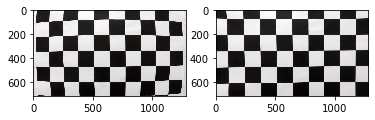

In [3]:
"""Undistorts the image using calibration of the camera"""
objpoints, imgpoints = gather_calibration_points()

# Compute the camera calibration matrix, distortion coefficients, rotation and translation vectors
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (720,1280), None, None)

# Test
img = mpimg.imread("camera_cal/{}".format('calibration1.jpg'))
undist = cv2.undistort(img, mtx, dist, None, mtx)

fig, axes = plt.subplots(1, 2)
#plt.imsave("output_images/undist_calibration2.jpg",undist)
axes[0].imshow(img)
axes[1].imshow(undist)
plt.savefig("output_images/undist_output.png")

## 3. Apply different thresholding to create binary image

In [4]:
# A function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Apply a threshold to the S channel
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    # Return a binary image of threshold result
    return binary_output

In [5]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    abs_sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    # 3) Take the absolute value of the x and y gradients
    abs_sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir = np.arctan2(abs_sobel_y, abs_sobel_x)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dir)
    binary_output[(dir >= thresh[0]) & (dir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [6]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately 
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobel_x**2 + sobel_y**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [7]:
def abs_sobel_thresh(img, orient='x',sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

In [8]:
def combine_binary_outputs(img, ksize=3, mag_low=30, mag_high=100, dir_low=0.6, dir_high=1.5,
                                    hls_low=90, hls_high=255, bright_low=20, bright_high=100):
    """Calculates and combines the binary outputs from different thresholding techniques"""
    # Calculate all the binaries 
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(bright_low, bright_high))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(bright_low, bright_high))
    mag_binary = mag_thresh(img, sobel_kernel=7, mag_thresh=(mag_low, mag_high))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(dir_low, dir_high))
    hls_binary = hls_select(img, thresh=(hls_low, hls_high))

    # Combine all the binaries
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) | (grady == 1) | (mag_binary == 1)) & ((dir_binary == 1) | (hls_binary == 1))] = 1
    
    # Use morphological closing operator to make the edge lines continuous
    kernel = np.ones((3, 3), np.uint8)
    combined = cv2.morphologyEx(combined.astype(np.uint8), cv2.MORPH_OPEN, kernel) # opening to remove noise
    
    kernel = np.ones((5, 5), np.uint8)
    combined = cv2.morphologyEx(combined.astype(np.uint8), cv2.MORPH_CLOSE, kernel) # closing to extend the edge lines
    # axes[i,0].imshow(gradx, cmap='gray')
    # axes[i,0].set_title('gradx')
    # axes[i,1].imshow(grady, cmap='gray')
    # axes[i,1].set_title('grady')
    # axes[i,2].imshow(mag_binary, cmap='gray')
    # axes[i,2].set_title('mag_binary')
    # axes[i,3].imshow(dir_binary, cmap='gray')
    # axes[i,3].set_title('dir_binary')
    # axes[i,4].imshow(hls_binary, cmap='gray')
    # axes[i,4].set_title('hls_binary')
    # axes[i,5].imshow(combined, cmap='gray')
    # axes[i,5].set_title('combined')
    return combined

In [9]:
#from IPython.html import widgets
from ipywidgets import interact
#from IPython.display import display

file = "test3.jpg"
img = mpimg.imread("test_images/{}".format(file))
img = cv2.undistort(img, mtx, dist, None, mtx)

def interactive_mask(ksize, mag_low, mag_high, dir_low, dir_high, hls_low, hls_high, bright_low, bright_high):
    combined = combine_binary_outputs(img, ksize, mag_low, mag_high, dir_low, dir_high,\
                                    hls_low, hls_high, bright_low, bright_high)
    plt.figure(figsize=(10,10))
    plt.imshow(combined,cmap='gray')

interact(interactive_mask, ksize=(1,31,2), mag_low=(0,255), mag_high=(0,255),\
         dir_low=(0, np.pi/2), dir_high=(0, np.pi/2), hls_low=(0,255),\
         hls_high=(0,255), bright_low=(0,255), bright_high=(0,255))

interactive(children=(IntSlider(value=15, description='ksize', max=31, min=1, step=2), IntSlider(value=127, de…

<function __main__.interactive_mask(ksize, mag_low, mag_high, dir_low, dir_high, hls_low, hls_high, bright_low, bright_high)>

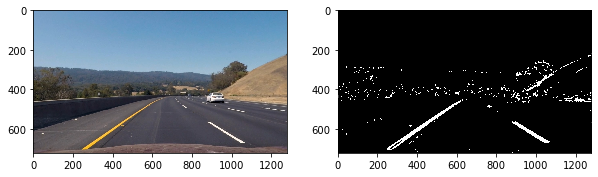

In [10]:
fig, axes = plt.subplots(1,2,figsize=(10,10))
combined = combine_binary_outputs(img, ksize=13, mag_low=50, mag_high=160,
                                  dir_low=0.5, dir_high=1.2, hls_low=80, hls_high=255, bright_low=15, bright_high=255)

axes[0].imshow(img)
axes[1].imshow(combined,cmap='gray')

## 4. Perspective trasform to top-view


Manually select points on a straight road image

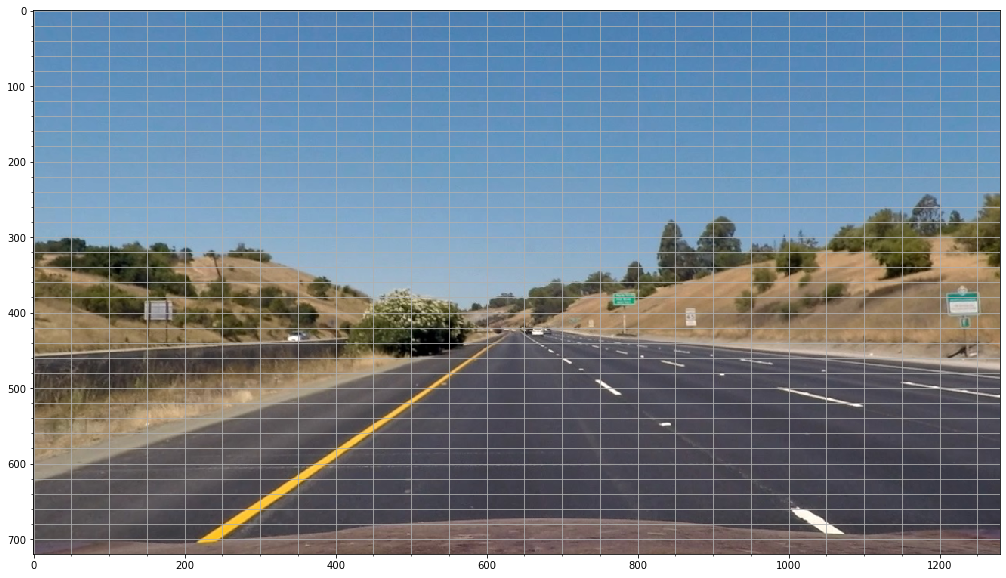

In [11]:
img=mpimg.imread("test_images/straight_lines1.jpg")
img_original = img.copy()
img= cv2.undistort(img, mtx, dist, None, mtx)

#img = cv2.polylines(img, np.int32([[[200, 720], [575, 460], [700, 460], [1100, 720]]]), True, color=(255,0,0), thickness=3)

plt.figure(figsize=(20,10))
plt.imshow(img)
plt.grid(True, 'both')
plt.minorticks_on()

#plt.savefig("output_images/src.png")

 Look at a straight lines image and determine 4 points to project into top view.
 
 Manual picking of 4 points (720, 200), (460, 575), (460, 700), (720, 1100)
 
 Remember that retar cv2 flips height and width.

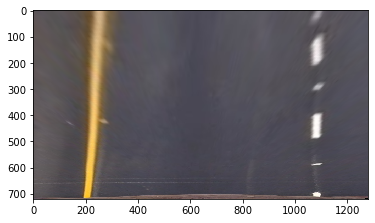

In [12]:
def getM():
    src = np.float32([[200, 720], [575, 460], [700, 460], [1100, 720]])

    # define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    # LEt's have a margin of 200 in x and a margin of 100 on the top such that we assume the lane length to be 30m
    h = 720; w = 1280
    dst = np.float32([[200,h],
                    [200,100],
                    [w-200,100],
                    [w-200,h]])
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    return M
M = getM()
# use cv2.warpPerspective() to warp the image to a top-down view
warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
# warped = cv2.polylines(warped, np.int32([[[200,h],
#                     [200,100],
#                     [w-200,100],
#                     [w-200,h]]]), True, color=(255,0,0), thickness=3)
plt.imshow(warped)
plt.imsave("output_images/birdeye_straight_lines1.jpg",warped)

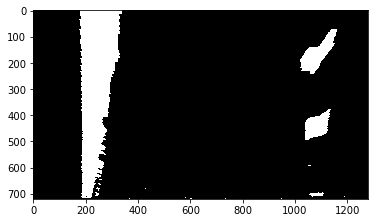

In [14]:
# Warp the binary image into top-down view, using the same parameters as above
h = 720; w = 1280

combined = combine_binary_outputs(img, ksize=13, mag_low=50, mag_high=160,
                                  dir_low=0.5, dir_high=1.2, hls_low=80, hls_high=255, bright_low=15, bright_high=255)

binary_warped = cv2.warpPerspective(combined, M, (w,h), flags=cv2.INTER_LINEAR)

plt.imshow(binary_warped, cmap="gray")
plt.imsave("output_images/topview_binary_test3.jpg",binary_warped)

## 5. Detect lane pixels and fit a quadratic polynomial

### Using Mixture of Gaussians (MOG) prior for detecting lanes

Prior: the lne lines are more probable to be in the center of the left and right halves of the image. So, we weigh the histogram with a gaussian prior as seen below

In [15]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

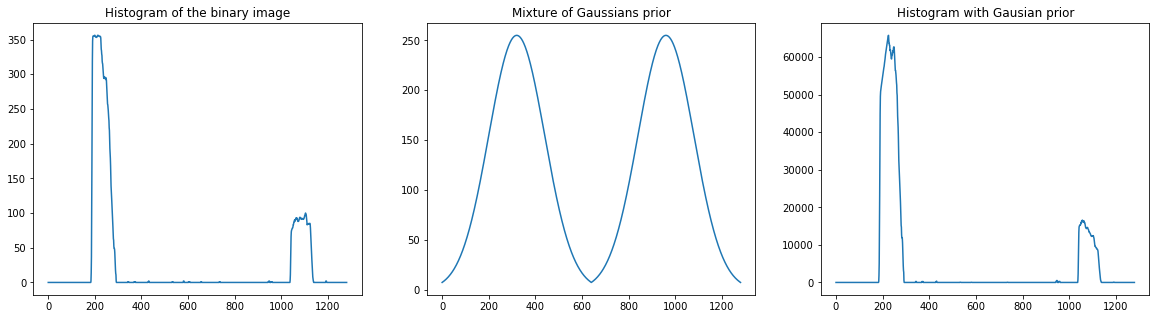

In [16]:
fig, axes = plt.subplots(1, 3, figsize = (20,5))
x1 = np.linspace(0,640,640)
x2 = np.linspace(640,1280,640)

x = np.concatenate((x1,x2))
gauss_prior = np.concatenate((gaussian(x1,320,120),gaussian(x2,640+320,120)))*255

histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
axes[0].plot(x, histogram)
axes[0].set_title("Histogram of the binary image")

axes[1].plot(x,gauss_prior)
axes[1].set_title("Mixture of Gaussians prior")

axes[2].plot(x, histogram*gauss_prior)
axes[2].set_title("Histogram with Gausian prior")

plt.savefig("output_images/lanes_prior.png")

### Detecting lane pixels and fitting polynomials 

In [17]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Prior: the lne lines are more probable to be in the center of the left and right halves of the image
    # So, we weigh the histogram with a gaussian prior as seen above
    histogram = histogram*gauss_prior
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped,binary_warped,binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

255


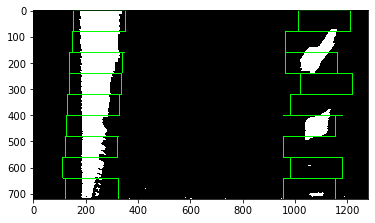

In [18]:
leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
print(out_img.max())
plt.imshow(out_img)

In [19]:
def linfit(A, y, λ=0.001):
    """Linear regression with regularization.
    .. math::
        (\mathbf{A}^T\mathbf{A} + \lambda \mathbf{I})x = \mathbf{A}^T y
    Inputs:
        A: coefficient matrix (x)
        y
    Example usage:
        >>> x = np.array([0, 1, 2, 3])
        >>> y = np.array([-1, 0.2, 0.9, 2.1])
        >>> A = np.vstack([x, np.ones(len(x))]).T #ones are for the intercept
        >>> m,c = linfit(A,y)
    Author: Zeeshan Khan Suri
    License: CC
    """
    return np.linalg.solve(A.T.dot(A) + λ * np.identity(A.shape[1]), A.T.dot(y))

In [20]:
def fit_poly(img_shape, leftx, lefty, rightx, righty, xm_per_pix=1, ym_per_pix=1):
    """ Fits a second order polynomial to each detected lane using np.polyfit() and evaluates the polynomial for plotting"""
#     left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
#     right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Using my own function for least squares fitting with regularization
    A_left = np.vstack([(lefty*ym_per_pix)**2, lefty*ym_per_pix, np.ones(len(lefty))]).T
    A_right = np.vstack([(righty*ym_per_pix)**2, righty*ym_per_pix, np.ones(len(righty))]).T
    left_fit = linfit(A_left, leftx*xm_per_pix, 0.01)
    right_fit = linfit(A_right, rightx*xm_per_pix, 0.01)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])*ym_per_pix
    
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    try:
        left_fitx = np.polyval(left_fit, ploty)
        right_fitx = np.polyval(right_fit, ploty)
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

In [21]:
def fit_polynomial(binary_warped):
    """Finds lanes from the binary image, fits a quadratic polynomial and plots them on the binary image"""
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, w)
    plt.ylim(h, 0)

    return out_img, left_fit, right_fit, left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty

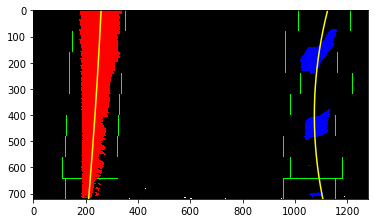

In [22]:
out_img, left_fit, right_fit, left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty = fit_polynomial(binary_warped)
plt.imshow(out_img)
plt.imsave("output_images/detectedlanes_test3.jpg",out_img/255)

### Searching around previously found polynomial for effeciency

In [23]:
def search_around_poly(binary_warped, left_fit, right_fit, margin = 100):
    """Uses the lanes from previous frame to search in its neighborhood effeciently
    # HYPERPARAMETER: margin is the width of the margin around the previous polynomial to search
    """

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return leftx, lefty, rightx, righty, out_img

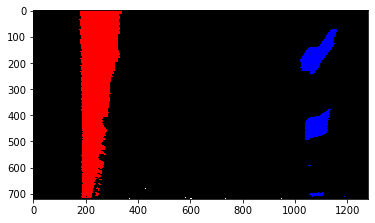

In [24]:
leftx, lefty, rightx, righty, out_img = search_around_poly(binary_warped, left_fit, right_fit, margin = 100)
plt.imshow(out_img)

In [27]:
def search_around_polynomial(binary_warped, left_fit, right_fit):
    margin = 100 # HYPERPARAMETER: margin is the width of the margin around the previous polynomial to search
    leftx, lefty, rightx, righty, out_img = search_around_poly(binary_warped, left_fit, right_fit, margin)

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

    ## Visualization ##
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    window_img = np.zeros_like(out_img)
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    return out_img, left_fit, right_fit, left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty

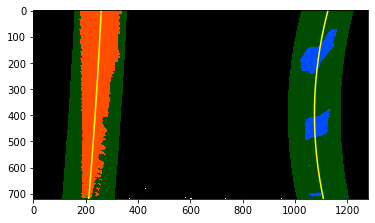

In [28]:
out_img, left_fit, right_fit, left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty = search_around_polynomial(binary_warped, left_fit, right_fit)
plt.imshow(out_img)

## 6. Calculate the radius of the curvature in real world co-ordinates

Radius of Curvature
The radius of curvature at any point $x$ of the function $x=f(y)$ is given as follows:

$$
\LARGE R_{curve} = \frac{[1 + (\frac{dx}{dy})^2]^{3/2}}{|\frac{d^2x}{dy^2}|}
$$
 
​	 

In the case of the second order polynomial $f(y)=Ay^2+By+C$, the first and second derivatives are:

$$
\large f'(y) = \frac{dx}{dy} = 2Ay+ B
$$

$$
\large f''(y) = \frac{d^2x}{dy^2} = 2Af
$$

So, our equation for radius of curvature becomes:

$$
\LARGE R_{curve} = \frac{(1 + (2Ay + B)^2)^{3/2}}{\left|2A \right|}
$$
​
The $x,y$ are supposed to be in real world coordinates, instead of pixel coordinates. So, we multiply with a scaling factor.

Assuming that the lane is about 30 meters long and 3.7 meters wide, the scaling factor is in vertical direction is 30/height and in horizontal direction is 3.7/(width-2*margin).  
Vehicle position with respect to center:

Assuming the camera is mounted at the center of the car, such that the lane center is the midpoint at the bottom of the image between the two detected lines, the offset of the lane center from the center of the image (converted from pixels to meters) is the distance from the center of the lane to the center of the image.

In [29]:
def roc_offset(binary_warped, leftx, lefty, rightx, righty, xm_per_pix = 3.7/(1280-400), ym_per_pix = 30/720):
    """Calculates the radius of curvature and offset of the detected lane pixels in meters"""
    # Calculate the fits in meters
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty, xm_per_pix, ym_per_pix)

    y_eval = np.max(ploty)

    # Calculate the radius of curvature
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Offset
    # The offset of the lane center from the center of the image (converted from pixels to meters) is the distance from the center of the lane
    lane_center = (left_fitx[-1] + right_fitx[-1])/2 # the lane center is the midpoint at the bottom of the image between the two lines
    offset = (w*xm_per_pix/2 - lane_center) # offset is the difference of the lane cener from the image cemter (in meters)
    
    return left_curverad, right_curverad, offset

In [30]:
left_curverad, right_curverad, offset = roc_offset(binary_warped, leftx, lefty, rightx, righty, xm_per_pix = 3.7/(1280-400), ym_per_pix = 30/720)
leftorright = "left" if offset < 0 else "right"

## 7. Warp the detected lane boundaries back onto the original image.

In [31]:
# Create an image to draw the lines on
color_warp = np.zeros_like(img).astype(np.uint8)

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

## 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

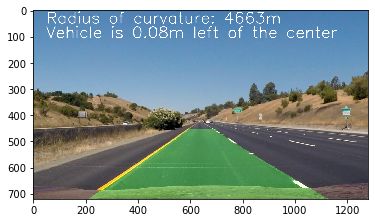

In [32]:
# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

Minv = np.linalg.pinv(M)

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (w,h)) 
# Combine the result with the original image
result = cv2.addWeighted(img_original, 1, newwarp, 0.3, 0)

cv2.putText(result, "Radius of curvature: {:.0f}m ".format((left_curverad+right_curverad)/2), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255),2 ,cv2.LINE_AA)
cv2.putText(result, "Vehicle is {:.2f}m {} of the center".format(np.abs(offset), leftorright), (50,105), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255),2 ,cv2.LINE_AA)

plt.imshow(result)
plt.imsave("output_images/result_test3.jpg", result)

## Combining everything to run on the video

In [56]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # polynomial coefficients of the last n fits
        self.recent_fits = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  


In [57]:
class VideoAttributes():
    def __init__(self):
        self. firstframe = True
        self.mtx = None
        self.dist = None
        self.M = None
        self.Minv = None
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        w = 1280
        self.xm_per_pix = 3.7/(w-400) # meters per pixel in x dimension # 200 margin on left and right of the lane
        self.validation = True
        self.frame = 1
        self.result = np.zeros((720,w,3),dtype="uint8")

In [82]:
def process_img(img):
    """The whole pipeline"""
    global videoattr
    global leftLane
    global rightLane
    h,w = img.shape[0], img.shape[1]

    # The output should be a color image (3 channel) for processing video below
    img_original = img.copy()
    
    # If running first time, calibrate camera
    if videoattr.firstframe:
        objpoints, imgpoints = gather_calibration_points()
        ret, videoattr.mtx, videoattr.dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (w,h), None, None)
        videoattr.M = getM()
        videoattr.Minv = np.linalg.pinv(videoattr.M)    # pseudo inverse

    # Undistort image
    img = cv2.undistort(img, mtx, dist, None, mtx)

    # Edge detection 
    combined = combine_binary_outputs(img)

    # Perspective transform
    binary_warped = cv2.warpPerspective(combined, videoattr.M, (w,h), flags=cv2.INTER_LINEAR)
    
    # Detect lane pixels
    if (videoattr.firstframe) or (not leftLane.detected) or (not rightLane.detected):
        # If lane was not detected previously. detect it again
        leftLane.allx, leftLane.ally, rightLane.allx, rightLane.ally, out_img = find_lane_pixels(binary_warped) 
    else:
        # Else, use previous frame's lane data to search in it's neighborhood
        leftLane.allx, leftLane.ally, rightLane.allx, rightLane.ally, out_img = search_around_poly(binary_warped, leftLane.current_fit, rightLane.current_fit)
    
    # Fit polynomial and find the pixels (in meters)
    left_fitx, right_fitx, ploty, leftLane.current_fit, rightLane.current_fit = fit_poly(binary_warped.shape, leftLane.allx, leftLane.ally, rightLane.allx, rightLane.ally)

    # Validation: Check if the detected lanes make sense
    if len(leftLane.current_fit) != 3:
        leftLane.detected = False
    else:
        leftLane.detected = True    
    # lane width is in defined borders
    #if ((np.abs(left_fitx[-1] - right_fitx[-1]) < 3) and np.abs(left_fitx[-1] - right_fitx[-1]) > 4.4)
        #leftLane.detected = False
    
    if leftLane.detected:
        if videoattr.firstframe: 
            leftLane.bestx, leftLane.best_fit = left_fitx, leftLane.current_fit
        else:
            leftLane.diffs = leftLane.recent_fits[-1] - leftLane.current_fit #difference in fit coefficients between last and new fits
        leftLane.recent_xfitted.append(left_fitx)   # fitx of the last 30 fits
        leftLane.recent_fits.append(leftLane.current_fit) # polynomial coefficients of the last n fits
        if len(leftLane.recent_fits) > 15: # Maintain a list of 15 latest fits
            del leftLane.recent_xfitted[0]
            del leftLane.recent_fits[0]
            
     # Validation: Check if the detected lanes make sense
    if len(rightLane.current_fit) != 3:
        rightLane.detected = False
    else:
        rightLane.detected = True    
    # lane width is in defined borders
    #if ((np.abs(right_fitx[-1] - right_fitx[-1]) < 3) and np.abs(right_fitx[-1] - right_fitx[-1]) > 4.4)
        #rightLane.detected = False
    
    if rightLane.detected:
        if videoattr.firstframe: 
            rightLane.bestx, rightLane.best_fit = right_fitx, rightLane.current_fit
        else:
            rightLane.diffs = rightLane.recent_fits[-1] - rightLane.current_fit #difference in fit coefficients between last and new fits
        rightLane.recent_xfitted.append(right_fitx)   # fitx of the last 30 fits
        rightLane.recent_fits.append(rightLane.current_fit) # polynomial coefficients of the last n fits
        if len(rightLane.recent_fits) > 15: # Maintain a list of 15 latest fits
            del rightLane.recent_xfitted[0]
            del rightLane.recent_fits[0]
        
    if (not videoattr.firstframe) and leftLane.detected:
        leftLane.bestx = sum(leftLane.recent_xfitted)/len(leftLane.recent_xfitted)
        leftLane.best_fit = sum(leftLane.recent_fits)/len(leftLane.recent_fits)
    if (not videoattr.firstframe) and rightLane.detected:
        rightLane.bestx = sum(rightLane.recent_xfitted)/len(rightLane.recent_xfitted)
        rightLane.best_fit = sum(rightLane.recent_fits)/len(rightLane.recent_fits)
        
    # Radius of curvature and offset    
    leftLane.radius_of_curvature, rightLane.radius_of_curvature, offset = roc_offset(binary_warped, leftLane.allx, leftLane.ally, rightLane.allx, rightLane.ally, videoattr.xm_per_pix, videoattr.ym_per_pix)
    leftorright = "left" if offset < 0 else "right"
        
    # Validation of the result
    if leftLane.detected and rightLane.detected:
        # lane lines have the same concavity
        if (leftLane.current_fit[0]*rightLane.current_fit[0] < 0):
            videoattr.validation = False
            print("Frame {} lanes have diff concavity".format(videoattr.frame+1))
        # distance between left and right lines at the base of the image is roughly the same as at the top of the image (in birds-eye view)
        #if np.abs((right_fit[0] - left_fitx[0]) - (right_fit[-1] - left_fitx[-1])) > 0.5:
        #    videoattr.validation = False
        
    
    if videoattr.validation:
        color_warp = np.zeros_like(img_original).astype(np.uint8)

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([leftLane.bestx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([rightLane.bestx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (w,h)) 
        
        videoattr.result = newwarp
        print("Frame {} detected".format(videoattr.frame+1))
    else:
        print("Frame {} not detected".format(videoattr.frame+1))
        newwarp = videoattr.result # previous frame's result
    # Combine the result with the original image
    result = cv2.addWeighted(img_original, 1, newwarp, 0.3, 0)

    try:
        cv2.putText(result, "Radius of curvature: {:.0f}m ".format((leftLane.radius_of_curvature+rightLane.radius_of_curvature)/2), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255),2 ,cv2.LINE_AA)
        cv2.putText(result, "Vehicle is {:.2f}m {} of the center".format(np.abs(offset), leftorright), (50,105), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255),2 ,cv2.LINE_AA)
    except TypeError:
        print("unable to put text")
        
    # Initialization for the next frame
    videoattr.firstframe = False
    videoattr.validation = True
    videoattr.frame+=1
    
    return result

In [83]:
white_output = 'result1.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
videoattr = VideoAttributes()

leftLane = Line()
rightLane = Line()

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_img) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

                                                                                                                       


                                                                                                              

                                                                                                                 
                                                                                                                    



                                                                                                           




t:  65%|███████████████████████████████████████████                       | 821/1260 [30:06<01:46,  4.13it/s, now=None]


t:   5%|███▎                                                               | 62/1260 [22:56<04:15,  4.69it/s, now=None]

t:  42%|███████████████████████████▍                                      | 523/1260 [26:09<03:01,  4.06it/s, now=None]



t:   3%|█▊                                            

Frame 2 detected
Moviepy - Building video result1.mp4.
Moviepy - Writing video result1.mp4









t:   0%|                                                                    | 2/1260 [00:00<04:00,  5.24it/s, now=None]

Frame 3 detected








t:   0%|▏                                                                   | 3/1260 [00:00<05:14,  4.00it/s, now=None]

Frame 4 detected








t:   0%|▏                                                                   | 4/1260 [00:01<05:36,  3.73it/s, now=None]

Frame 5 detected








t:   0%|▎                                                                   | 5/1260 [00:01<05:38,  3.71it/s, now=None]

Frame 6 lanes have diff concavity
Frame 6 not detected








t:   0%|▎                                                                   | 6/1260 [00:01<05:46,  3.61it/s, now=None]

Frame 7 detected








t:   1%|▍                                                                   | 7/1260 [00:01<05:47,  3.61it/s, now=None]

Frame 8 detected








t:   1%|▍                                                                   | 8/1260 [00:02<05:49,  3.58it/s, now=None]

Frame 9 detected








t:   1%|▍                                                                   | 9/1260 [00:02<05:46,  3.61it/s, now=None]

Frame 10 detected








t:   1%|▌                                                                  | 10/1260 [00:02<05:43,  3.63it/s, now=None]

Frame 11 lanes have diff concavity
Frame 11 not detected








t:   1%|▌                                                                  | 11/1260 [00:03<05:41,  3.65it/s, now=None]

Frame 12 lanes have diff concavity
Frame 12 not detected








t:   1%|▋                                                                  | 12/1260 [00:03<05:48,  3.58it/s, now=None]

Frame 13 lanes have diff concavity
Frame 13 not detected








t:   1%|▋                                                                  | 13/1260 [00:03<06:08,  3.39it/s, now=None]

Frame 14 detected








t:   1%|▋                                                                  | 14/1260 [00:03<06:00,  3.45it/s, now=None]

Frame 15 detected








t:   1%|▊                                                                  | 15/1260 [00:04<05:46,  3.59it/s, now=None]

Frame 16 lanes have diff concavity
Frame 16 not detected








t:   1%|▊                                                                  | 16/1260 [00:04<05:34,  3.72it/s, now=None]

Frame 17 lanes have diff concavity
Frame 17 not detected








t:   1%|▉                                                                  | 17/1260 [00:04<06:09,  3.36it/s, now=None]

Frame 18 lanes have diff concavity
Frame 18 not detected








t:   1%|▉                                                                  | 18/1260 [00:05<06:56,  2.98it/s, now=None]

Frame 19 lanes have diff concavity
Frame 19 not detected








t:   2%|█                                                                  | 19/1260 [00:05<07:03,  2.93it/s, now=None]

Frame 20 lanes have diff concavity
Frame 20 not detected








t:   2%|█                                                                  | 20/1260 [00:05<06:45,  3.05it/s, now=None]

Frame 21 detected








t:   2%|█                                                                  | 21/1260 [00:06<06:14,  3.31it/s, now=None]

Frame 22 lanes have diff concavity
Frame 22 not detected








t:   2%|█▏                                                                 | 22/1260 [00:06<05:45,  3.59it/s, now=None]

Frame 23 lanes have diff concavity
Frame 23 not detected








t:   2%|█▏                                                                 | 23/1260 [00:06<05:26,  3.79it/s, now=None]

Frame 24 lanes have diff concavity
Frame 24 not detected








t:   2%|█▎                                                                 | 24/1260 [00:06<05:25,  3.79it/s, now=None]

Frame 25 lanes have diff concavity
Frame 25 not detected








t:   2%|█▎                                                                 | 25/1260 [00:07<05:29,  3.75it/s, now=None]

Frame 26 lanes have diff concavity
Frame 26 not detected








t:   2%|█▍                                                                 | 26/1260 [00:07<05:28,  3.76it/s, now=None]

Frame 27 detected








t:   2%|█▍                                                                 | 27/1260 [00:07<05:22,  3.83it/s, now=None]

Frame 28 detected








t:   2%|█▍                                                                 | 28/1260 [00:07<05:23,  3.81it/s, now=None]

Frame 29 detected








t:   2%|█▌                                                                 | 29/1260 [00:08<05:16,  3.89it/s, now=None]

Frame 30 detected








t:   2%|█▌                                                                 | 30/1260 [00:08<05:15,  3.89it/s, now=None]

Frame 31 detected








t:   2%|█▋                                                                 | 31/1260 [00:08<05:10,  3.96it/s, now=None]

Frame 32 detected








t:   3%|█▋                                                                 | 32/1260 [00:08<05:11,  3.95it/s, now=None]

Frame 33 lanes have diff concavity
Frame 33 not detected








t:   3%|█▊                                                                 | 33/1260 [00:09<05:30,  3.71it/s, now=None]

Frame 34 lanes have diff concavity
Frame 34 not detected








t:   3%|█▊                                                                 | 34/1260 [00:09<05:50,  3.49it/s, now=None]

Frame 35 lanes have diff concavity
Frame 35 not detected








t:   3%|█▊                                                                 | 35/1260 [00:09<06:29,  3.15it/s, now=None]

Frame 36 lanes have diff concavity
Frame 36 not detected








t:   3%|█▉                                                                 | 36/1260 [00:10<06:35,  3.10it/s, now=None]

Frame 37 detected








t:   3%|█▉                                                                 | 37/1260 [00:10<06:44,  3.02it/s, now=None]

Frame 38 detected








t:   3%|██                                                                 | 38/1260 [00:10<06:39,  3.06it/s, now=None]

Frame 39 detected








t:   3%|██                                                                 | 39/1260 [00:11<06:16,  3.24it/s, now=None]

Frame 40 detected








t:   3%|██▏                                                                | 40/1260 [00:11<05:48,  3.50it/s, now=None]

Frame 41 detected








t:   3%|██▏                                                                | 41/1260 [00:11<05:28,  3.71it/s, now=None]

Frame 42 detected








t:   3%|██▏                                                                | 42/1260 [00:11<05:11,  3.91it/s, now=None]

Frame 43 lanes have diff concavity
Frame 43 not detected








t:   3%|██▎                                                                | 43/1260 [00:12<04:57,  4.08it/s, now=None]

Frame 44 detected








t:   3%|██▎                                                                | 44/1260 [00:12<05:13,  3.88it/s, now=None]

Frame 45 detected








t:   4%|██▍                                                                | 45/1260 [00:12<05:29,  3.69it/s, now=None]

Frame 46 lanes have diff concavity
Frame 46 not detected








t:   4%|██▍                                                                | 46/1260 [00:12<05:14,  3.86it/s, now=None]

Frame 47 lanes have diff concavity
Frame 47 not detected








t:   4%|██▍                                                                | 47/1260 [00:13<05:10,  3.91it/s, now=None]

Frame 48 lanes have diff concavity
Frame 48 not detected








t:   4%|██▌                                                                | 48/1260 [00:13<05:01,  4.03it/s, now=None]

Frame 49 lanes have diff concavity
Frame 49 not detected








t:   4%|██▌                                                                | 49/1260 [00:13<05:07,  3.94it/s, now=None]

Frame 50 lanes have diff concavity
Frame 50 not detected








t:   4%|██▋                                                                | 50/1260 [00:13<05:12,  3.87it/s, now=None]

Frame 51 lanes have diff concavity
Frame 51 not detected








t:   4%|██▋                                                                | 51/1260 [00:14<05:00,  4.02it/s, now=None]

Frame 52 lanes have diff concavity
Frame 52 not detected








t:   4%|██▊                                                                | 52/1260 [00:14<04:57,  4.06it/s, now=None]

Frame 53 lanes have diff concavity
Frame 53 not detected








t:   4%|██▊                                                                | 53/1260 [00:14<05:02,  3.99it/s, now=None]

Frame 54 detected








t:   4%|██▊                                                                | 54/1260 [00:14<04:55,  4.08it/s, now=None]

Frame 55 detected








t:   4%|██▉                                                                | 55/1260 [00:15<04:46,  4.20it/s, now=None]

Frame 56 detected








t:   4%|██▉                                                                | 56/1260 [00:15<04:44,  4.24it/s, now=None]

Frame 57 detected








t:   5%|███                                                                | 57/1260 [00:15<04:38,  4.32it/s, now=None]

Frame 58 lanes have diff concavity
Frame 58 not detected








t:   5%|███                                                                | 58/1260 [00:15<04:35,  4.36it/s, now=None]

Frame 59 lanes have diff concavity
Frame 59 not detected








t:   5%|███▏                                                               | 59/1260 [00:15<04:30,  4.45it/s, now=None]

Frame 60 lanes have diff concavity
Frame 60 not detected








t:   5%|███▏                                                               | 60/1260 [00:16<04:26,  4.50it/s, now=None]

Frame 61 lanes have diff concavity
Frame 61 not detected








t:   5%|███▏                                                               | 61/1260 [00:16<04:55,  4.06it/s, now=None]

Frame 62 detected








t:   5%|███▎                                                               | 62/1260 [00:16<04:54,  4.06it/s, now=None]

Frame 63 detected








t:   5%|███▎                                                               | 63/1260 [00:17<05:02,  3.96it/s, now=None]

Frame 64 detected








t:   5%|███▍                                                               | 64/1260 [00:17<04:54,  4.06it/s, now=None]

Frame 65 detected








t:   5%|███▍                                                               | 65/1260 [00:17<04:52,  4.08it/s, now=None]

Frame 66 lanes have diff concavity
Frame 66 not detected








t:   5%|███▌                                                               | 66/1260 [00:17<04:50,  4.11it/s, now=None]

Frame 67 lanes have diff concavity
Frame 67 not detected








t:   5%|███▌                                                               | 67/1260 [00:17<04:53,  4.06it/s, now=None]

Frame 68 lanes have diff concavity
Frame 68 not detected








t:   5%|███▌                                                               | 68/1260 [00:18<05:14,  3.79it/s, now=None]

Frame 69 lanes have diff concavity
Frame 69 not detected








t:   5%|███▋                                                               | 69/1260 [00:18<05:02,  3.94it/s, now=None]

Frame 70 detected








t:   6%|███▋                                                               | 70/1260 [00:18<04:46,  4.15it/s, now=None]

Frame 71 lanes have diff concavity
Frame 71 not detected








t:   6%|███▊                                                               | 71/1260 [00:18<04:45,  4.17it/s, now=None]

Frame 72 lanes have diff concavity
Frame 72 not detected








t:   6%|███▊                                                               | 72/1260 [00:19<04:46,  4.15it/s, now=None]

Frame 73 lanes have diff concavity
Frame 73 not detected








t:   6%|███▉                                                               | 73/1260 [00:19<04:39,  4.24it/s, now=None]

Frame 74 lanes have diff concavity
Frame 74 not detected








t:   6%|███▉                                                               | 74/1260 [00:19<04:39,  4.24it/s, now=None]

Frame 75 lanes have diff concavity
Frame 75 not detected








t:   6%|███▉                                                               | 75/1260 [00:19<04:33,  4.33it/s, now=None]

Frame 76 detected








t:   6%|████                                                               | 76/1260 [00:20<04:33,  4.32it/s, now=None]

Frame 77 detected








t:   6%|████                                                               | 77/1260 [00:20<05:08,  3.83it/s, now=None]

Frame 78 detected








t:   6%|████▏                                                              | 78/1260 [00:20<05:02,  3.91it/s, now=None]

Frame 79 detected








t:   6%|████▏                                                              | 79/1260 [00:20<05:03,  3.89it/s, now=None]

Frame 80 detected








t:   6%|████▎                                                              | 80/1260 [00:21<05:27,  3.60it/s, now=None]

Frame 81 detected








t:   6%|████▎                                                              | 81/1260 [00:21<05:50,  3.36it/s, now=None]

Frame 82 detected








t:   7%|████▎                                                              | 82/1260 [00:21<05:55,  3.32it/s, now=None]

Frame 83 detected








t:   7%|████▍                                                              | 83/1260 [00:22<06:02,  3.25it/s, now=None]

Frame 84 lanes have diff concavity
Frame 84 not detected








t:   7%|████▍                                                              | 84/1260 [00:22<06:24,  3.06it/s, now=None]

Frame 85 lanes have diff concavity
Frame 85 not detected








t:   7%|████▌                                                              | 85/1260 [00:22<06:11,  3.17it/s, now=None]

Frame 86 lanes have diff concavity
Frame 86 not detected








t:   7%|████▌                                                              | 86/1260 [00:23<06:04,  3.22it/s, now=None]

Frame 87 lanes have diff concavity
Frame 87 not detected








t:   7%|████▋                                                              | 87/1260 [00:23<05:36,  3.48it/s, now=None]

Frame 88 lanes have diff concavity
Frame 88 not detected








t:   7%|████▋                                                              | 88/1260 [00:23<05:11,  3.77it/s, now=None]

Frame 89 lanes have diff concavity
Frame 89 not detected








t:   7%|████▋                                                              | 89/1260 [00:23<04:58,  3.92it/s, now=None]

Frame 90 detected








t:   7%|████▊                                                              | 90/1260 [00:24<04:52,  4.00it/s, now=None]

Frame 91 detected








t:   7%|████▊                                                              | 91/1260 [00:24<04:44,  4.10it/s, now=None]

Frame 92 detected








t:   7%|████▉                                                              | 92/1260 [00:24<04:56,  3.94it/s, now=None]

Frame 93 detected








t:   7%|████▉                                                              | 93/1260 [00:24<05:07,  3.79it/s, now=None]

Frame 94 detected








t:   7%|████▉                                                              | 94/1260 [00:25<05:26,  3.58it/s, now=None]

Frame 95 detected








t:   8%|█████                                                              | 95/1260 [00:25<05:33,  3.49it/s, now=None]

Frame 96 lanes have diff concavity
Frame 96 not detected








t:   8%|█████                                                              | 96/1260 [00:25<05:14,  3.70it/s, now=None]

Frame 97 detected








t:   8%|█████▏                                                             | 97/1260 [00:25<04:56,  3.92it/s, now=None]

Frame 98 detected








t:   8%|█████▏                                                             | 98/1260 [00:26<04:45,  4.07it/s, now=None]

Frame 99 detected








t:   8%|█████▎                                                             | 99/1260 [00:26<04:34,  4.23it/s, now=None]

Frame 100 detected








t:   8%|█████▏                                                            | 100/1260 [00:26<04:51,  3.97it/s, now=None]

Frame 101 detected








t:   8%|█████▎                                                            | 101/1260 [00:27<05:09,  3.75it/s, now=None]

Frame 102 detected








t:   8%|█████▎                                                            | 102/1260 [00:27<05:13,  3.69it/s, now=None]

Frame 103 detected








t:   8%|█████▍                                                            | 103/1260 [00:27<04:50,  3.98it/s, now=None]

Frame 104 detected








t:   8%|█████▍                                                            | 104/1260 [00:27<04:39,  4.14it/s, now=None]

Frame 105 detected








t:   8%|█████▌                                                            | 105/1260 [00:27<04:31,  4.26it/s, now=None]

Frame 106 detected








t:   8%|█████▌                                                            | 106/1260 [00:28<04:23,  4.39it/s, now=None]

Frame 107 detected








t:   8%|█████▌                                                            | 107/1260 [00:28<04:20,  4.43it/s, now=None]

Frame 108 detected








t:   9%|█████▋                                                            | 108/1260 [00:28<04:16,  4.48it/s, now=None]

Frame 109 detected
Frame 110 lanes have diff concavity
Frame 110 not detected








t:   9%|█████▋                                                            | 109/1260 [00:28<04:09,  4.61it/s, now=None]





t:   9%|█████▊                                                            | 110/1260 [00:29<04:13,  4.55it/s, now=None]

Frame 111 lanes have diff concavity
Frame 111 not detected
Frame 112 lanes have diff concavity
Frame 112 not detected








t:   9%|█████▊                                                            | 111/1260 [00:29<04:07,  4.63it/s, now=None]





t:   9%|█████▊                                                            | 112/1260 [00:29<04:04,  4.69it/s, now=None]

Frame 113 lanes have diff concavity
Frame 113 not detected








t:   9%|█████▉                                                            | 113/1260 [00:29<04:03,  4.72it/s, now=None]

Frame 114 lanes have diff concavity
Frame 114 not detected








t:   9%|█████▉                                                            | 114/1260 [00:29<04:00,  4.77it/s, now=None]

Frame 115 lanes have diff concavity
Frame 115 not detected








t:   9%|██████                                                            | 115/1260 [00:30<04:03,  4.70it/s, now=None]

Frame 116 lanes have diff concavity
Frame 116 not detected








t:   9%|██████                                                            | 116/1260 [00:30<04:04,  4.69it/s, now=None]

Frame 117 lanes have diff concavity
Frame 117 not detected








t:   9%|██████▏                                                           | 117/1260 [00:30<04:05,  4.66it/s, now=None]

Frame 118 lanes have diff concavity
Frame 118 not detected








t:   9%|██████▏                                                           | 118/1260 [00:30<04:06,  4.64it/s, now=None]

Frame 119 lanes have diff concavity
Frame 119 not detected








t:   9%|██████▏                                                           | 119/1260 [00:30<04:11,  4.54it/s, now=None]

Frame 120 lanes have diff concavity
Frame 120 not detected








t:  10%|██████▎                                                           | 120/1260 [00:31<04:17,  4.43it/s, now=None]

Frame 121 lanes have diff concavity
Frame 121 not detected








t:  10%|██████▎                                                           | 121/1260 [00:31<04:30,  4.21it/s, now=None]

Frame 122 detected








t:  10%|██████▍                                                           | 122/1260 [00:31<04:46,  3.98it/s, now=None]

Frame 123 detected








t:  10%|██████▍                                                           | 123/1260 [00:31<04:44,  4.00it/s, now=None]

Frame 124 detected








t:  10%|██████▍                                                           | 124/1260 [00:32<04:40,  4.06it/s, now=None]

Frame 125 detected








t:  10%|██████▌                                                           | 125/1260 [00:32<04:36,  4.10it/s, now=None]

Frame 126 detected








t:  10%|██████▌                                                           | 126/1260 [00:32<04:34,  4.13it/s, now=None]

Frame 127 detected








t:  10%|██████▋                                                           | 127/1260 [00:32<04:33,  4.14it/s, now=None]

Frame 128 detected








t:  10%|██████▋                                                           | 128/1260 [00:33<04:33,  4.14it/s, now=None]

Frame 129 detected








t:  10%|██████▊                                                           | 129/1260 [00:33<04:52,  3.87it/s, now=None]

Frame 130 detected








t:  10%|██████▊                                                           | 130/1260 [00:33<05:11,  3.63it/s, now=None]

Frame 131 detected








t:  10%|██████▊                                                           | 131/1260 [00:34<05:03,  3.72it/s, now=None]

Frame 132 detected








t:  10%|██████▉                                                           | 132/1260 [00:34<04:55,  3.82it/s, now=None]

Frame 133 detected








t:  11%|██████▉                                                           | 133/1260 [00:34<04:48,  3.91it/s, now=None]

Frame 134 detected








t:  11%|███████                                                           | 134/1260 [00:34<04:39,  4.03it/s, now=None]

Frame 135 detected








t:  11%|███████                                                           | 135/1260 [00:35<04:37,  4.05it/s, now=None]

Frame 136 detected








t:  11%|███████                                                           | 136/1260 [00:35<04:56,  3.79it/s, now=None]

Frame 137 detected








t:  11%|███████▏                                                          | 137/1260 [00:35<05:21,  3.49it/s, now=None]

Frame 138 detected








t:  11%|███████▏                                                          | 138/1260 [00:35<05:07,  3.65it/s, now=None]

Frame 139 detected








t:  11%|███████▎                                                          | 139/1260 [00:36<04:55,  3.80it/s, now=None]

Frame 140 detected








t:  11%|███████▎                                                          | 140/1260 [00:36<04:56,  3.77it/s, now=None]

Frame 141 detected








t:  11%|███████▍                                                          | 141/1260 [00:36<04:53,  3.81it/s, now=None]

Frame 142 detected








t:  11%|███████▍                                                          | 142/1260 [00:36<05:06,  3.65it/s, now=None]

Frame 143 detected








t:  11%|███████▍                                                          | 143/1260 [00:37<05:26,  3.42it/s, now=None]

Frame 144 detected








t:  11%|███████▌                                                          | 144/1260 [00:37<05:20,  3.48it/s, now=None]

Frame 145 detected








t:  12%|███████▌                                                          | 145/1260 [00:37<05:02,  3.68it/s, now=None]

Frame 146 lanes have diff concavity
Frame 146 not detected








t:  12%|███████▋                                                          | 146/1260 [00:38<04:49,  3.85it/s, now=None]

Frame 147 detected








t:  12%|███████▋                                                          | 147/1260 [00:38<04:41,  3.95it/s, now=None]

Frame 148 detected








t:  12%|███████▊                                                          | 148/1260 [00:38<04:44,  3.91it/s, now=None]

Frame 149 detected








t:  12%|███████▊                                                          | 149/1260 [00:38<04:38,  3.99it/s, now=None]

Frame 150 detected








t:  12%|███████▊                                                          | 150/1260 [00:39<04:35,  4.03it/s, now=None]

Frame 151 detected








t:  12%|███████▉                                                          | 151/1260 [00:39<04:33,  4.05it/s, now=None]

Frame 152 detected








t:  12%|███████▉                                                          | 152/1260 [00:39<04:37,  3.99it/s, now=None]

Frame 153 detected








t:  12%|████████                                                          | 153/1260 [00:39<04:35,  4.02it/s, now=None]

Frame 154 detected








t:  12%|████████                                                          | 154/1260 [00:40<04:40,  3.94it/s, now=None]

Frame 155 detected








t:  12%|████████                                                          | 155/1260 [00:40<04:38,  3.97it/s, now=None]

Frame 156 detected








t:  12%|████████▏                                                         | 156/1260 [00:40<04:36,  4.00it/s, now=None]

Frame 157 detected








t:  12%|████████▏                                                         | 157/1260 [00:40<04:35,  4.00it/s, now=None]

Frame 158 detected








t:  13%|████████▎                                                         | 158/1260 [00:41<04:35,  4.00it/s, now=None]

Frame 159 detected








t:  13%|████████▎                                                         | 159/1260 [00:41<04:35,  4.00it/s, now=None]

Frame 160 detected








t:  13%|████████▍                                                         | 160/1260 [00:41<04:36,  3.98it/s, now=None]

Frame 161 detected








t:  13%|████████▍                                                         | 161/1260 [00:41<04:33,  4.02it/s, now=None]

Frame 162 detected








t:  13%|████████▍                                                         | 162/1260 [00:42<04:38,  3.94it/s, now=None]

Frame 163 detected








t:  13%|████████▌                                                         | 163/1260 [00:42<05:00,  3.65it/s, now=None]

Frame 164 detected








t:  13%|████████▌                                                         | 164/1260 [00:42<05:16,  3.47it/s, now=None]

Frame 165 detected








t:  13%|████████▋                                                         | 165/1260 [00:42<05:00,  3.64it/s, now=None]

Frame 166 detected








t:  13%|████████▋                                                         | 166/1260 [00:43<04:56,  3.69it/s, now=None]

Frame 167 detected








t:  13%|████████▋                                                         | 167/1260 [00:43<05:06,  3.56it/s, now=None]

Frame 168 detected








t:  13%|████████▊                                                         | 168/1260 [00:43<05:11,  3.50it/s, now=None]

Frame 169 detected








t:  13%|████████▊                                                         | 169/1260 [00:44<04:56,  3.68it/s, now=None]

Frame 170 detected








t:  13%|████████▉                                                         | 170/1260 [00:44<04:48,  3.78it/s, now=None]

Frame 171 detected








t:  14%|████████▉                                                         | 171/1260 [00:44<05:00,  3.62it/s, now=None]

Frame 172 detected








t:  14%|█████████                                                         | 172/1260 [00:44<05:08,  3.53it/s, now=None]

Frame 173 detected








t:  14%|█████████                                                         | 173/1260 [00:45<04:58,  3.64it/s, now=None]

Frame 174 detected








t:  14%|█████████                                                         | 174/1260 [00:45<04:39,  3.89it/s, now=None]

Frame 175 detected








t:  14%|█████████▏                                                        | 175/1260 [00:45<04:29,  4.03it/s, now=None]

Frame 176 detected








t:  14%|█████████▏                                                        | 176/1260 [00:45<04:43,  3.83it/s, now=None]

Frame 177 detected








t:  14%|█████████▎                                                        | 177/1260 [00:46<04:58,  3.62it/s, now=None]

Frame 178 detected








t:  14%|█████████▎                                                        | 178/1260 [00:46<04:53,  3.69it/s, now=None]

Frame 179 detected








t:  14%|█████████▍                                                        | 179/1260 [00:46<04:40,  3.85it/s, now=None]

Frame 180 detected








t:  14%|█████████▍                                                        | 180/1260 [00:46<04:42,  3.82it/s, now=None]

Frame 181 detected








t:  14%|█████████▍                                                        | 181/1260 [00:47<04:58,  3.61it/s, now=None]

Frame 182 detected








t:  14%|█████████▌                                                        | 182/1260 [00:47<05:11,  3.46it/s, now=None]

Frame 183 detected








t:  15%|█████████▌                                                        | 183/1260 [00:47<04:58,  3.61it/s, now=None]

Frame 184 detected








t:  15%|█████████▋                                                        | 184/1260 [00:48<04:50,  3.71it/s, now=None]

Frame 185 detected








t:  15%|█████████▋                                                        | 185/1260 [00:48<04:55,  3.64it/s, now=None]

Frame 186 detected








t:  15%|█████████▋                                                        | 186/1260 [00:48<05:10,  3.46it/s, now=None]

Frame 187 detected








t:  15%|█████████▊                                                        | 187/1260 [00:48<05:10,  3.45it/s, now=None]

Frame 188 detected








t:  15%|█████████▊                                                        | 188/1260 [00:49<04:54,  3.64it/s, now=None]

Frame 189 detected








t:  15%|█████████▉                                                        | 189/1260 [00:49<04:42,  3.79it/s, now=None]

Frame 190 detected








t:  15%|█████████▉                                                        | 190/1260 [00:49<04:35,  3.89it/s, now=None]

Frame 191 detected








t:  15%|██████████                                                        | 191/1260 [00:49<04:39,  3.82it/s, now=None]

Frame 192 detected








t:  15%|██████████                                                        | 192/1260 [00:50<05:01,  3.54it/s, now=None]

Frame 193 detected








t:  15%|██████████                                                        | 193/1260 [00:50<05:07,  3.47it/s, now=None]

Frame 194 detected








t:  15%|██████████▏                                                       | 194/1260 [00:50<04:55,  3.61it/s, now=None]

Frame 195 detected








t:  15%|██████████▏                                                       | 195/1260 [00:51<04:47,  3.70it/s, now=None]

Frame 196 detected








t:  16%|██████████▎                                                       | 196/1260 [00:51<04:44,  3.74it/s, now=None]

Frame 197 detected








t:  16%|██████████▎                                                       | 197/1260 [00:51<04:45,  3.72it/s, now=None]

Frame 198 detected








t:  16%|██████████▎                                                       | 198/1260 [00:51<04:47,  3.69it/s, now=None]

Frame 199 detected








t:  16%|██████████▍                                                       | 199/1260 [00:52<04:44,  3.73it/s, now=None]

Frame 200 lanes have diff concavity
Frame 200 not detected








t:  16%|██████████▍                                                       | 200/1260 [00:52<04:50,  3.65it/s, now=None]

Frame 201 lanes have diff concavity
Frame 201 not detected








t:  16%|██████████▌                                                       | 201/1260 [00:52<05:14,  3.37it/s, now=None]

Frame 202 lanes have diff concavity
Frame 202 not detected








t:  16%|██████████▌                                                       | 202/1260 [00:53<05:25,  3.25it/s, now=None]

Frame 203 lanes have diff concavity
Frame 203 not detected








t:  16%|██████████▋                                                       | 203/1260 [00:53<05:06,  3.45it/s, now=None]

Frame 204 lanes have diff concavity
Frame 204 not detected








t:  16%|██████████▋                                                       | 204/1260 [00:53<04:58,  3.53it/s, now=None]

Frame 205 detected








t:  16%|██████████▋                                                       | 205/1260 [00:53<04:50,  3.63it/s, now=None]

Frame 206 detected








t:  16%|██████████▊                                                       | 206/1260 [00:54<04:48,  3.65it/s, now=None]

Frame 207 detected








t:  16%|██████████▊                                                       | 207/1260 [00:54<05:12,  3.37it/s, now=None]

Frame 208 detected








t:  17%|██████████▉                                                       | 208/1260 [00:54<05:51,  2.99it/s, now=None]

Frame 209 detected








t:  17%|██████████▉                                                       | 209/1260 [00:55<06:18,  2.78it/s, now=None]

Frame 210 detected








t:  17%|███████████                                                       | 210/1260 [00:55<06:39,  2.63it/s, now=None]

Frame 211 detected








t:  17%|███████████                                                       | 211/1260 [00:56<07:08,  2.45it/s, now=None]

Frame 212 detected








t:  17%|███████████                                                       | 212/1260 [00:56<07:08,  2.45it/s, now=None]

Frame 213 detected








t:  17%|███████████▏                                                      | 213/1260 [00:57<06:42,  2.60it/s, now=None]

Frame 214 detected








t:  17%|███████████▏                                                      | 214/1260 [00:57<06:29,  2.69it/s, now=None]

Frame 215 detected








t:  17%|███████████▎                                                      | 215/1260 [00:57<06:09,  2.83it/s, now=None]

Frame 216 detected








t:  17%|███████████▎                                                      | 216/1260 [00:57<05:59,  2.90it/s, now=None]

Frame 217 detected








t:  17%|███████████▎                                                      | 217/1260 [00:58<05:58,  2.91it/s, now=None]

Frame 218 detected








t:  17%|███████████▍                                                      | 218/1260 [00:58<06:13,  2.79it/s, now=None]

Frame 219 detected








t:  17%|███████████▍                                                      | 219/1260 [00:59<06:26,  2.70it/s, now=None]

Frame 220 detected








t:  17%|███████████▌                                                      | 220/1260 [00:59<06:16,  2.76it/s, now=None]

Frame 221 detected








t:  18%|███████████▌                                                      | 221/1260 [00:59<06:15,  2.77it/s, now=None]

Frame 222 lanes have diff concavity
Frame 222 not detected








t:  18%|███████████▋                                                      | 222/1260 [01:00<06:16,  2.75it/s, now=None]

Frame 223 lanes have diff concavity
Frame 223 not detected








t:  18%|███████████▋                                                      | 223/1260 [01:00<06:29,  2.66it/s, now=None]

Frame 224 lanes have diff concavity
Frame 224 not detected








t:  18%|███████████▋                                                      | 224/1260 [01:01<06:43,  2.57it/s, now=None]

Frame 225 lanes have diff concavity
Frame 225 not detected








t:  18%|███████████▊                                                      | 225/1260 [01:01<06:37,  2.60it/s, now=None]

Frame 226 detected








t:  18%|███████████▊                                                      | 226/1260 [01:01<06:10,  2.79it/s, now=None]

Frame 227 detected








t:  18%|███████████▉                                                      | 227/1260 [01:01<05:45,  2.99it/s, now=None]

Frame 228 detected








t:  18%|███████████▉                                                      | 228/1260 [01:02<05:26,  3.16it/s, now=None]

Frame 229 detected








t:  18%|███████████▉                                                      | 229/1260 [01:02<05:14,  3.28it/s, now=None]

Frame 230 detected








t:  18%|████████████                                                      | 230/1260 [01:02<05:07,  3.35it/s, now=None]

Frame 231 detected








t:  18%|████████████                                                      | 231/1260 [01:03<05:00,  3.42it/s, now=None]

Frame 232 lanes have diff concavity
Frame 232 not detected








t:  18%|████████████▏                                                     | 232/1260 [01:03<04:52,  3.52it/s, now=None]

Frame 233 lanes have diff concavity
Frame 233 not detected








t:  18%|████████████▏                                                     | 233/1260 [01:03<04:47,  3.57it/s, now=None]

Frame 234 lanes have diff concavity
Frame 234 not detected








t:  19%|████████████▎                                                     | 234/1260 [01:03<04:51,  3.52it/s, now=None]

Frame 235 lanes have diff concavity
Frame 235 not detected








t:  19%|████████████▎                                                     | 235/1260 [01:04<04:55,  3.47it/s, now=None]

Frame 236 lanes have diff concavity
Frame 236 not detected








t:  19%|████████████▎                                                     | 236/1260 [01:04<05:16,  3.24it/s, now=None]

Frame 237 detected








t:  19%|████████████▍                                                     | 237/1260 [01:05<06:01,  2.83it/s, now=None]

Frame 238 detected








t:  19%|████████████▍                                                     | 238/1260 [01:05<06:21,  2.68it/s, now=None]

Frame 239 detected








t:  19%|████████████▌                                                     | 239/1260 [01:05<06:20,  2.69it/s, now=None]

Frame 240 detected








t:  19%|████████████▌                                                     | 240/1260 [01:06<06:02,  2.82it/s, now=None]

Frame 241 detected








t:  19%|████████████▌                                                     | 241/1260 [01:06<05:52,  2.89it/s, now=None]

Frame 242 detected








t:  19%|████████████▋                                                     | 242/1260 [01:06<05:38,  3.01it/s, now=None]

Frame 243 detected








t:  19%|████████████▋                                                     | 243/1260 [01:07<05:27,  3.10it/s, now=None]

Frame 244 detected








t:  19%|████████████▊                                                     | 244/1260 [01:07<05:49,  2.91it/s, now=None]

Frame 245 detected








t:  19%|████████████▊                                                     | 245/1260 [01:07<06:21,  2.66it/s, now=None]

Frame 246 detected








t:  20%|████████████▉                                                     | 246/1260 [01:08<06:23,  2.64it/s, now=None]

Frame 247 detected








t:  20%|████████████▉                                                     | 247/1260 [01:08<06:08,  2.75it/s, now=None]

Frame 248 detected








t:  20%|████████████▉                                                     | 248/1260 [01:08<05:51,  2.88it/s, now=None]

Frame 249 detected








t:  20%|█████████████                                                     | 249/1260 [01:09<05:34,  3.02it/s, now=None]

Frame 250 detected








t:  20%|█████████████                                                     | 250/1260 [01:09<05:23,  3.12it/s, now=None]

Frame 251 detected








t:  20%|█████████████▏                                                    | 251/1260 [01:09<05:23,  3.12it/s, now=None]

Frame 252 detected








t:  20%|█████████████▏                                                    | 252/1260 [01:10<05:46,  2.91it/s, now=None]

Frame 253 detected








t:  20%|█████████████▎                                                    | 253/1260 [01:10<06:10,  2.72it/s, now=None]

Frame 254 detected








t:  20%|█████████████▎                                                    | 254/1260 [01:11<06:11,  2.71it/s, now=None]

Frame 255 detected








t:  20%|█████████████▎                                                    | 255/1260 [01:11<06:05,  2.75it/s, now=None]

Frame 256 detected








t:  20%|█████████████▍                                                    | 256/1260 [01:11<06:08,  2.73it/s, now=None]

Frame 257 detected








t:  20%|█████████████▍                                                    | 257/1260 [01:12<06:00,  2.78it/s, now=None]

Frame 258 detected








t:  20%|█████████████▌                                                    | 258/1260 [01:12<05:58,  2.80it/s, now=None]

Frame 259 detected








t:  21%|█████████████▌                                                    | 259/1260 [01:12<05:45,  2.90it/s, now=None]

Frame 260 detected








t:  21%|█████████████▌                                                    | 260/1260 [01:13<05:43,  2.91it/s, now=None]

Frame 261 detected








t:  21%|█████████████▋                                                    | 261/1260 [01:13<06:10,  2.70it/s, now=None]

Frame 262 detected








t:  21%|█████████████▋                                                    | 262/1260 [01:13<06:17,  2.64it/s, now=None]

Frame 263 detected








t:  21%|█████████████▊                                                    | 263/1260 [01:14<06:06,  2.72it/s, now=None]

Frame 264 detected








t:  21%|█████████████▊                                                    | 264/1260 [01:14<05:57,  2.79it/s, now=None]

Frame 265 detected








t:  21%|█████████████▉                                                    | 265/1260 [01:15<06:05,  2.72it/s, now=None]

Frame 266 detected








t:  21%|█████████████▉                                                    | 266/1260 [01:15<06:04,  2.73it/s, now=None]

Frame 267 detected








t:  21%|█████████████▉                                                    | 267/1260 [01:15<05:55,  2.79it/s, now=None]

Frame 268 detected








t:  21%|██████████████                                                    | 268/1260 [01:16<05:49,  2.84it/s, now=None]

Frame 269 detected








t:  21%|██████████████                                                    | 269/1260 [01:16<05:48,  2.84it/s, now=None]

Frame 270 lanes have diff concavity
Frame 270 not detected








t:  21%|██████████████▏                                                   | 270/1260 [01:16<05:48,  2.84it/s, now=None]

Frame 271 lanes have diff concavity
Frame 271 not detected








t:  22%|██████████████▏                                                   | 271/1260 [01:17<05:35,  2.95it/s, now=None]

Frame 272 lanes have diff concavity
Frame 272 not detected








t:  22%|██████████████▏                                                   | 272/1260 [01:17<05:27,  3.02it/s, now=None]

Frame 273 lanes have diff concavity
Frame 273 not detected








t:  22%|██████████████▎                                                   | 273/1260 [01:17<05:19,  3.08it/s, now=None]

Frame 274 lanes have diff concavity
Frame 274 not detected








t:  22%|██████████████▎                                                   | 274/1260 [01:17<05:09,  3.18it/s, now=None]

Frame 275 lanes have diff concavity
Frame 275 not detected








t:  22%|██████████████▍                                                   | 275/1260 [01:18<05:09,  3.19it/s, now=None]

Frame 276 lanes have diff concavity
Frame 276 not detected








t:  22%|██████████████▍                                                   | 276/1260 [01:18<05:20,  3.07it/s, now=None]

Frame 277 lanes have diff concavity
Frame 277 not detected








t:  22%|██████████████▌                                                   | 277/1260 [01:18<05:20,  3.07it/s, now=None]

Frame 278 lanes have diff concavity
Frame 278 not detected








t:  22%|██████████████▌                                                   | 278/1260 [01:19<05:22,  3.04it/s, now=None]

Frame 279 lanes have diff concavity
Frame 279 not detected








t:  22%|██████████████▌                                                   | 279/1260 [01:19<05:19,  3.07it/s, now=None]

Frame 280 lanes have diff concavity
Frame 280 not detected








t:  22%|██████████████▋                                                   | 280/1260 [01:19<05:24,  3.02it/s, now=None]

Frame 281 lanes have diff concavity
Frame 281 not detected








t:  22%|██████████████▋                                                   | 281/1260 [01:20<05:30,  2.97it/s, now=None]

Frame 282 detected








t:  22%|██████████████▊                                                   | 282/1260 [01:20<05:54,  2.76it/s, now=None]

Frame 283 detected








t:  22%|██████████████▊                                                   | 283/1260 [01:21<06:09,  2.64it/s, now=None]

Frame 284 detected








t:  23%|██████████████▉                                                   | 284/1260 [01:21<06:08,  2.65it/s, now=None]

Frame 285 detected








t:  23%|██████████████▉                                                   | 285/1260 [01:21<05:57,  2.73it/s, now=None]

Frame 286 detected








t:  23%|██████████████▉                                                   | 286/1260 [01:22<05:55,  2.74it/s, now=None]

Frame 287 detected








t:  23%|███████████████                                                   | 287/1260 [01:22<05:41,  2.85it/s, now=None]

Frame 288 detected








t:  23%|███████████████                                                   | 288/1260 [01:22<05:38,  2.87it/s, now=None]

Frame 289 detected








t:  23%|███████████████▏                                                  | 289/1260 [01:23<05:47,  2.79it/s, now=None]

Frame 290 detected








t:  23%|███████████████▏                                                  | 290/1260 [01:23<06:03,  2.67it/s, now=None]

Frame 291 detected








t:  23%|███████████████▏                                                  | 291/1260 [01:24<06:06,  2.65it/s, now=None]

Frame 292 detected








t:  23%|███████████████▎                                                  | 292/1260 [01:24<06:00,  2.69it/s, now=None]

Frame 293 detected








t:  23%|███████████████▎                                                  | 293/1260 [01:24<05:46,  2.79it/s, now=None]

Frame 294 lanes have diff concavity
Frame 294 not detected








t:  23%|███████████████▍                                                  | 294/1260 [01:25<05:42,  2.82it/s, now=None]

Frame 295 detected








t:  23%|███████████████▍                                                  | 295/1260 [01:25<05:41,  2.82it/s, now=None]

Frame 296 detected








t:  23%|███████████████▌                                                  | 296/1260 [01:25<05:42,  2.81it/s, now=None]

Frame 297 detected








t:  24%|███████████████▌                                                  | 297/1260 [01:26<05:18,  3.02it/s, now=None]

Frame 298 detected








t:  24%|███████████████▌                                                  | 298/1260 [01:26<05:09,  3.11it/s, now=None]

Frame 299 detected








t:  24%|███████████████▋                                                  | 299/1260 [01:26<05:05,  3.14it/s, now=None]

Frame 300 detected








t:  24%|███████████████▋                                                  | 300/1260 [01:26<05:00,  3.19it/s, now=None]

Frame 301 detected








t:  24%|███████████████▊                                                  | 301/1260 [01:27<04:56,  3.24it/s, now=None]

Frame 302 detected








t:  24%|███████████████▊                                                  | 302/1260 [01:27<05:05,  3.14it/s, now=None]

Frame 303 detected








t:  24%|███████████████▊                                                  | 303/1260 [01:27<05:14,  3.04it/s, now=None]

Frame 304 detected








t:  24%|███████████████▉                                                  | 304/1260 [01:28<05:12,  3.06it/s, now=None]

Frame 305 lanes have diff concavity
Frame 305 not detected








t:  24%|███████████████▉                                                  | 305/1260 [01:28<05:02,  3.16it/s, now=None]

Frame 306 lanes have diff concavity
Frame 306 not detected








t:  24%|████████████████                                                  | 306/1260 [01:28<04:59,  3.18it/s, now=None]

Frame 307 lanes have diff concavity
Frame 307 not detected








t:  24%|████████████████                                                  | 307/1260 [01:29<05:05,  3.12it/s, now=None]

Frame 308 detected








t:  24%|████████████████▏                                                 | 308/1260 [01:29<05:07,  3.10it/s, now=None]

Frame 309 lanes have diff concavity
Frame 309 not detected








t:  25%|████████████████▏                                                 | 309/1260 [01:29<05:03,  3.14it/s, now=None]

Frame 310 detected








t:  25%|████████████████▏                                                 | 310/1260 [01:30<05:05,  3.11it/s, now=None]

Frame 311 detected








t:  25%|████████████████▎                                                 | 311/1260 [01:30<05:00,  3.15it/s, now=None]

Frame 312 lanes have diff concavity
Frame 312 not detected








t:  25%|████████████████▎                                                 | 312/1260 [01:30<05:00,  3.16it/s, now=None]

Frame 313 lanes have diff concavity
Frame 313 not detected








t:  25%|████████████████▍                                                 | 313/1260 [01:31<04:43,  3.35it/s, now=None]

Frame 314 lanes have diff concavity
Frame 314 not detected








t:  25%|████████████████▍                                                 | 314/1260 [01:31<04:36,  3.42it/s, now=None]

Frame 315 lanes have diff concavity
Frame 315 not detected








t:  25%|████████████████▌                                                 | 315/1260 [01:31<04:33,  3.46it/s, now=None]

Frame 316 detected








t:  25%|████████████████▌                                                 | 316/1260 [01:31<04:27,  3.52it/s, now=None]

Frame 317 lanes have diff concavity
Frame 317 not detected








t:  25%|████████████████▌                                                 | 317/1260 [01:32<04:27,  3.53it/s, now=None]

Frame 318 detected








t:  25%|████████████████▋                                                 | 318/1260 [01:32<04:26,  3.54it/s, now=None]

Frame 319 lanes have diff concavity
Frame 319 not detected








t:  25%|████████████████▋                                                 | 319/1260 [01:32<04:30,  3.48it/s, now=None]

Frame 320 lanes have diff concavity
Frame 320 not detected








t:  25%|████████████████▊                                                 | 320/1260 [01:33<04:32,  3.45it/s, now=None]

Frame 321 lanes have diff concavity
Frame 321 not detected








t:  25%|████████████████▊                                                 | 321/1260 [01:33<04:33,  3.43it/s, now=None]

Frame 322 lanes have diff concavity
Frame 322 not detected








t:  26%|████████████████▊                                                 | 322/1260 [01:33<04:33,  3.42it/s, now=None]

Frame 323 detected








t:  26%|████████████████▉                                                 | 323/1260 [01:33<04:37,  3.37it/s, now=None]

Frame 324 detected








t:  26%|████████████████▉                                                 | 324/1260 [01:34<04:39,  3.35it/s, now=None]

Frame 325 lanes have diff concavity
Frame 325 not detected








t:  26%|█████████████████                                                 | 325/1260 [01:34<04:41,  3.32it/s, now=None]

Frame 326 lanes have diff concavity
Frame 326 not detected








t:  26%|█████████████████                                                 | 326/1260 [01:34<04:48,  3.24it/s, now=None]

Frame 327 detected








t:  26%|█████████████████▏                                                | 327/1260 [01:35<04:58,  3.12it/s, now=None]

Frame 328 detected








t:  26%|█████████████████▏                                                | 328/1260 [01:35<04:55,  3.15it/s, now=None]

Frame 329 lanes have diff concavity
Frame 329 not detected








t:  26%|█████████████████▏                                                | 329/1260 [01:35<04:53,  3.17it/s, now=None]

Frame 330 detected








t:  26%|█████████████████▎                                                | 330/1260 [01:36<04:49,  3.21it/s, now=None]

Frame 331 lanes have diff concavity
Frame 331 not detected








t:  26%|█████████████████▎                                                | 331/1260 [01:36<05:03,  3.06it/s, now=None]

Frame 332 lanes have diff concavity
Frame 332 not detected








t:  26%|█████████████████▍                                                | 332/1260 [01:36<05:14,  2.95it/s, now=None]

Frame 333 lanes have diff concavity
Frame 333 not detected








t:  26%|█████████████████▍                                                | 333/1260 [01:37<05:14,  2.95it/s, now=None]

Frame 334 lanes have diff concavity
Frame 334 not detected








t:  27%|█████████████████▍                                                | 334/1260 [01:37<05:05,  3.03it/s, now=None]

Frame 335 lanes have diff concavity
Frame 335 not detected








t:  27%|█████████████████▌                                                | 335/1260 [01:37<05:00,  3.08it/s, now=None]

Frame 336 detected








t:  27%|█████████████████▌                                                | 336/1260 [01:38<04:57,  3.10it/s, now=None]

Frame 337 detected








t:  27%|█████████████████▋                                                | 337/1260 [01:38<04:57,  3.10it/s, now=None]

Frame 338 detected








t:  27%|█████████████████▋                                                | 338/1260 [01:38<05:06,  3.01it/s, now=None]

Frame 339 lanes have diff concavity
Frame 339 not detected








t:  27%|█████████████████▊                                                | 339/1260 [01:39<05:08,  2.99it/s, now=None]

Frame 340 detected








t:  27%|█████████████████▊                                                | 340/1260 [01:39<05:12,  2.94it/s, now=None]

Frame 341 detected








t:  27%|█████████████████▊                                                | 341/1260 [01:39<05:18,  2.88it/s, now=None]

Frame 342 lanes have diff concavity
Frame 342 not detected








t:  27%|█████████████████▉                                                | 342/1260 [01:40<05:21,  2.85it/s, now=None]

Frame 343 lanes have diff concavity
Frame 343 not detected








t:  27%|█████████████████▉                                                | 343/1260 [01:40<05:34,  2.74it/s, now=None]

Frame 344 lanes have diff concavity
Frame 344 not detected








t:  27%|██████████████████                                                | 344/1260 [01:41<05:27,  2.79it/s, now=None]

Frame 345 lanes have diff concavity
Frame 345 not detected








t:  27%|██████████████████                                                | 345/1260 [01:41<05:12,  2.93it/s, now=None]

Frame 346 lanes have diff concavity
Frame 346 not detected








t:  27%|██████████████████                                                | 346/1260 [01:41<05:01,  3.03it/s, now=None]

Frame 347 detected








t:  28%|██████████████████▏                                               | 347/1260 [01:41<04:52,  3.13it/s, now=None]

Frame 348 lanes have diff concavity
Frame 348 not detected








t:  28%|██████████████████▏                                               | 348/1260 [01:42<04:46,  3.18it/s, now=None]

Frame 349 lanes have diff concavity
Frame 349 not detected








t:  28%|██████████████████▎                                               | 349/1260 [01:42<04:44,  3.20it/s, now=None]

Frame 350 detected








t:  28%|██████████████████▎                                               | 350/1260 [01:42<04:41,  3.23it/s, now=None]

Frame 351 lanes have diff concavity
Frame 351 not detected








t:  28%|██████████████████▍                                               | 351/1260 [01:43<04:42,  3.21it/s, now=None]

Frame 352 lanes have diff concavity
Frame 352 not detected








t:  28%|██████████████████▍                                               | 352/1260 [01:43<04:47,  3.16it/s, now=None]

Frame 353 lanes have diff concavity
Frame 353 not detected








t:  28%|██████████████████▍                                               | 353/1260 [01:43<04:52,  3.10it/s, now=None]

Frame 354 lanes have diff concavity
Frame 354 not detected








t:  28%|██████████████████▌                                               | 354/1260 [01:44<04:49,  3.13it/s, now=None]

Frame 355 lanes have diff concavity
Frame 355 not detected








t:  28%|██████████████████▌                                               | 355/1260 [01:44<04:49,  3.13it/s, now=None]

Frame 356 detected








t:  28%|██████████████████▋                                               | 356/1260 [01:44<04:44,  3.18it/s, now=None]

Frame 357 detected








t:  28%|██████████████████▋                                               | 357/1260 [01:45<04:38,  3.24it/s, now=None]

Frame 358 detected








t:  28%|██████████████████▊                                               | 358/1260 [01:45<04:36,  3.26it/s, now=None]

Frame 359 detected








t:  28%|██████████████████▊                                               | 359/1260 [01:45<04:36,  3.26it/s, now=None]

Frame 360 detected








t:  29%|██████████████████▊                                               | 360/1260 [01:45<04:33,  3.29it/s, now=None]

Frame 361 detected








t:  29%|██████████████████▉                                               | 361/1260 [01:46<04:29,  3.33it/s, now=None]

Frame 362 lanes have diff concavity
Frame 362 not detected








t:  29%|██████████████████▉                                               | 362/1260 [01:46<04:30,  3.32it/s, now=None]

Frame 363 detected








t:  29%|███████████████████                                               | 363/1260 [01:46<04:33,  3.28it/s, now=None]

Frame 364 detected








t:  29%|███████████████████                                               | 364/1260 [01:47<04:32,  3.29it/s, now=None]

Frame 365 detected








t:  29%|███████████████████                                               | 365/1260 [01:47<04:23,  3.40it/s, now=None]

Frame 366 lanes have diff concavity
Frame 366 not detected








t:  29%|███████████████████▏                                              | 366/1260 [01:47<04:22,  3.40it/s, now=None]

Frame 367 lanes have diff concavity
Frame 367 not detected








t:  29%|███████████████████▏                                              | 367/1260 [01:48<04:23,  3.39it/s, now=None]

Frame 368 lanes have diff concavity
Frame 368 not detected








t:  29%|███████████████████▎                                              | 368/1260 [01:48<04:22,  3.40it/s, now=None]

Frame 369 lanes have diff concavity
Frame 369 not detected








t:  29%|███████████████████▎                                              | 369/1260 [01:48<04:19,  3.43it/s, now=None]

Frame 370 lanes have diff concavity
Frame 370 not detected








t:  29%|███████████████████▍                                              | 370/1260 [01:48<04:20,  3.41it/s, now=None]

Frame 371 lanes have diff concavity
Frame 371 not detected








t:  29%|███████████████████▍                                              | 371/1260 [01:49<04:20,  3.41it/s, now=None]

Frame 372 lanes have diff concavity
Frame 372 not detected








t:  30%|███████████████████▍                                              | 372/1260 [01:49<04:19,  3.42it/s, now=None]

Frame 373 detected








t:  30%|███████████████████▌                                              | 373/1260 [01:49<04:21,  3.39it/s, now=None]

Frame 374 detected








t:  30%|███████████████████▌                                              | 374/1260 [01:50<04:23,  3.37it/s, now=None]

Frame 375 detected








t:  30%|███████████████████▋                                              | 375/1260 [01:50<04:18,  3.43it/s, now=None]

Frame 376 detected








t:  30%|███████████████████▋                                              | 376/1260 [01:50<04:19,  3.41it/s, now=None]

Frame 377 detected








t:  30%|███████████████████▋                                              | 377/1260 [01:50<04:19,  3.40it/s, now=None]

Frame 378 lanes have diff concavity
Frame 378 not detected








t:  30%|███████████████████▊                                              | 378/1260 [01:51<04:13,  3.48it/s, now=None]

Frame 379 detected








t:  30%|███████████████████▊                                              | 379/1260 [01:51<04:10,  3.52it/s, now=None]

Frame 380 lanes have diff concavity
Frame 380 not detected








t:  30%|███████████████████▉                                              | 380/1260 [01:51<04:08,  3.54it/s, now=None]

Frame 381 lanes have diff concavity
Frame 381 not detected








t:  30%|███████████████████▉                                              | 381/1260 [01:52<04:08,  3.54it/s, now=None]

Frame 382 lanes have diff concavity
Frame 382 not detected








t:  30%|████████████████████                                              | 382/1260 [01:52<04:24,  3.32it/s, now=None]

Frame 383 lanes have diff concavity
Frame 383 not detected








t:  30%|████████████████████                                              | 383/1260 [01:52<04:20,  3.37it/s, now=None]

Frame 384 detected








t:  30%|████████████████████                                              | 384/1260 [01:52<04:15,  3.43it/s, now=None]

Frame 385 detected








t:  31%|████████████████████▏                                             | 385/1260 [01:53<04:08,  3.52it/s, now=None]

Frame 386 detected








t:  31%|████████████████████▏                                             | 386/1260 [01:53<04:08,  3.51it/s, now=None]

Frame 387 detected








t:  31%|████████████████████▎                                             | 387/1260 [01:53<04:06,  3.54it/s, now=None]

Frame 388 detected








t:  31%|████████████████████▎                                             | 388/1260 [01:54<04:05,  3.55it/s, now=None]

Frame 389 detected








t:  31%|████████████████████▍                                             | 389/1260 [01:54<04:01,  3.60it/s, now=None]

Frame 390 detected








t:  31%|████████████████████▍                                             | 390/1260 [01:54<04:00,  3.61it/s, now=None]

Frame 391 lanes have diff concavity
Frame 391 not detected








t:  31%|████████████████████▍                                             | 391/1260 [01:54<04:06,  3.53it/s, now=None]

Frame 392 detected








t:  31%|████████████████████▌                                             | 392/1260 [01:55<04:05,  3.54it/s, now=None]

Frame 393 detected








t:  31%|████████████████████▌                                             | 393/1260 [01:55<04:00,  3.60it/s, now=None]

Frame 394 lanes have diff concavity
Frame 394 not detected








t:  31%|████████████████████▋                                             | 394/1260 [01:55<03:58,  3.63it/s, now=None]

Frame 395 detected








t:  31%|████████████████████▋                                             | 395/1260 [01:56<03:55,  3.67it/s, now=None]

Frame 396 detected








t:  31%|████████████████████▋                                             | 396/1260 [01:56<03:55,  3.67it/s, now=None]

Frame 397 detected








t:  32%|████████████████████▊                                             | 397/1260 [01:56<03:52,  3.71it/s, now=None]

Frame 398 detected








t:  32%|████████████████████▊                                             | 398/1260 [01:56<03:51,  3.72it/s, now=None]

Frame 399 detected








t:  32%|████████████████████▉                                             | 399/1260 [01:57<03:49,  3.76it/s, now=None]

Frame 400 lanes have diff concavity
Frame 400 not detected








t:  32%|████████████████████▉                                             | 400/1260 [01:57<03:47,  3.78it/s, now=None]

Frame 401 lanes have diff concavity
Frame 401 not detected








t:  32%|█████████████████████                                             | 401/1260 [01:57<03:47,  3.77it/s, now=None]

Frame 402 lanes have diff concavity
Frame 402 not detected








t:  32%|█████████████████████                                             | 402/1260 [01:57<03:48,  3.76it/s, now=None]

Frame 403 lanes have diff concavity
Frame 403 not detected








t:  32%|█████████████████████                                             | 403/1260 [01:58<03:45,  3.81it/s, now=None]

Frame 404 lanes have diff concavity
Frame 404 not detected








t:  32%|█████████████████████▏                                            | 404/1260 [01:58<03:46,  3.78it/s, now=None]

Frame 405 detected








t:  32%|█████████████████████▏                                            | 405/1260 [01:58<03:42,  3.84it/s, now=None]

Frame 406 lanes have diff concavity
Frame 406 not detected








t:  32%|█████████████████████▎                                            | 406/1260 [01:58<03:43,  3.83it/s, now=None]

Frame 407 detected








t:  32%|█████████████████████▎                                            | 407/1260 [01:59<03:44,  3.80it/s, now=None]

Frame 408 lanes have diff concavity
Frame 408 not detected








t:  32%|█████████████████████▎                                            | 408/1260 [01:59<03:47,  3.74it/s, now=None]

Frame 409 lanes have diff concavity
Frame 409 not detected








t:  32%|█████████████████████▍                                            | 409/1260 [01:59<03:43,  3.81it/s, now=None]

Frame 410 lanes have diff concavity
Frame 410 not detected








t:  33%|█████████████████████▍                                            | 410/1260 [01:59<03:42,  3.82it/s, now=None]

Frame 411 lanes have diff concavity
Frame 411 not detected








t:  33%|█████████████████████▌                                            | 411/1260 [02:00<03:40,  3.85it/s, now=None]

Frame 412 lanes have diff concavity
Frame 412 not detected








t:  33%|█████████████████████▌                                            | 412/1260 [02:00<03:43,  3.80it/s, now=None]

Frame 413 detected








t:  33%|█████████████████████▋                                            | 413/1260 [02:00<03:45,  3.75it/s, now=None]

Frame 414 detected








t:  33%|█████████████████████▋                                            | 414/1260 [02:01<03:43,  3.78it/s, now=None]

Frame 415 lanes have diff concavity
Frame 415 not detected








t:  33%|█████████████████████▋                                            | 415/1260 [02:01<03:44,  3.77it/s, now=None]

Frame 416 lanes have diff concavity
Frame 416 not detected








t:  33%|█████████████████████▊                                            | 416/1260 [02:01<03:46,  3.73it/s, now=None]

Frame 417 lanes have diff concavity
Frame 417 not detected








t:  33%|█████████████████████▊                                            | 417/1260 [02:01<03:48,  3.69it/s, now=None]

Frame 418 lanes have diff concavity
Frame 418 not detected








t:  33%|█████████████████████▉                                            | 418/1260 [02:02<03:50,  3.65it/s, now=None]

Frame 419 lanes have diff concavity
Frame 419 not detected








t:  33%|█████████████████████▉                                            | 419/1260 [02:02<04:01,  3.48it/s, now=None]

Frame 420 detected








t:  33%|██████████████████████                                            | 420/1260 [02:02<04:16,  3.28it/s, now=None]

Frame 421 detected








t:  33%|██████████████████████                                            | 421/1260 [02:03<04:14,  3.30it/s, now=None]

Frame 422 detected








t:  33%|██████████████████████                                            | 422/1260 [02:03<04:08,  3.37it/s, now=None]

Frame 423 detected








t:  34%|██████████████████████▏                                           | 423/1260 [02:03<04:07,  3.38it/s, now=None]

Frame 424 detected








t:  34%|██████████████████████▏                                           | 424/1260 [02:03<04:11,  3.32it/s, now=None]

Frame 425 detected








t:  34%|██████████████████████▎                                           | 425/1260 [02:04<04:06,  3.38it/s, now=None]

Frame 426 detected








t:  34%|██████████████████████▎                                           | 426/1260 [02:04<04:07,  3.37it/s, now=None]

Frame 427 detected








t:  34%|██████████████████████▎                                           | 427/1260 [02:04<04:05,  3.39it/s, now=None]

Frame 428 detected








t:  34%|██████████████████████▍                                           | 428/1260 [02:05<04:05,  3.39it/s, now=None]

Frame 429 detected








t:  34%|██████████████████████▍                                           | 429/1260 [02:05<04:06,  3.37it/s, now=None]

Frame 430 detected








t:  34%|██████████████████████▌                                           | 430/1260 [02:05<04:09,  3.32it/s, now=None]

Frame 431 detected








t:  34%|██████████████████████▌                                           | 431/1260 [02:06<04:11,  3.30it/s, now=None]

Frame 432 detected








t:  34%|██████████████████████▋                                           | 432/1260 [02:06<04:12,  3.28it/s, now=None]

Frame 433 detected








t:  34%|██████████████████████▋                                           | 433/1260 [02:06<04:14,  3.25it/s, now=None]

Frame 434 detected








t:  34%|██████████████████████▋                                           | 434/1260 [02:06<04:14,  3.24it/s, now=None]

Frame 435 detected








t:  35%|██████████████████████▊                                           | 435/1260 [02:07<04:13,  3.25it/s, now=None]

Frame 436 detected








t:  35%|██████████████████████▊                                           | 436/1260 [02:07<04:10,  3.29it/s, now=None]

Frame 437 detected








t:  35%|██████████████████████▉                                           | 437/1260 [02:07<04:07,  3.32it/s, now=None]

Frame 438 detected








t:  35%|██████████████████████▉                                           | 438/1260 [02:08<04:07,  3.32it/s, now=None]

Frame 439 detected








t:  35%|██████████████████████▉                                           | 439/1260 [02:08<04:04,  3.36it/s, now=None]

Frame 440 detected








t:  35%|███████████████████████                                           | 440/1260 [02:08<04:10,  3.27it/s, now=None]

Frame 441 detected








t:  35%|███████████████████████                                           | 441/1260 [02:09<04:11,  3.25it/s, now=None]

Frame 442 detected








t:  35%|███████████████████████▏                                          | 442/1260 [02:09<04:12,  3.24it/s, now=None]

Frame 443 detected








t:  35%|███████████████████████▏                                          | 443/1260 [02:09<04:11,  3.25it/s, now=None]

Frame 444 detected








t:  35%|███████████████████████▎                                          | 444/1260 [02:10<04:11,  3.25it/s, now=None]

Frame 445 detected








t:  35%|███████████████████████▎                                          | 445/1260 [02:10<04:12,  3.23it/s, now=None]

Frame 446 detected








t:  35%|███████████████████████▎                                          | 446/1260 [02:10<04:12,  3.23it/s, now=None]

Frame 447 detected








t:  35%|███████████████████████▍                                          | 447/1260 [02:10<04:08,  3.27it/s, now=None]

Frame 448 detected








t:  36%|███████████████████████▍                                          | 448/1260 [02:11<04:05,  3.31it/s, now=None]

Frame 449 detected








t:  36%|███████████████████████▌                                          | 449/1260 [02:11<04:05,  3.31it/s, now=None]

Frame 450 detected








t:  36%|███████████████████████▌                                          | 450/1260 [02:11<04:05,  3.30it/s, now=None]

Frame 451 detected








t:  36%|███████████████████████▌                                          | 451/1260 [02:12<04:04,  3.31it/s, now=None]

Frame 452 detected








t:  36%|███████████████████████▋                                          | 452/1260 [02:12<04:07,  3.26it/s, now=None]

Frame 453 detected








t:  36%|███████████████████████▋                                          | 453/1260 [02:12<04:10,  3.22it/s, now=None]

Frame 454 detected








t:  36%|███████████████████████▊                                          | 454/1260 [02:13<04:08,  3.24it/s, now=None]

Frame 455 detected








t:  36%|███████████████████████▊                                          | 455/1260 [02:13<04:07,  3.26it/s, now=None]

Frame 456 detected








t:  36%|███████████████████████▉                                          | 456/1260 [02:13<04:07,  3.25it/s, now=None]

Frame 457 detected








t:  36%|███████████████████████▉                                          | 457/1260 [02:14<04:05,  3.28it/s, now=None]

Frame 458 detected








t:  36%|███████████████████████▉                                          | 458/1260 [02:14<04:04,  3.28it/s, now=None]

Frame 459 detected








t:  36%|████████████████████████                                          | 459/1260 [02:14<04:01,  3.32it/s, now=None]

Frame 460 detected








t:  37%|████████████████████████                                          | 460/1260 [02:14<04:01,  3.32it/s, now=None]

Frame 461 detected








t:  37%|████████████████████████▏                                         | 461/1260 [02:15<04:04,  3.27it/s, now=None]

Frame 462 detected








t:  37%|████████████████████████▏                                         | 462/1260 [02:15<04:03,  3.28it/s, now=None]

Frame 463 detected








t:  37%|████████████████████████▎                                         | 463/1260 [02:15<04:02,  3.28it/s, now=None]

Frame 464 detected








t:  37%|████████████████████████▎                                         | 464/1260 [02:16<04:01,  3.30it/s, now=None]

Frame 465 detected








t:  37%|████████████████████████▎                                         | 465/1260 [02:16<04:01,  3.30it/s, now=None]

Frame 466 detected








t:  37%|████████████████████████▍                                         | 466/1260 [02:16<04:06,  3.22it/s, now=None]

Frame 467 detected








t:  37%|████████████████████████▍                                         | 467/1260 [02:17<04:08,  3.19it/s, now=None]

Frame 468 detected








t:  37%|████████████████████████▌                                         | 468/1260 [02:17<04:11,  3.16it/s, now=None]

Frame 469 detected








t:  37%|████████████████████████▌                                         | 469/1260 [02:17<04:10,  3.16it/s, now=None]

Frame 470 detected








t:  37%|████████████████████████▌                                         | 470/1260 [02:18<04:13,  3.11it/s, now=None]

Frame 471 detected








t:  37%|████████████████████████▋                                         | 471/1260 [02:18<04:15,  3.09it/s, now=None]

Frame 472 detected








t:  37%|████████████████████████▋                                         | 472/1260 [02:18<04:17,  3.06it/s, now=None]

Frame 473 detected








t:  38%|████████████████████████▊                                         | 473/1260 [02:19<04:22,  3.00it/s, now=None]

Frame 474 detected








t:  38%|████████████████████████▊                                         | 474/1260 [02:19<04:25,  2.96it/s, now=None]

Frame 475 detected








t:  38%|████████████████████████▉                                         | 475/1260 [02:19<04:29,  2.92it/s, now=None]

Frame 476 detected








t:  38%|████████████████████████▉                                         | 476/1260 [02:20<04:34,  2.85it/s, now=None]

Frame 477 detected








t:  38%|████████████████████████▉                                         | 477/1260 [02:20<04:35,  2.84it/s, now=None]

Frame 478 detected








t:  38%|█████████████████████████                                         | 478/1260 [02:20<04:34,  2.85it/s, now=None]

Frame 479 detected








t:  38%|█████████████████████████                                         | 479/1260 [02:21<04:28,  2.91it/s, now=None]

Frame 480 detected








t:  38%|█████████████████████████▏                                        | 480/1260 [02:21<04:26,  2.92it/s, now=None]

Frame 481 detected








t:  38%|█████████████████████████▏                                        | 481/1260 [02:21<04:31,  2.87it/s, now=None]

Frame 482 detected








t:  38%|█████████████████████████▏                                        | 482/1260 [02:22<04:41,  2.76it/s, now=None]

Frame 483 detected








t:  38%|█████████████████████████▎                                        | 483/1260 [02:22<04:48,  2.69it/s, now=None]

Frame 484 detected








t:  38%|█████████████████████████▎                                        | 484/1260 [02:23<04:48,  2.69it/s, now=None]

Frame 485 detected








t:  38%|█████████████████████████▍                                        | 485/1260 [02:23<04:46,  2.71it/s, now=None]

Frame 486 detected








t:  39%|█████████████████████████▍                                        | 486/1260 [02:23<04:44,  2.72it/s, now=None]

Frame 487 detected








t:  39%|█████████████████████████▌                                        | 487/1260 [02:24<04:40,  2.75it/s, now=None]

Frame 488 detected








t:  39%|█████████████████████████▌                                        | 488/1260 [02:24<04:36,  2.80it/s, now=None]

Frame 489 detected








t:  39%|█████████████████████████▌                                        | 489/1260 [02:24<04:44,  2.71it/s, now=None]

Frame 490 detected








t:  39%|█████████████████████████▋                                        | 490/1260 [02:25<04:51,  2.64it/s, now=None]

Frame 491 detected








t:  39%|█████████████████████████▋                                        | 491/1260 [02:25<04:49,  2.65it/s, now=None]

Frame 492 detected








t:  39%|█████████████████████████▊                                        | 492/1260 [02:25<04:41,  2.73it/s, now=None]

Frame 493 detected








t:  39%|█████████████████████████▊                                        | 493/1260 [02:26<04:39,  2.74it/s, now=None]

Frame 494 detected








t:  39%|█████████████████████████▉                                        | 494/1260 [02:26<04:38,  2.75it/s, now=None]

Frame 495 detected








t:  39%|█████████████████████████▉                                        | 495/1260 [02:27<04:32,  2.81it/s, now=None]

Frame 496 detected








t:  39%|█████████████████████████▉                                        | 496/1260 [02:27<04:31,  2.82it/s, now=None]

Frame 497 detected








t:  39%|██████████████████████████                                        | 497/1260 [02:27<04:34,  2.78it/s, now=None]

Frame 498 detected








t:  40%|██████████████████████████                                        | 498/1260 [02:28<04:32,  2.79it/s, now=None]

Frame 499 detected








t:  40%|██████████████████████████▏                                       | 499/1260 [02:28<04:32,  2.80it/s, now=None]

Frame 500 detected








t:  40%|██████████████████████████▏                                       | 500/1260 [02:28<04:28,  2.83it/s, now=None]

Frame 501 detected








t:  40%|██████████████████████████▏                                       | 501/1260 [02:29<04:29,  2.81it/s, now=None]

Frame 502 detected








t:  40%|██████████████████████████▎                                       | 502/1260 [02:29<04:30,  2.80it/s, now=None]

Frame 503 detected








t:  40%|██████████████████████████▎                                       | 503/1260 [02:29<04:35,  2.75it/s, now=None]

Frame 504 detected








t:  40%|██████████████████████████▍                                       | 504/1260 [02:30<04:34,  2.76it/s, now=None]

Frame 505 detected








t:  40%|██████████████████████████▍                                       | 505/1260 [02:30<04:32,  2.78it/s, now=None]

Frame 506 detected








t:  40%|██████████████████████████▌                                       | 506/1260 [02:30<04:29,  2.80it/s, now=None]

Frame 507 detected








t:  40%|██████████████████████████▌                                       | 507/1260 [02:31<04:29,  2.79it/s, now=None]

Frame 508 detected








t:  40%|██████████████████████████▌                                       | 508/1260 [02:31<04:31,  2.77it/s, now=None]

Frame 509 detected








t:  40%|██████████████████████████▋                                       | 509/1260 [02:32<04:33,  2.75it/s, now=None]

Frame 510 detected








t:  40%|██████████████████████████▋                                       | 510/1260 [02:32<04:37,  2.71it/s, now=None]

Frame 511 detected








t:  41%|██████████████████████████▊                                       | 511/1260 [02:32<04:36,  2.70it/s, now=None]

Frame 512 detected








t:  41%|██████████████████████████▊                                       | 512/1260 [02:33<04:28,  2.78it/s, now=None]

Frame 513 detected








t:  41%|██████████████████████████▊                                       | 513/1260 [02:33<04:24,  2.83it/s, now=None]

Frame 514 detected








t:  41%|██████████████████████████▉                                       | 514/1260 [02:33<04:21,  2.85it/s, now=None]

Frame 515 detected








t:  41%|██████████████████████████▉                                       | 515/1260 [02:34<04:16,  2.91it/s, now=None]

Frame 516 detected








t:  41%|███████████████████████████                                       | 516/1260 [02:34<04:10,  2.97it/s, now=None]

Frame 517 detected








t:  41%|███████████████████████████                                       | 517/1260 [02:34<04:11,  2.96it/s, now=None]

Frame 518 detected








t:  41%|███████████████████████████▏                                      | 518/1260 [02:35<04:10,  2.96it/s, now=None]

Frame 519 detected








t:  41%|███████████████████████████▏                                      | 519/1260 [02:35<04:08,  2.99it/s, now=None]

Frame 520 detected








t:  41%|███████████████████████████▏                                      | 520/1260 [02:35<04:07,  2.99it/s, now=None]

Frame 521 detected








t:  41%|███████████████████████████▎                                      | 521/1260 [02:36<04:00,  3.07it/s, now=None]

Frame 522 detected








t:  41%|███████████████████████████▎                                      | 522/1260 [02:36<04:00,  3.07it/s, now=None]

Frame 523 detected








t:  42%|███████████████████████████▍                                      | 523/1260 [02:36<03:59,  3.08it/s, now=None]

Frame 524 detected








t:  42%|███████████████████████████▍                                      | 524/1260 [02:37<03:54,  3.13it/s, now=None]

Frame 525 detected








t:  42%|███████████████████████████▌                                      | 525/1260 [02:37<03:56,  3.11it/s, now=None]

Frame 526 detected








t:  42%|███████████████████████████▌                                      | 526/1260 [02:37<03:55,  3.12it/s, now=None]

Frame 527 detected








t:  42%|███████████████████████████▌                                      | 527/1260 [02:38<03:52,  3.16it/s, now=None]

Frame 528 detected








t:  42%|███████████████████████████▋                                      | 528/1260 [02:38<03:49,  3.18it/s, now=None]

Frame 529 detected








t:  42%|███████████████████████████▋                                      | 529/1260 [02:38<03:46,  3.23it/s, now=None]

Frame 530 detected








t:  42%|███████████████████████████▊                                      | 530/1260 [02:38<03:51,  3.15it/s, now=None]

Frame 531 detected








t:  42%|███████████████████████████▊                                      | 531/1260 [02:39<03:47,  3.20it/s, now=None]

Frame 532 detected








t:  42%|███████████████████████████▊                                      | 532/1260 [02:39<03:43,  3.26it/s, now=None]

Frame 533 detected








t:  42%|███████████████████████████▉                                      | 533/1260 [02:39<03:42,  3.27it/s, now=None]

Frame 534 detected








t:  42%|███████████████████████████▉                                      | 534/1260 [02:40<03:44,  3.23it/s, now=None]

Frame 535 detected








t:  42%|████████████████████████████                                      | 535/1260 [02:40<03:40,  3.28it/s, now=None]

Frame 536 detected








t:  43%|████████████████████████████                                      | 536/1260 [02:40<03:36,  3.34it/s, now=None]

Frame 537 detected








t:  43%|████████████████████████████▏                                     | 537/1260 [02:41<03:35,  3.36it/s, now=None]

Frame 538 detected








t:  43%|████████████████████████████▏                                     | 538/1260 [02:41<03:35,  3.36it/s, now=None]

Frame 539 detected








t:  43%|████████████████████████████▏                                     | 539/1260 [02:41<03:32,  3.39it/s, now=None]

Frame 540 detected








t:  43%|████████████████████████████▎                                     | 540/1260 [02:41<03:35,  3.34it/s, now=None]

Frame 541 detected








t:  43%|████████████████████████████▎                                     | 541/1260 [02:42<03:32,  3.38it/s, now=None]

Frame 542 detected








t:  43%|████████████████████████████▍                                     | 542/1260 [02:42<03:33,  3.37it/s, now=None]

Frame 543 detected








t:  43%|████████████████████████████▍                                     | 543/1260 [02:42<03:32,  3.37it/s, now=None]

Frame 544 detected








t:  43%|████████████████████████████▍                                     | 544/1260 [02:43<03:26,  3.47it/s, now=None]

Frame 545 detected








t:  43%|████████████████████████████▌                                     | 545/1260 [02:43<03:22,  3.53it/s, now=None]

Frame 546 detected








t:  43%|████████████████████████████▌                                     | 546/1260 [02:43<03:22,  3.53it/s, now=None]

Frame 547 detected








t:  43%|████████████████████████████▋                                     | 547/1260 [02:43<03:22,  3.52it/s, now=None]

Frame 548 detected








t:  43%|████████████████████████████▋                                     | 548/1260 [02:44<03:20,  3.55it/s, now=None]

Frame 549 detected








t:  44%|████████████████████████████▊                                     | 549/1260 [02:44<03:19,  3.57it/s, now=None]

Frame 550 detected








t:  44%|████████████████████████████▊                                     | 550/1260 [02:44<03:19,  3.56it/s, now=None]

Frame 551 detected








t:  44%|████████████████████████████▊                                     | 551/1260 [02:45<03:19,  3.55it/s, now=None]

Frame 552 detected








t:  44%|████████████████████████████▉                                     | 552/1260 [02:45<03:19,  3.55it/s, now=None]

Frame 553 detected








t:  44%|████████████████████████████▉                                     | 553/1260 [02:45<03:17,  3.59it/s, now=None]

Frame 554 detected








t:  44%|█████████████████████████████                                     | 554/1260 [02:45<03:13,  3.64it/s, now=None]

Frame 555 detected








t:  44%|█████████████████████████████                                     | 555/1260 [02:46<03:13,  3.65it/s, now=None]

Frame 556 detected








t:  44%|█████████████████████████████                                     | 556/1260 [02:46<03:11,  3.67it/s, now=None]

Frame 557 detected








t:  44%|█████████████████████████████▏                                    | 557/1260 [02:46<03:14,  3.62it/s, now=None]

Frame 558 detected








t:  44%|█████████████████████████████▏                                    | 558/1260 [02:47<03:16,  3.58it/s, now=None]

Frame 559 detected








t:  44%|█████████████████████████████▎                                    | 559/1260 [02:47<03:21,  3.48it/s, now=None]

Frame 560 detected








t:  44%|█████████████████████████████▎                                    | 560/1260 [02:47<03:21,  3.48it/s, now=None]

Frame 561 detected








t:  45%|█████████████████████████████▍                                    | 561/1260 [02:47<03:17,  3.54it/s, now=None]

Frame 562 detected








t:  45%|█████████████████████████████▍                                    | 562/1260 [02:48<03:14,  3.60it/s, now=None]

Frame 563 detected








t:  45%|█████████████████████████████▍                                    | 563/1260 [02:48<03:09,  3.68it/s, now=None]

Frame 564 detected








t:  45%|█████████████████████████████▌                                    | 564/1260 [02:48<03:12,  3.61it/s, now=None]

Frame 565 detected








t:  45%|█████████████████████████████▌                                    | 565/1260 [02:48<03:15,  3.55it/s, now=None]

Frame 566 detected








t:  45%|█████████████████████████████▋                                    | 566/1260 [02:49<03:14,  3.56it/s, now=None]

Frame 567 detected








t:  45%|█████████████████████████████▋                                    | 567/1260 [02:49<03:09,  3.65it/s, now=None]

Frame 568 detected








t:  45%|█████████████████████████████▊                                    | 568/1260 [02:49<03:10,  3.63it/s, now=None]

Frame 569 detected








t:  45%|█████████████████████████████▊                                    | 569/1260 [02:50<03:09,  3.64it/s, now=None]

Frame 570 detected








t:  45%|█████████████████████████████▊                                    | 570/1260 [02:50<03:08,  3.65it/s, now=None]

Frame 571 detected








t:  45%|█████████████████████████████▉                                    | 571/1260 [02:50<03:08,  3.66it/s, now=None]

Frame 572 detected








t:  45%|█████████████████████████████▉                                    | 572/1260 [02:50<03:07,  3.66it/s, now=None]

Frame 573 detected








t:  45%|██████████████████████████████                                    | 573/1260 [02:51<03:06,  3.69it/s, now=None]

Frame 574 detected








t:  46%|██████████████████████████████                                    | 574/1260 [02:51<03:04,  3.71it/s, now=None]

Frame 575 detected








t:  46%|██████████████████████████████                                    | 575/1260 [02:51<03:01,  3.77it/s, now=None]

Frame 576 detected








t:  46%|██████████████████████████████▏                                   | 576/1260 [02:51<03:01,  3.77it/s, now=None]

Frame 577 detected








t:  46%|██████████████████████████████▏                                   | 577/1260 [02:52<03:04,  3.70it/s, now=None]

Frame 578 detected








t:  46%|██████████████████████████████▎                                   | 578/1260 [02:52<03:00,  3.78it/s, now=None]

Frame 579 detected








t:  46%|██████████████████████████████▎                                   | 579/1260 [02:52<02:55,  3.87it/s, now=None]

Frame 580 detected








t:  46%|██████████████████████████████▍                                   | 580/1260 [02:52<02:55,  3.87it/s, now=None]

Frame 581 detected








t:  46%|██████████████████████████████▍                                   | 581/1260 [02:53<02:53,  3.91it/s, now=None]

Frame 582 detected








t:  46%|██████████████████████████████▍                                   | 582/1260 [02:53<02:57,  3.81it/s, now=None]

Frame 583 detected








t:  46%|██████████████████████████████▌                                   | 583/1260 [02:53<02:59,  3.77it/s, now=None]

Frame 584 detected








t:  46%|██████████████████████████████▌                                   | 584/1260 [02:54<02:57,  3.80it/s, now=None]

Frame 585 detected








t:  46%|██████████████████████████████▋                                   | 585/1260 [02:54<02:55,  3.84it/s, now=None]

Frame 586 detected








t:  47%|██████████████████████████████▋                                   | 586/1260 [02:54<02:54,  3.87it/s, now=None]

Frame 587 detected








t:  47%|██████████████████████████████▋                                   | 587/1260 [02:54<02:53,  3.88it/s, now=None]

Frame 588 detected








t:  47%|██████████████████████████████▊                                   | 588/1260 [02:55<02:53,  3.88it/s, now=None]

Frame 589 detected








t:  47%|██████████████████████████████▊                                   | 589/1260 [02:55<02:55,  3.82it/s, now=None]

Frame 590 detected








t:  47%|██████████████████████████████▉                                   | 590/1260 [02:55<02:57,  3.76it/s, now=None]

Frame 591 detected








t:  47%|██████████████████████████████▉                                   | 591/1260 [02:55<02:57,  3.77it/s, now=None]

Frame 592 detected








t:  47%|███████████████████████████████                                   | 592/1260 [02:56<02:54,  3.82it/s, now=None]

Frame 593 detected








t:  47%|███████████████████████████████                                   | 593/1260 [02:56<02:54,  3.81it/s, now=None]

Frame 594 detected








t:  47%|███████████████████████████████                                   | 594/1260 [02:56<02:52,  3.85it/s, now=None]

Frame 595 detected








t:  47%|███████████████████████████████▏                                  | 595/1260 [02:56<02:53,  3.82it/s, now=None]

Frame 596 detected








t:  47%|███████████████████████████████▏                                  | 596/1260 [02:57<02:52,  3.85it/s, now=None]

Frame 597 detected








t:  47%|███████████████████████████████▎                                  | 597/1260 [02:57<02:53,  3.82it/s, now=None]

Frame 598 detected








t:  47%|███████████████████████████████▎                                  | 598/1260 [02:57<02:50,  3.89it/s, now=None]

Frame 599 detected








t:  48%|███████████████████████████████▍                                  | 599/1260 [02:57<02:49,  3.90it/s, now=None]

Frame 600 detected








t:  48%|███████████████████████████████▍                                  | 600/1260 [02:58<02:50,  3.87it/s, now=None]

Frame 601 detected








t:  48%|███████████████████████████████▍                                  | 601/1260 [02:58<02:51,  3.83it/s, now=None]

Frame 602 detected








t:  48%|███████████████████████████████▌                                  | 602/1260 [02:58<02:50,  3.86it/s, now=None]

Frame 603 detected








t:  48%|███████████████████████████████▌                                  | 603/1260 [02:58<02:49,  3.88it/s, now=None]

Frame 604 detected








t:  48%|███████████████████████████████▋                                  | 604/1260 [02:59<02:51,  3.82it/s, now=None]

Frame 605 detected








t:  48%|███████████████████████████████▋                                  | 605/1260 [02:59<02:52,  3.79it/s, now=None]

Frame 606 detected








t:  48%|███████████████████████████████▋                                  | 606/1260 [02:59<02:51,  3.81it/s, now=None]

Frame 607 detected








t:  48%|███████████████████████████████▊                                  | 607/1260 [03:00<02:54,  3.75it/s, now=None]

Frame 608 detected








t:  48%|███████████████████████████████▊                                  | 608/1260 [03:00<02:56,  3.70it/s, now=None]

Frame 609 detected








t:  48%|███████████████████████████████▉                                  | 609/1260 [03:00<02:56,  3.69it/s, now=None]

Frame 610 detected








t:  48%|███████████████████████████████▉                                  | 610/1260 [03:00<02:57,  3.67it/s, now=None]

Frame 611 detected








t:  48%|████████████████████████████████                                  | 611/1260 [03:01<02:56,  3.67it/s, now=None]

Frame 612 detected








t:  49%|████████████████████████████████                                  | 612/1260 [03:01<02:58,  3.63it/s, now=None]

Frame 613 detected








t:  49%|████████████████████████████████                                  | 613/1260 [03:01<02:59,  3.60it/s, now=None]

Frame 614 detected








t:  49%|████████████████████████████████▏                                 | 614/1260 [03:02<03:01,  3.56it/s, now=None]

Frame 615 detected








t:  49%|████████████████████████████████▏                                 | 615/1260 [03:02<03:02,  3.53it/s, now=None]

Frame 616 detected








t:  49%|████████████████████████████████▎                                 | 616/1260 [03:02<03:02,  3.52it/s, now=None]

Frame 617 detected








t:  49%|████████████████████████████████▎                                 | 617/1260 [03:02<03:00,  3.56it/s, now=None]

Frame 618 detected








t:  49%|████████████████████████████████▎                                 | 618/1260 [03:03<02:57,  3.61it/s, now=None]

Frame 619 detected








t:  49%|████████████████████████████████▍                                 | 619/1260 [03:03<02:59,  3.58it/s, now=None]

Frame 620 detected








t:  49%|████████████████████████████████▍                                 | 620/1260 [03:03<03:01,  3.53it/s, now=None]

Frame 621 detected








t:  49%|████████████████████████████████▌                                 | 621/1260 [03:03<03:00,  3.53it/s, now=None]

Frame 622 detected








t:  49%|████████████████████████████████▌                                 | 622/1260 [03:04<03:01,  3.52it/s, now=None]

Frame 623 detected








t:  49%|████████████████████████████████▋                                 | 623/1260 [03:04<03:03,  3.47it/s, now=None]

Frame 624 detected








t:  50%|████████████████████████████████▋                                 | 624/1260 [03:04<03:06,  3.40it/s, now=None]

Frame 625 detected








t:  50%|████████████████████████████████▋                                 | 625/1260 [03:05<03:07,  3.39it/s, now=None]

Frame 626 detected








t:  50%|████████████████████████████████▊                                 | 626/1260 [03:05<03:06,  3.40it/s, now=None]

Frame 627 detected








t:  50%|████████████████████████████████▊                                 | 627/1260 [03:05<03:07,  3.37it/s, now=None]

Frame 628 detected








t:  50%|████████████████████████████████▉                                 | 628/1260 [03:06<03:06,  3.38it/s, now=None]

Frame 629 detected








t:  50%|████████████████████████████████▉                                 | 629/1260 [03:06<03:08,  3.35it/s, now=None]

Frame 630 detected








t:  50%|█████████████████████████████████                                 | 630/1260 [03:06<03:09,  3.33it/s, now=None]

Frame 631 detected








t:  50%|█████████████████████████████████                                 | 631/1260 [03:06<03:13,  3.25it/s, now=None]

Frame 632 detected








t:  50%|█████████████████████████████████                                 | 632/1260 [03:07<03:14,  3.24it/s, now=None]

Frame 633 detected








t:  50%|█████████████████████████████████▏                                | 633/1260 [03:07<03:11,  3.27it/s, now=None]

Frame 634 detected








t:  50%|█████████████████████████████████▏                                | 634/1260 [03:07<03:13,  3.23it/s, now=None]

Frame 635 detected








t:  50%|█████████████████████████████████▎                                | 635/1260 [03:08<03:13,  3.22it/s, now=None]

Frame 636 detected








t:  50%|█████████████████████████████████▎                                | 636/1260 [03:08<03:12,  3.24it/s, now=None]

Frame 637 detected








t:  51%|█████████████████████████████████▎                                | 637/1260 [03:08<03:13,  3.22it/s, now=None]

Frame 638 detected








t:  51%|█████████████████████████████████▍                                | 638/1260 [03:09<03:13,  3.21it/s, now=None]

Frame 639 detected








t:  51%|█████████████████████████████████▍                                | 639/1260 [03:09<03:13,  3.20it/s, now=None]

Frame 640 detected








t:  51%|█████████████████████████████████▌                                | 640/1260 [03:09<03:16,  3.15it/s, now=None]

Frame 641 detected








t:  51%|█████████████████████████████████▌                                | 641/1260 [03:10<03:15,  3.16it/s, now=None]

Frame 642 detected








t:  51%|█████████████████████████████████▋                                | 642/1260 [03:10<03:13,  3.19it/s, now=None]

Frame 643 detected








t:  51%|█████████████████████████████████▋                                | 643/1260 [03:10<03:14,  3.18it/s, now=None]

Frame 644 detected








t:  51%|█████████████████████████████████▋                                | 644/1260 [03:11<03:16,  3.14it/s, now=None]

Frame 645 detected








t:  51%|█████████████████████████████████▊                                | 645/1260 [03:11<03:18,  3.11it/s, now=None]

Frame 646 detected








t:  51%|█████████████████████████████████▊                                | 646/1260 [03:11<03:24,  3.00it/s, now=None]

Frame 647 detected








t:  51%|█████████████████████████████████▉                                | 647/1260 [03:12<03:29,  2.93it/s, now=None]

Frame 648 detected








t:  51%|█████████████████████████████████▉                                | 648/1260 [03:12<03:33,  2.87it/s, now=None]

Frame 649 detected








t:  52%|█████████████████████████████████▉                                | 649/1260 [03:12<03:32,  2.87it/s, now=None]

Frame 650 detected








t:  52%|██████████████████████████████████                                | 650/1260 [03:13<03:30,  2.89it/s, now=None]

Frame 651 detected








t:  52%|██████████████████████████████████                                | 651/1260 [03:13<03:34,  2.85it/s, now=None]

Frame 652 detected








t:  52%|██████████████████████████████████▏                               | 652/1260 [03:13<03:34,  2.83it/s, now=None]

Frame 653 detected








t:  52%|██████████████████████████████████▏                               | 653/1260 [03:14<03:37,  2.79it/s, now=None]

Frame 654 detected








t:  52%|██████████████████████████████████▎                               | 654/1260 [03:14<03:40,  2.75it/s, now=None]

Frame 655 detected








t:  52%|██████████████████████████████████▎                               | 655/1260 [03:15<03:43,  2.71it/s, now=None]

Frame 656 detected








t:  52%|██████████████████████████████████▎                               | 656/1260 [03:15<03:40,  2.74it/s, now=None]

Frame 657 detected








t:  52%|██████████████████████████████████▍                               | 657/1260 [03:15<03:37,  2.78it/s, now=None]

Frame 658 detected








t:  52%|██████████████████████████████████▍                               | 658/1260 [03:16<03:35,  2.80it/s, now=None]

Frame 659 detected








t:  52%|██████████████████████████████████▌                               | 659/1260 [03:16<03:33,  2.82it/s, now=None]

Frame 660 detected








t:  52%|██████████████████████████████████▌                               | 660/1260 [03:16<03:32,  2.82it/s, now=None]

Frame 661 detected








t:  52%|██████████████████████████████████▌                               | 661/1260 [03:17<03:36,  2.77it/s, now=None]

Frame 662 detected








t:  53%|██████████████████████████████████▋                               | 662/1260 [03:17<03:34,  2.79it/s, now=None]

Frame 663 detected








t:  53%|██████████████████████████████████▋                               | 663/1260 [03:17<03:35,  2.77it/s, now=None]

Frame 664 detected








t:  53%|██████████████████████████████████▊                               | 664/1260 [03:18<03:35,  2.77it/s, now=None]

Frame 665 detected








t:  53%|██████████████████████████████████▊                               | 665/1260 [03:18<03:34,  2.77it/s, now=None]

Frame 666 detected








t:  53%|██████████████████████████████████▉                               | 666/1260 [03:18<03:32,  2.80it/s, now=None]

Frame 667 detected








t:  53%|██████████████████████████████████▉                               | 667/1260 [03:19<03:32,  2.79it/s, now=None]

Frame 668 detected








t:  53%|██████████████████████████████████▉                               | 668/1260 [03:19<03:38,  2.71it/s, now=None]

Frame 669 detected








t:  53%|███████████████████████████████████                               | 669/1260 [03:20<03:34,  2.76it/s, now=None]

Frame 670 detected








t:  53%|███████████████████████████████████                               | 670/1260 [03:20<03:30,  2.80it/s, now=None]

Frame 671 detected








t:  53%|███████████████████████████████████▏                              | 671/1260 [03:20<03:29,  2.81it/s, now=None]

Frame 672 detected








t:  53%|███████████████████████████████████▏                              | 672/1260 [03:21<03:28,  2.82it/s, now=None]

Frame 673 detected








t:  53%|███████████████████████████████████▎                              | 673/1260 [03:21<03:28,  2.81it/s, now=None]

Frame 674 detected








t:  53%|███████████████████████████████████▎                              | 674/1260 [03:21<03:31,  2.77it/s, now=None]

Frame 675 detected








t:  54%|███████████████████████████████████▎                              | 675/1260 [03:22<03:34,  2.73it/s, now=None]

Frame 676 detected








t:  54%|███████████████████████████████████▍                              | 676/1260 [03:22<03:33,  2.73it/s, now=None]

Frame 677 detected








t:  54%|███████████████████████████████████▍                              | 677/1260 [03:22<03:29,  2.78it/s, now=None]

Frame 678 detected








t:  54%|███████████████████████████████████▌                              | 678/1260 [03:23<03:27,  2.80it/s, now=None]

Frame 679 detected








t:  54%|███████████████████████████████████▌                              | 679/1260 [03:23<03:30,  2.75it/s, now=None]

Frame 680 detected








t:  54%|███████████████████████████████████▌                              | 680/1260 [03:24<03:28,  2.78it/s, now=None]

Frame 681 detected








t:  54%|███████████████████████████████████▋                              | 681/1260 [03:24<03:29,  2.76it/s, now=None]

Frame 682 detected








t:  54%|███████████████████████████████████▋                              | 682/1260 [03:24<03:31,  2.73it/s, now=None]

Frame 683 detected








t:  54%|███████████████████████████████████▊                              | 683/1260 [03:25<03:31,  2.73it/s, now=None]

Frame 684 detected








t:  54%|███████████████████████████████████▊                              | 684/1260 [03:25<03:27,  2.78it/s, now=None]

Frame 685 detected








t:  54%|███████████████████████████████████▉                              | 685/1260 [03:25<03:24,  2.81it/s, now=None]

Frame 686 detected








t:  54%|███████████████████████████████████▉                              | 686/1260 [03:26<03:24,  2.80it/s, now=None]

Frame 687 detected








t:  55%|███████████████████████████████████▉                              | 687/1260 [03:26<03:27,  2.76it/s, now=None]

Frame 688 detected








t:  55%|████████████████████████████████████                              | 688/1260 [03:26<03:29,  2.73it/s, now=None]

Frame 689 detected








t:  55%|████████████████████████████████████                              | 689/1260 [03:27<03:27,  2.76it/s, now=None]

Frame 690 detected








t:  55%|████████████████████████████████████▏                             | 690/1260 [03:27<03:22,  2.82it/s, now=None]

Frame 691 detected








t:  55%|████████████████████████████████████▏                             | 691/1260 [03:27<03:22,  2.81it/s, now=None]

Frame 692 detected








t:  55%|████████████████████████████████████▏                             | 692/1260 [03:28<03:19,  2.84it/s, now=None]

Frame 693 detected








t:  55%|████████████████████████████████████▎                             | 693/1260 [03:28<03:19,  2.85it/s, now=None]

Frame 694 detected








t:  55%|████████████████████████████████████▎                             | 694/1260 [03:29<03:19,  2.83it/s, now=None]

Frame 695 detected








t:  55%|████████████████████████████████████▍                             | 695/1260 [03:29<03:24,  2.76it/s, now=None]

Frame 696 detected








t:  55%|████████████████████████████████████▍                             | 696/1260 [03:29<03:21,  2.80it/s, now=None]

Frame 697 detected








t:  55%|████████████████████████████████████▌                             | 697/1260 [03:30<03:16,  2.86it/s, now=None]

Frame 698 detected








t:  55%|████████████████████████████████████▌                             | 698/1260 [03:30<03:09,  2.96it/s, now=None]

Frame 699 detected








t:  55%|████████████████████████████████████▌                             | 699/1260 [03:30<03:11,  2.94it/s, now=None]

Frame 700 detected








t:  56%|████████████████████████████████████▋                             | 700/1260 [03:31<03:10,  2.94it/s, now=None]

Frame 701 detected








t:  56%|████████████████████████████████████▋                             | 701/1260 [03:31<03:07,  2.99it/s, now=None]

Frame 702 detected








t:  56%|████████████████████████████████████▊                             | 702/1260 [03:31<03:07,  2.98it/s, now=None]

Frame 703 detected








t:  56%|████████████████████████████████████▊                             | 703/1260 [03:32<03:05,  3.01it/s, now=None]

Frame 704 detected








t:  56%|████████████████████████████████████▉                             | 704/1260 [03:32<03:06,  2.97it/s, now=None]

Frame 705 detected








t:  56%|████████████████████████████████████▉                             | 705/1260 [03:32<03:09,  2.94it/s, now=None]

Frame 706 detected








t:  56%|████████████████████████████████████▉                             | 706/1260 [03:33<03:07,  2.96it/s, now=None]

Frame 707 detected








t:  56%|█████████████████████████████████████                             | 707/1260 [03:33<03:04,  2.99it/s, now=None]

Frame 708 detected








t:  56%|█████████████████████████████████████                             | 708/1260 [03:33<03:04,  2.99it/s, now=None]

Frame 709 detected








t:  56%|█████████████████████████████████████▏                            | 709/1260 [03:34<03:00,  3.05it/s, now=None]

Frame 710 detected








t:  56%|█████████████████████████████████████▏                            | 710/1260 [03:34<02:58,  3.08it/s, now=None]

Frame 711 detected








t:  56%|█████████████████████████████████████▏                            | 711/1260 [03:34<02:56,  3.10it/s, now=None]

Frame 712 detected








t:  57%|█████████████████████████████████████▎                            | 712/1260 [03:34<02:53,  3.15it/s, now=None]

Frame 713 detected








t:  57%|█████████████████████████████████████▎                            | 713/1260 [03:35<02:50,  3.20it/s, now=None]

Frame 714 detected








t:  57%|█████████████████████████████████████▍                            | 714/1260 [03:35<02:49,  3.22it/s, now=None]

Frame 715 detected








t:  57%|█████████████████████████████████████▍                            | 715/1260 [03:35<02:52,  3.15it/s, now=None]

Frame 716 detected








t:  57%|█████████████████████████████████████▌                            | 716/1260 [03:36<02:51,  3.16it/s, now=None]

Frame 717 detected








t:  57%|█████████████████████████████████████▌                            | 717/1260 [03:36<02:54,  3.11it/s, now=None]

Frame 718 detected








t:  57%|█████████████████████████████████████▌                            | 718/1260 [03:36<02:50,  3.17it/s, now=None]

Frame 719 detected








t:  57%|█████████████████████████████████████▋                            | 719/1260 [03:37<02:47,  3.23it/s, now=None]

Frame 720 detected








t:  57%|█████████████████████████████████████▋                            | 720/1260 [03:37<02:43,  3.31it/s, now=None]

Frame 721 detected








t:  57%|█████████████████████████████████████▊                            | 721/1260 [03:37<02:42,  3.31it/s, now=None]

Frame 722 detected








t:  57%|█████████████████████████████████████▊                            | 722/1260 [03:38<02:42,  3.31it/s, now=None]

Frame 723 detected








t:  57%|█████████████████████████████████████▊                            | 723/1260 [03:38<02:43,  3.28it/s, now=None]

Frame 724 detected








t:  57%|█████████████████████████████████████▉                            | 724/1260 [03:38<02:45,  3.25it/s, now=None]

Frame 725 detected








t:  58%|█████████████████████████████████████▉                            | 725/1260 [03:38<02:43,  3.27it/s, now=None]

Frame 726 detected








t:  58%|██████████████████████████████████████                            | 726/1260 [03:39<02:42,  3.30it/s, now=None]

Frame 727 detected








t:  58%|██████████████████████████████████████                            | 727/1260 [03:39<02:40,  3.33it/s, now=None]

Frame 728 detected








t:  58%|██████████████████████████████████████▏                           | 728/1260 [03:39<02:44,  3.23it/s, now=None]

Frame 729 detected








t:  58%|██████████████████████████████████████▏                           | 729/1260 [03:40<02:52,  3.08it/s, now=None]

Frame 730 detected








t:  58%|██████████████████████████████████████▏                           | 730/1260 [03:40<02:54,  3.04it/s, now=None]

Frame 731 detected








t:  58%|██████████████████████████████████████▎                           | 731/1260 [03:40<02:59,  2.95it/s, now=None]

Frame 732 detected








t:  58%|██████████████████████████████████████▎                           | 732/1260 [03:41<03:03,  2.88it/s, now=None]

Frame 733 detected








t:  58%|██████████████████████████████████████▍                           | 733/1260 [03:41<03:05,  2.84it/s, now=None]

Frame 734 detected








t:  58%|██████████████████████████████████████▍                           | 734/1260 [03:42<02:58,  2.95it/s, now=None]

Frame 735 detected








t:  58%|██████████████████████████████████████▌                           | 735/1260 [03:42<02:53,  3.03it/s, now=None]

Frame 736 detected








t:  58%|██████████████████████████████████████▌                           | 736/1260 [03:42<02:58,  2.94it/s, now=None]

Frame 737 detected








t:  58%|██████████████████████████████████████▌                           | 737/1260 [03:42<02:51,  3.05it/s, now=None]

Frame 738 detected








t:  59%|██████████████████████████████████████▋                           | 738/1260 [03:43<02:41,  3.23it/s, now=None]

Frame 739 detected








t:  59%|██████████████████████████████████████▋                           | 739/1260 [03:43<02:37,  3.30it/s, now=None]

Frame 740 detected








t:  59%|██████████████████████████████████████▊                           | 740/1260 [03:43<02:34,  3.36it/s, now=None]

Frame 741 detected








t:  59%|██████████████████████████████████████▊                           | 741/1260 [03:44<02:35,  3.34it/s, now=None]

Frame 742 detected








t:  59%|██████████████████████████████████████▊                           | 742/1260 [03:44<02:34,  3.35it/s, now=None]

Frame 743 detected








t:  59%|██████████████████████████████████████▉                           | 743/1260 [03:44<02:35,  3.33it/s, now=None]

Frame 744 detected








t:  59%|██████████████████████████████████████▉                           | 744/1260 [03:45<02:32,  3.38it/s, now=None]

Frame 745 detected








t:  59%|███████████████████████████████████████                           | 745/1260 [03:45<02:30,  3.43it/s, now=None]

Frame 746 detected








t:  59%|███████████████████████████████████████                           | 746/1260 [03:45<02:27,  3.49it/s, now=None]

Frame 747 detected








t:  59%|███████████████████████████████████████▏                          | 747/1260 [03:45<02:26,  3.49it/s, now=None]

Frame 748 detected








t:  59%|███████████████████████████████████████▏                          | 748/1260 [03:46<02:24,  3.55it/s, now=None]

Frame 749 detected








t:  59%|███████████████████████████████████████▏                          | 749/1260 [03:46<02:24,  3.55it/s, now=None]

Frame 750 detected








t:  60%|███████████████████████████████████████▎                          | 750/1260 [03:46<02:22,  3.59it/s, now=None]

Frame 751 detected








t:  60%|███████████████████████████████████████▎                          | 751/1260 [03:46<02:21,  3.59it/s, now=None]

Frame 752 detected








t:  60%|███████████████████████████████████████▍                          | 752/1260 [03:47<02:21,  3.58it/s, now=None]

Frame 753 detected








t:  60%|███████████████████████████████████████▍                          | 753/1260 [03:47<02:20,  3.62it/s, now=None]

Frame 754 detected








t:  60%|███████████████████████████████████████▍                          | 754/1260 [03:47<02:21,  3.58it/s, now=None]

Frame 755 detected








t:  60%|███████████████████████████████████████▌                          | 755/1260 [03:48<02:20,  3.61it/s, now=None]

Frame 756 detected








t:  60%|███████████████████████████████████████▌                          | 756/1260 [03:48<02:21,  3.56it/s, now=None]

Frame 757 detected








t:  60%|███████████████████████████████████████▋                          | 757/1260 [03:48<02:20,  3.58it/s, now=None]

Frame 758 detected








t:  60%|███████████████████████████████████████▋                          | 758/1260 [03:48<02:18,  3.62it/s, now=None]

Frame 759 detected








t:  60%|███████████████████████████████████████▊                          | 759/1260 [03:49<02:20,  3.56it/s, now=None]

Frame 760 detected








t:  60%|███████████████████████████████████████▊                          | 760/1260 [03:49<02:22,  3.51it/s, now=None]

Frame 761 detected








t:  60%|███████████████████████████████████████▊                          | 761/1260 [03:49<02:19,  3.58it/s, now=None]

Frame 762 detected








t:  60%|███████████████████████████████████████▉                          | 762/1260 [03:50<02:16,  3.65it/s, now=None]

Frame 763 detected








t:  61%|███████████████████████████████████████▉                          | 763/1260 [03:50<02:15,  3.66it/s, now=None]

Frame 764 detected








t:  61%|████████████████████████████████████████                          | 764/1260 [03:50<02:14,  3.70it/s, now=None]

Frame 765 detected








t:  61%|████████████████████████████████████████                          | 765/1260 [03:50<02:14,  3.67it/s, now=None]

Frame 766 detected








t:  61%|████████████████████████████████████████                          | 766/1260 [03:51<02:14,  3.67it/s, now=None]

Frame 767 detected








t:  61%|████████████████████████████████████████▏                         | 767/1260 [03:51<02:14,  3.66it/s, now=None]

Frame 768 detected








t:  61%|████████████████████████████████████████▏                         | 768/1260 [03:51<02:16,  3.60it/s, now=None]

Frame 769 detected








t:  61%|████████████████████████████████████████▎                         | 769/1260 [03:51<02:14,  3.65it/s, now=None]

Frame 770 detected








t:  61%|████████████████████████████████████████▎                         | 770/1260 [03:52<02:13,  3.68it/s, now=None]

Frame 771 detected








t:  61%|████████████████████████████████████████▍                         | 771/1260 [03:52<02:12,  3.70it/s, now=None]

Frame 772 detected








t:  61%|████████████████████████████████████████▍                         | 772/1260 [03:52<02:13,  3.64it/s, now=None]

Frame 773 detected








t:  61%|████████████████████████████████████████▍                         | 773/1260 [03:53<02:11,  3.70it/s, now=None]

Frame 774 detected








t:  61%|████████████████████████████████████████▌                         | 774/1260 [03:53<02:09,  3.76it/s, now=None]

Frame 775 detected








t:  62%|████████████████████████████████████████▌                         | 775/1260 [03:53<02:10,  3.72it/s, now=None]

Frame 776 detected








t:  62%|████████████████████████████████████████▋                         | 776/1260 [03:53<02:10,  3.70it/s, now=None]

Frame 777 detected








t:  62%|████████████████████████████████████████▋                         | 777/1260 [03:54<02:09,  3.74it/s, now=None]

Frame 778 detected








t:  62%|████████████████████████████████████████▊                         | 778/1260 [03:54<02:07,  3.78it/s, now=None]

Frame 779 detected








t:  62%|████████████████████████████████████████▊                         | 779/1260 [03:54<02:08,  3.73it/s, now=None]

Frame 780 detected








t:  62%|████████████████████████████████████████▊                         | 780/1260 [03:54<02:10,  3.68it/s, now=None]

Frame 781 detected








t:  62%|████████████████████████████████████████▉                         | 781/1260 [03:55<02:08,  3.72it/s, now=None]

Frame 782 detected








t:  62%|████████████████████████████████████████▉                         | 782/1260 [03:55<02:09,  3.70it/s, now=None]

Frame 783 detected








t:  62%|█████████████████████████████████████████                         | 783/1260 [03:55<02:08,  3.72it/s, now=None]

Frame 784 detected








t:  62%|█████████████████████████████████████████                         | 784/1260 [03:55<02:08,  3.72it/s, now=None]

Frame 785 detected








t:  62%|█████████████████████████████████████████                         | 785/1260 [03:56<02:08,  3.69it/s, now=None]

Frame 786 detected








t:  62%|█████████████████████████████████████████▏                        | 786/1260 [03:56<02:07,  3.73it/s, now=None]

Frame 787 detected








t:  62%|█████████████████████████████████████████▏                        | 787/1260 [03:56<02:09,  3.64it/s, now=None]

Frame 788 detected








t:  63%|█████████████████████████████████████████▎                        | 788/1260 [03:57<02:09,  3.65it/s, now=None]

Frame 789 detected








t:  63%|█████████████████████████████████████████▎                        | 789/1260 [03:57<02:12,  3.55it/s, now=None]

Frame 790 detected








t:  63%|█████████████████████████████████████████▍                        | 790/1260 [03:57<02:20,  3.36it/s, now=None]

Frame 791 detected








t:  63%|█████████████████████████████████████████▍                        | 791/1260 [03:58<02:22,  3.29it/s, now=None]

Frame 792 detected








t:  63%|█████████████████████████████████████████▍                        | 792/1260 [03:58<02:21,  3.32it/s, now=None]

Frame 793 detected








t:  63%|█████████████████████████████████████████▌                        | 793/1260 [03:58<02:22,  3.28it/s, now=None]

Frame 794 detected








t:  63%|█████████████████████████████████████████▌                        | 794/1260 [03:58<02:21,  3.30it/s, now=None]

Frame 795 detected








t:  63%|█████████████████████████████████████████▋                        | 795/1260 [03:59<02:19,  3.32it/s, now=None]

Frame 796 detected








t:  63%|█████████████████████████████████████████▋                        | 796/1260 [03:59<02:19,  3.33it/s, now=None]

Frame 797 detected








t:  63%|█████████████████████████████████████████▋                        | 797/1260 [03:59<02:21,  3.27it/s, now=None]

Frame 798 detected








t:  63%|█████████████████████████████████████████▊                        | 798/1260 [04:00<02:24,  3.21it/s, now=None]

Frame 799 detected








t:  63%|█████████████████████████████████████████▊                        | 799/1260 [04:00<02:26,  3.14it/s, now=None]

Frame 800 detected








t:  63%|█████████████████████████████████████████▉                        | 800/1260 [04:00<02:26,  3.14it/s, now=None]

Frame 801 detected








t:  64%|█████████████████████████████████████████▉                        | 801/1260 [04:01<02:27,  3.11it/s, now=None]

Frame 802 detected








t:  64%|██████████████████████████████████████████                        | 802/1260 [04:01<02:24,  3.16it/s, now=None]

Frame 803 detected








t:  64%|██████████████████████████████████████████                        | 803/1260 [04:01<02:24,  3.16it/s, now=None]

Frame 804 detected








t:  64%|██████████████████████████████████████████                        | 804/1260 [04:02<02:24,  3.15it/s, now=None]

Frame 805 detected








t:  64%|██████████████████████████████████████████▏                       | 805/1260 [04:02<02:22,  3.19it/s, now=None]

Frame 806 detected








t:  64%|██████████████████████████████████████████▏                       | 806/1260 [04:02<02:22,  3.18it/s, now=None]

Frame 807 detected








t:  64%|██████████████████████████████████████████▎                       | 807/1260 [04:03<02:22,  3.19it/s, now=None]

Frame 808 detected








t:  64%|██████████████████████████████████████████▎                       | 808/1260 [04:03<02:24,  3.14it/s, now=None]

Frame 809 detected








t:  64%|██████████████████████████████████████████▍                       | 809/1260 [04:03<02:23,  3.13it/s, now=None]

Frame 810 detected








t:  64%|██████████████████████████████████████████▍                       | 810/1260 [04:04<02:25,  3.09it/s, now=None]

Frame 811 detected








t:  64%|██████████████████████████████████████████▍                       | 811/1260 [04:04<02:27,  3.04it/s, now=None]

Frame 812 detected








t:  64%|██████████████████████████████████████████▌                       | 812/1260 [04:04<02:26,  3.06it/s, now=None]

Frame 813 detected








t:  65%|██████████████████████████████████████████▌                       | 813/1260 [04:04<02:24,  3.09it/s, now=None]

Frame 814 detected








t:  65%|██████████████████████████████████████████▋                       | 814/1260 [04:05<02:23,  3.11it/s, now=None]

Frame 815 detected








t:  65%|██████████████████████████████████████████▋                       | 815/1260 [04:05<02:23,  3.09it/s, now=None]

Frame 816 detected








t:  65%|██████████████████████████████████████████▋                       | 816/1260 [04:05<02:25,  3.05it/s, now=None]

Frame 817 detected








t:  65%|██████████████████████████████████████████▊                       | 817/1260 [04:06<02:25,  3.04it/s, now=None]

Frame 818 detected








t:  65%|██████████████████████████████████████████▊                       | 818/1260 [04:06<02:27,  2.99it/s, now=None]

Frame 819 detected








t:  65%|██████████████████████████████████████████▉                       | 819/1260 [04:06<02:26,  3.01it/s, now=None]

Frame 820 detected








t:  65%|██████████████████████████████████████████▉                       | 820/1260 [04:07<02:25,  3.02it/s, now=None]

Frame 821 detected








t:  65%|███████████████████████████████████████████                       | 821/1260 [04:07<02:22,  3.07it/s, now=None]

Frame 822 detected








t:  65%|███████████████████████████████████████████                       | 822/1260 [04:07<02:22,  3.07it/s, now=None]

Frame 823 detected








t:  65%|███████████████████████████████████████████                       | 823/1260 [04:08<02:22,  3.08it/s, now=None]

Frame 824 detected








t:  65%|███████████████████████████████████████████▏                      | 824/1260 [04:08<02:23,  3.04it/s, now=None]

Frame 825 detected








t:  65%|███████████████████████████████████████████▏                      | 825/1260 [04:08<02:26,  2.96it/s, now=None]

Frame 826 detected








t:  66%|███████████████████████████████████████████▎                      | 826/1260 [04:09<02:25,  2.97it/s, now=None]

Frame 827 detected








t:  66%|███████████████████████████████████████████▎                      | 827/1260 [04:09<02:25,  2.98it/s, now=None]

Frame 828 detected








t:  66%|███████████████████████████████████████████▎                      | 828/1260 [04:09<02:28,  2.91it/s, now=None]

Frame 829 detected








t:  66%|███████████████████████████████████████████▍                      | 829/1260 [04:10<02:30,  2.87it/s, now=None]

Frame 830 detected








t:  66%|███████████████████████████████████████████▍                      | 830/1260 [04:10<02:29,  2.88it/s, now=None]

Frame 831 detected








t:  66%|███████████████████████████████████████████▌                      | 831/1260 [04:11<02:31,  2.82it/s, now=None]

Frame 832 detected








t:  66%|███████████████████████████████████████████▌                      | 832/1260 [04:11<02:35,  2.74it/s, now=None]

Frame 833 detected








t:  66%|███████████████████████████████████████████▋                      | 833/1260 [04:11<02:36,  2.73it/s, now=None]

Frame 834 detected








t:  66%|███████████████████████████████████████████▋                      | 834/1260 [04:12<02:33,  2.77it/s, now=None]

Frame 835 detected








t:  66%|███████████████████████████████████████████▋                      | 835/1260 [04:12<02:32,  2.78it/s, now=None]

Frame 836 detected








t:  66%|███████████████████████████████████████████▊                      | 836/1260 [04:12<02:31,  2.81it/s, now=None]

Frame 837 detected








t:  66%|███████████████████████████████████████████▊                      | 837/1260 [04:13<02:30,  2.82it/s, now=None]

Frame 838 detected








t:  67%|███████████████████████████████████████████▉                      | 838/1260 [04:13<02:29,  2.82it/s, now=None]

Frame 839 detected








t:  67%|███████████████████████████████████████████▉                      | 839/1260 [04:13<02:34,  2.73it/s, now=None]

Frame 840 detected








t:  67%|████████████████████████████████████████████                      | 840/1260 [04:14<02:34,  2.72it/s, now=None]

Frame 841 detected








t:  67%|████████████████████████████████████████████                      | 841/1260 [04:14<02:33,  2.72it/s, now=None]

Frame 842 detected








t:  67%|████████████████████████████████████████████                      | 842/1260 [04:15<02:34,  2.70it/s, now=None]

Frame 843 detected








t:  67%|████████████████████████████████████████████▏                     | 843/1260 [04:15<02:31,  2.76it/s, now=None]

Frame 844 detected








t:  67%|████████████████████████████████████████████▏                     | 844/1260 [04:15<02:27,  2.82it/s, now=None]

Frame 845 detected








t:  67%|████████████████████████████████████████████▎                     | 845/1260 [04:16<02:28,  2.79it/s, now=None]

Frame 846 detected








t:  67%|████████████████████████████████████████████▎                     | 846/1260 [04:16<02:30,  2.74it/s, now=None]

Frame 847 detected








t:  67%|████████████████████████████████████████████▎                     | 847/1260 [04:16<02:39,  2.59it/s, now=None]

Frame 848 detected








t:  67%|████████████████████████████████████████████▍                     | 848/1260 [04:17<02:39,  2.59it/s, now=None]

Frame 849 detected








t:  67%|████████████████████████████████████████████▍                     | 849/1260 [04:17<02:39,  2.58it/s, now=None]

Frame 850 detected








t:  67%|████████████████████████████████████████████▌                     | 850/1260 [04:18<02:38,  2.58it/s, now=None]

Frame 851 detected








t:  68%|████████████████████████████████████████████▌                     | 851/1260 [04:18<02:36,  2.61it/s, now=None]

Frame 852 detected








t:  68%|████████████████████████████████████████████▋                     | 852/1260 [04:18<02:36,  2.60it/s, now=None]

Frame 853 detected








t:  68%|████████████████████████████████████████████▋                     | 853/1260 [04:19<02:43,  2.49it/s, now=None]

Frame 854 detected








t:  68%|████████████████████████████████████████████▋                     | 854/1260 [04:19<02:43,  2.49it/s, now=None]

Frame 855 detected








t:  68%|████████████████████████████████████████████▊                     | 855/1260 [04:20<02:43,  2.48it/s, now=None]

Frame 856 detected








t:  68%|████████████████████████████████████████████▊                     | 856/1260 [04:20<02:41,  2.50it/s, now=None]

Frame 857 detected








t:  68%|████████████████████████████████████████████▉                     | 857/1260 [04:20<02:42,  2.49it/s, now=None]

Frame 858 detected








t:  68%|████████████████████████████████████████████▉                     | 858/1260 [04:21<02:39,  2.52it/s, now=None]

Frame 859 detected








t:  68%|████████████████████████████████████████████▉                     | 859/1260 [04:21<02:40,  2.50it/s, now=None]

Frame 860 detected








t:  68%|█████████████████████████████████████████████                     | 860/1260 [04:22<02:37,  2.53it/s, now=None]

Frame 861 detected








t:  68%|█████████████████████████████████████████████                     | 861/1260 [04:22<02:34,  2.58it/s, now=None]

Frame 862 detected








t:  68%|█████████████████████████████████████████████▏                    | 862/1260 [04:22<02:34,  2.57it/s, now=None]

Frame 863 detected








t:  68%|█████████████████████████████████████████████▏                    | 863/1260 [04:23<02:33,  2.58it/s, now=None]

Frame 864 detected








t:  69%|█████████████████████████████████████████████▎                    | 864/1260 [04:23<02:32,  2.60it/s, now=None]

Frame 865 detected








t:  69%|█████████████████████████████████████████████▎                    | 865/1260 [04:24<02:34,  2.55it/s, now=None]

Frame 866 detected








t:  69%|█████████████████████████████████████████████▎                    | 866/1260 [04:24<02:32,  2.58it/s, now=None]

Frame 867 detected








t:  69%|█████████████████████████████████████████████▍                    | 867/1260 [04:24<02:33,  2.56it/s, now=None]

Frame 868 detected








t:  69%|█████████████████████████████████████████████▍                    | 868/1260 [04:25<02:34,  2.54it/s, now=None]

Frame 869 detected








t:  69%|█████████████████████████████████████████████▌                    | 869/1260 [04:25<02:31,  2.57it/s, now=None]

Frame 870 detected








t:  69%|█████████████████████████████████████████████▌                    | 870/1260 [04:25<02:31,  2.57it/s, now=None]

Frame 871 detected








t:  69%|█████████████████████████████████████████████▌                    | 871/1260 [04:26<02:33,  2.53it/s, now=None]

Frame 872 detected








t:  69%|█████████████████████████████████████████████▋                    | 872/1260 [04:26<02:33,  2.53it/s, now=None]

Frame 873 detected








t:  69%|█████████████████████████████████████████████▋                    | 873/1260 [04:27<02:30,  2.57it/s, now=None]

Frame 874 detected








t:  69%|█████████████████████████████████████████████▊                    | 874/1260 [04:27<02:26,  2.64it/s, now=None]

Frame 875 detected








t:  69%|█████████████████████████████████████████████▊                    | 875/1260 [04:27<02:23,  2.68it/s, now=None]

Frame 876 detected








t:  70%|█████████████████████████████████████████████▉                    | 876/1260 [04:28<02:21,  2.71it/s, now=None]

Frame 877 detected








t:  70%|█████████████████████████████████████████████▉                    | 877/1260 [04:28<02:22,  2.69it/s, now=None]

Frame 878 detected








t:  70%|█████████████████████████████████████████████▉                    | 878/1260 [04:28<02:20,  2.72it/s, now=None]

Frame 879 detected








t:  70%|██████████████████████████████████████████████                    | 879/1260 [04:29<02:18,  2.76it/s, now=None]

Frame 880 detected








t:  70%|██████████████████████████████████████████████                    | 880/1260 [04:29<02:15,  2.80it/s, now=None]

Frame 881 detected








t:  70%|██████████████████████████████████████████████▏                   | 881/1260 [04:29<02:13,  2.84it/s, now=None]

Frame 882 detected








t:  70%|██████████████████████████████████████████████▏                   | 882/1260 [04:30<02:10,  2.90it/s, now=None]

Frame 883 detected








t:  70%|██████████████████████████████████████████████▎                   | 883/1260 [04:30<02:10,  2.88it/s, now=None]

Frame 884 detected








t:  70%|██████████████████████████████████████████████▎                   | 884/1260 [04:31<02:11,  2.86it/s, now=None]

Frame 885 detected








t:  70%|██████████████████████████████████████████████▎                   | 885/1260 [04:31<02:06,  2.96it/s, now=None]

Frame 886 detected








t:  70%|██████████████████████████████████████████████▍                   | 886/1260 [04:31<02:03,  3.02it/s, now=None]

Frame 887 detected








t:  70%|██████████████████████████████████████████████▍                   | 887/1260 [04:31<02:02,  3.03it/s, now=None]

Frame 888 detected








t:  70%|██████████████████████████████████████████████▌                   | 888/1260 [04:32<01:59,  3.10it/s, now=None]

Frame 889 detected








t:  71%|██████████████████████████████████████████████▌                   | 889/1260 [04:32<01:59,  3.11it/s, now=None]

Frame 890 detected








t:  71%|██████████████████████████████████████████████▌                   | 890/1260 [04:32<01:59,  3.09it/s, now=None]

Frame 891 detected








t:  71%|██████████████████████████████████████████████▋                   | 891/1260 [04:33<02:01,  3.05it/s, now=None]

Frame 892 detected








t:  71%|██████████████████████████████████████████████▋                   | 892/1260 [04:33<02:01,  3.02it/s, now=None]

Frame 893 detected








t:  71%|██████████████████████████████████████████████▊                   | 893/1260 [04:33<02:00,  3.04it/s, now=None]

Frame 894 detected








t:  71%|██████████████████████████████████████████████▊                   | 894/1260 [04:34<01:58,  3.08it/s, now=None]

Frame 895 detected








t:  71%|██████████████████████████████████████████████▉                   | 895/1260 [04:34<01:56,  3.12it/s, now=None]

Frame 896 detected








t:  71%|██████████████████████████████████████████████▉                   | 896/1260 [04:34<01:57,  3.10it/s, now=None]

Frame 897 detected








t:  71%|██████████████████████████████████████████████▉                   | 897/1260 [04:35<01:56,  3.12it/s, now=None]

Frame 898 detected








t:  71%|███████████████████████████████████████████████                   | 898/1260 [04:35<01:55,  3.13it/s, now=None]

Frame 899 detected








t:  71%|███████████████████████████████████████████████                   | 899/1260 [04:35<01:55,  3.14it/s, now=None]

Frame 900 detected








t:  71%|███████████████████████████████████████████████▏                  | 900/1260 [04:36<01:53,  3.17it/s, now=None]

Frame 901 detected








t:  72%|███████████████████████████████████████████████▏                  | 901/1260 [04:36<01:58,  3.03it/s, now=None]

Frame 902 detected








t:  72%|███████████████████████████████████████████████▏                  | 902/1260 [04:36<01:55,  3.09it/s, now=None]

Frame 903 detected








t:  72%|███████████████████████████████████████████████▎                  | 903/1260 [04:37<01:53,  3.15it/s, now=None]

Frame 904 detected








t:  72%|███████████████████████████████████████████████▎                  | 904/1260 [04:37<01:51,  3.19it/s, now=None]

Frame 905 detected








t:  72%|███████████████████████████████████████████████▍                  | 905/1260 [04:37<01:50,  3.23it/s, now=None]

Frame 906 detected








t:  72%|███████████████████████████████████████████████▍                  | 906/1260 [04:38<01:49,  3.24it/s, now=None]

Frame 907 detected








t:  72%|███████████████████████████████████████████████▌                  | 907/1260 [04:38<01:48,  3.26it/s, now=None]

Frame 908 detected








t:  72%|███████████████████████████████████████████████▌                  | 908/1260 [04:38<01:46,  3.29it/s, now=None]

Frame 909 detected








t:  72%|███████████████████████████████████████████████▌                  | 909/1260 [04:38<01:45,  3.32it/s, now=None]

Frame 910 detected








t:  72%|███████████████████████████████████████████████▋                  | 910/1260 [04:39<01:45,  3.32it/s, now=None]

Frame 911 detected








t:  72%|███████████████████████████████████████████████▋                  | 911/1260 [04:39<01:43,  3.38it/s, now=None]

Frame 912 detected








t:  72%|███████████████████████████████████████████████▊                  | 912/1260 [04:39<01:41,  3.43it/s, now=None]

Frame 913 detected








t:  72%|███████████████████████████████████████████████▊                  | 913/1260 [04:40<01:41,  3.42it/s, now=None]

Frame 914 detected








t:  73%|███████████████████████████████████████████████▉                  | 914/1260 [04:40<01:42,  3.37it/s, now=None]

Frame 915 detected








t:  73%|███████████████████████████████████████████████▉                  | 915/1260 [04:40<01:43,  3.35it/s, now=None]

Frame 916 detected








t:  73%|███████████████████████████████████████████████▉                  | 916/1260 [04:41<01:43,  3.34it/s, now=None]

Frame 917 detected








t:  73%|████████████████████████████████████████████████                  | 917/1260 [04:41<01:42,  3.34it/s, now=None]

Frame 918 detected








t:  73%|████████████████████████████████████████████████                  | 918/1260 [04:41<01:41,  3.37it/s, now=None]

Frame 919 detected








t:  73%|████████████████████████████████████████████████▏                 | 919/1260 [04:41<01:39,  3.42it/s, now=None]

Frame 920 detected








t:  73%|████████████████████████████████████████████████▏                 | 920/1260 [04:42<01:37,  3.47it/s, now=None]

Frame 921 detected








t:  73%|████████████████████████████████████████████████▏                 | 921/1260 [04:42<01:37,  3.49it/s, now=None]

Frame 922 detected








t:  73%|████████████████████████████████████████████████▎                 | 922/1260 [04:42<01:36,  3.49it/s, now=None]

Frame 923 detected








t:  73%|████████████████████████████████████████████████▎                 | 923/1260 [04:43<01:36,  3.47it/s, now=None]

Frame 924 detected








t:  73%|████████████████████████████████████████████████▍                 | 924/1260 [04:43<01:36,  3.50it/s, now=None]

Frame 925 detected








t:  73%|████████████████████████████████████████████████▍                 | 925/1260 [04:43<01:34,  3.55it/s, now=None]

Frame 926 detected








t:  73%|████████████████████████████████████████████████▌                 | 926/1260 [04:43<01:34,  3.55it/s, now=None]

Frame 927 detected








t:  74%|████████████████████████████████████████████████▌                 | 927/1260 [04:44<01:34,  3.51it/s, now=None]

Frame 928 detected








t:  74%|████████████████████████████████████████████████▌                 | 928/1260 [04:44<01:32,  3.57it/s, now=None]

Frame 929 detected








t:  74%|████████████████████████████████████████████████▋                 | 929/1260 [04:44<01:31,  3.61it/s, now=None]

Frame 930 detected








t:  74%|████████████████████████████████████████████████▋                 | 930/1260 [04:44<01:31,  3.62it/s, now=None]

Frame 931 detected








t:  74%|████████████████████████████████████████████████▊                 | 931/1260 [04:45<01:32,  3.57it/s, now=None]

Frame 932 detected








t:  74%|████████████████████████████████████████████████▊                 | 932/1260 [04:45<01:31,  3.58it/s, now=None]

Frame 933 detected








t:  74%|████████████████████████████████████████████████▊                 | 933/1260 [04:45<01:31,  3.58it/s, now=None]

Frame 934 detected








t:  74%|████████████████████████████████████████████████▉                 | 934/1260 [04:46<01:31,  3.55it/s, now=None]

Frame 935 detected








t:  74%|████████████████████████████████████████████████▉                 | 935/1260 [04:46<01:32,  3.53it/s, now=None]

Frame 936 detected








t:  74%|█████████████████████████████████████████████████                 | 936/1260 [04:46<01:30,  3.59it/s, now=None]

Frame 937 detected








t:  74%|█████████████████████████████████████████████████                 | 937/1260 [04:46<01:30,  3.58it/s, now=None]

Frame 938 detected








t:  74%|█████████████████████████████████████████████████▏                | 938/1260 [04:47<01:27,  3.67it/s, now=None]

Frame 939 detected








t:  75%|█████████████████████████████████████████████████▏                | 939/1260 [04:47<01:27,  3.68it/s, now=None]

Frame 940 detected








t:  75%|█████████████████████████████████████████████████▏                | 940/1260 [04:47<01:26,  3.69it/s, now=None]

Frame 941 detected








t:  75%|█████████████████████████████████████████████████▎                | 941/1260 [04:47<01:24,  3.76it/s, now=None]

Frame 942 detected








t:  75%|█████████████████████████████████████████████████▎                | 942/1260 [04:48<01:24,  3.74it/s, now=None]

Frame 943 detected








t:  75%|█████████████████████████████████████████████████▍                | 943/1260 [04:48<01:25,  3.69it/s, now=None]

Frame 944 detected








t:  75%|█████████████████████████████████████████████████▍                | 944/1260 [04:48<01:25,  3.69it/s, now=None]

Frame 945 detected








t:  75%|█████████████████████████████████████████████████▌                | 945/1260 [04:49<01:25,  3.67it/s, now=None]

Frame 946 detected








t:  75%|█████████████████████████████████████████████████▌                | 946/1260 [04:49<01:25,  3.68it/s, now=None]

Frame 947 detected








t:  75%|█████████████████████████████████████████████████▌                | 947/1260 [04:49<01:24,  3.69it/s, now=None]

Frame 948 detected








t:  75%|█████████████████████████████████████████████████▋                | 948/1260 [04:49<01:25,  3.65it/s, now=None]

Frame 949 detected








t:  75%|█████████████████████████████████████████████████▋                | 949/1260 [04:50<01:24,  3.70it/s, now=None]

Frame 950 detected








t:  75%|█████████████████████████████████████████████████▊                | 950/1260 [04:50<01:24,  3.69it/s, now=None]

Frame 951 detected








t:  75%|█████████████████████████████████████████████████▊                | 951/1260 [04:50<01:23,  3.71it/s, now=None]

Frame 952 detected








t:  76%|█████████████████████████████████████████████████▊                | 952/1260 [04:50<01:23,  3.70it/s, now=None]

Frame 953 detected








t:  76%|█████████████████████████████████████████████████▉                | 953/1260 [04:51<01:23,  3.68it/s, now=None]

Frame 954 detected








t:  76%|█████████████████████████████████████████████████▉                | 954/1260 [04:51<01:23,  3.68it/s, now=None]

Frame 955 detected








t:  76%|██████████████████████████████████████████████████                | 955/1260 [04:51<01:23,  3.65it/s, now=None]

Frame 956 detected








t:  76%|██████████████████████████████████████████████████                | 956/1260 [04:52<01:24,  3.62it/s, now=None]

Frame 957 detected








t:  76%|██████████████████████████████████████████████████▏               | 957/1260 [04:52<01:26,  3.49it/s, now=None]

Frame 958 detected








t:  76%|██████████████████████████████████████████████████▏               | 958/1260 [04:52<01:27,  3.46it/s, now=None]

Frame 959 detected








t:  76%|██████████████████████████████████████████████████▏               | 959/1260 [04:52<01:25,  3.53it/s, now=None]

Frame 960 detected








t:  76%|██████████████████████████████████████████████████▎               | 960/1260 [04:53<01:23,  3.59it/s, now=None]

Frame 961 detected








t:  76%|██████████████████████████████████████████████████▎               | 961/1260 [04:53<01:22,  3.60it/s, now=None]

Frame 962 detected








t:  76%|██████████████████████████████████████████████████▍               | 962/1260 [04:53<01:21,  3.64it/s, now=None]

Frame 963 detected








t:  76%|██████████████████████████████████████████████████▍               | 963/1260 [04:54<01:22,  3.60it/s, now=None]

Frame 964 detected








t:  77%|██████████████████████████████████████████████████▍               | 964/1260 [04:54<01:20,  3.66it/s, now=None]

Frame 965 detected








t:  77%|██████████████████████████████████████████████████▌               | 965/1260 [04:54<01:21,  3.60it/s, now=None]

Frame 966 detected








t:  77%|██████████████████████████████████████████████████▌               | 966/1260 [04:54<01:23,  3.52it/s, now=None]

Frame 967 detected








t:  77%|██████████████████████████████████████████████████▋               | 967/1260 [04:55<01:24,  3.47it/s, now=None]

Frame 968 detected








t:  77%|██████████████████████████████████████████████████▋               | 968/1260 [04:55<01:24,  3.45it/s, now=None]

Frame 969 detected








t:  77%|██████████████████████████████████████████████████▊               | 969/1260 [04:55<01:25,  3.39it/s, now=None]

Frame 970 detected








t:  77%|██████████████████████████████████████████████████▊               | 970/1260 [04:56<01:27,  3.32it/s, now=None]

Frame 971 detected








t:  77%|██████████████████████████████████████████████████▊               | 971/1260 [04:56<01:28,  3.25it/s, now=None]

Frame 972 detected








t:  77%|██████████████████████████████████████████████████▉               | 972/1260 [04:56<01:29,  3.23it/s, now=None]

Frame 973 detected








t:  77%|██████████████████████████████████████████████████▉               | 973/1260 [04:57<01:31,  3.12it/s, now=None]

Frame 974 detected








t:  77%|███████████████████████████████████████████████████               | 974/1260 [04:57<01:30,  3.15it/s, now=None]

Frame 975 detected








t:  77%|███████████████████████████████████████████████████               | 975/1260 [04:57<01:28,  3.22it/s, now=None]

Frame 976 detected








t:  77%|███████████████████████████████████████████████████               | 976/1260 [04:57<01:25,  3.32it/s, now=None]

Frame 977 detected








t:  78%|███████████████████████████████████████████████████▏              | 977/1260 [04:58<01:24,  3.33it/s, now=None]

Frame 978 detected








t:  78%|███████████████████████████████████████████████████▏              | 978/1260 [04:58<01:24,  3.32it/s, now=None]

Frame 979 detected








t:  78%|███████████████████████████████████████████████████▎              | 979/1260 [04:58<01:24,  3.32it/s, now=None]

Frame 980 detected








t:  78%|███████████████████████████████████████████████████▎              | 980/1260 [04:59<01:23,  3.34it/s, now=None]

Frame 981 detected








t:  78%|███████████████████████████████████████████████████▍              | 981/1260 [04:59<01:23,  3.32it/s, now=None]

Frame 982 detected








t:  78%|███████████████████████████████████████████████████▍              | 982/1260 [04:59<01:24,  3.31it/s, now=None]

Frame 983 detected








t:  78%|███████████████████████████████████████████████████▍              | 983/1260 [05:00<01:22,  3.34it/s, now=None]

Frame 984 detected








t:  78%|███████████████████████████████████████████████████▌              | 984/1260 [05:00<01:22,  3.35it/s, now=None]

Frame 985 detected








t:  78%|███████████████████████████████████████████████████▌              | 985/1260 [05:00<01:22,  3.34it/s, now=None]

Frame 986 detected








t:  78%|███████████████████████████████████████████████████▋              | 986/1260 [05:00<01:21,  3.37it/s, now=None]

Frame 987 detected








t:  78%|███████████████████████████████████████████████████▋              | 987/1260 [05:01<01:20,  3.38it/s, now=None]

Frame 988 detected








t:  78%|███████████████████████████████████████████████████▊              | 988/1260 [05:01<01:20,  3.38it/s, now=None]

Frame 989 detected








t:  78%|███████████████████████████████████████████████████▊              | 989/1260 [05:01<01:19,  3.40it/s, now=None]

Frame 990 detected








t:  79%|███████████████████████████████████████████████████▊              | 990/1260 [05:02<01:20,  3.35it/s, now=None]

Frame 991 detected








t:  79%|███████████████████████████████████████████████████▉              | 991/1260 [05:02<01:23,  3.22it/s, now=None]

Frame 992 detected








t:  79%|███████████████████████████████████████████████████▉              | 992/1260 [05:02<01:26,  3.09it/s, now=None]

Frame 993 detected








t:  79%|████████████████████████████████████████████████████              | 993/1260 [05:03<01:23,  3.19it/s, now=None]

Frame 994 detected








t:  79%|████████████████████████████████████████████████████              | 994/1260 [05:03<01:23,  3.18it/s, now=None]

Frame 995 detected








t:  79%|████████████████████████████████████████████████████              | 995/1260 [05:03<01:24,  3.13it/s, now=None]

Frame 996 detected








t:  79%|████████████████████████████████████████████████████▏             | 996/1260 [05:04<01:24,  3.11it/s, now=None]

Frame 997 detected








t:  79%|████████████████████████████████████████████████████▏             | 997/1260 [05:04<01:24,  3.13it/s, now=None]

Frame 998 detected








t:  79%|████████████████████████████████████████████████████▎             | 998/1260 [05:04<01:24,  3.11it/s, now=None]

Frame 999 detected








t:  79%|████████████████████████████████████████████████████▎             | 999/1260 [05:05<01:24,  3.10it/s, now=None]

Frame 1000 detected








t:  79%|███████████████████████████████████████████████████▌             | 1000/1260 [05:05<01:23,  3.11it/s, now=None]

Frame 1001 detected








t:  79%|███████████████████████████████████████████████████▋             | 1001/1260 [05:05<01:23,  3.09it/s, now=None]

Frame 1002 detected








t:  80%|███████████████████████████████████████████████████▋             | 1002/1260 [05:06<01:24,  3.06it/s, now=None]

Frame 1003 detected








t:  80%|███████████████████████████████████████████████████▋             | 1003/1260 [05:06<01:25,  3.02it/s, now=None]

Frame 1004 detected








t:  80%|███████████████████████████████████████████████████▊             | 1004/1260 [05:06<01:26,  2.95it/s, now=None]

Frame 1005 detected








t:  80%|███████████████████████████████████████████████████▊             | 1005/1260 [05:07<01:28,  2.89it/s, now=None]

Frame 1006 detected








t:  80%|███████████████████████████████████████████████████▉             | 1006/1260 [05:07<01:28,  2.87it/s, now=None]

Frame 1007 detected








t:  80%|███████████████████████████████████████████████████▉             | 1007/1260 [05:07<01:27,  2.90it/s, now=None]

Frame 1008 detected








t:  80%|████████████████████████████████████████████████████             | 1008/1260 [05:08<01:27,  2.88it/s, now=None]

Frame 1009 detected








t:  80%|████████████████████████████████████████████████████             | 1009/1260 [05:08<01:28,  2.83it/s, now=None]

Frame 1010 detected








t:  80%|████████████████████████████████████████████████████             | 1010/1260 [05:08<01:29,  2.78it/s, now=None]

Frame 1011 detected








t:  80%|████████████████████████████████████████████████████▏            | 1011/1260 [05:09<01:32,  2.70it/s, now=None]

Frame 1012 detected








t:  80%|████████████████████████████████████████████████████▏            | 1012/1260 [05:09<01:33,  2.66it/s, now=None]

Frame 1013 detected








t:  80%|████████████████████████████████████████████████████▎            | 1013/1260 [05:10<01:36,  2.56it/s, now=None]

Frame 1014 detected








t:  80%|████████████████████████████████████████████████████▎            | 1014/1260 [05:10<01:34,  2.61it/s, now=None]

Frame 1015 detected








t:  81%|████████████████████████████████████████████████████▎            | 1015/1260 [05:10<01:31,  2.68it/s, now=None]

Frame 1016 detected








t:  81%|████████████████████████████████████████████████████▍            | 1016/1260 [05:11<01:29,  2.74it/s, now=None]

Frame 1017 detected








t:  81%|████████████████████████████████████████████████████▍            | 1017/1260 [05:11<01:28,  2.75it/s, now=None]

Frame 1018 detected








t:  81%|████████████████████████████████████████████████████▌            | 1018/1260 [05:11<01:27,  2.77it/s, now=None]

Frame 1019 detected








t:  81%|████████████████████████████████████████████████████▌            | 1019/1260 [05:12<01:26,  2.78it/s, now=None]

Frame 1020 detected








t:  81%|████████████████████████████████████████████████████▌            | 1020/1260 [05:12<01:26,  2.76it/s, now=None]

Frame 1021 detected








t:  81%|████████████████████████████████████████████████████▋            | 1021/1260 [05:12<01:25,  2.79it/s, now=None]

Frame 1022 detected








t:  81%|████████████████████████████████████████████████████▋            | 1022/1260 [05:13<01:25,  2.80it/s, now=None]

Frame 1023 detected








t:  81%|████████████████████████████████████████████████████▊            | 1023/1260 [05:13<01:25,  2.78it/s, now=None]

Frame 1024 detected








t:  81%|████████████████████████████████████████████████████▊            | 1024/1260 [05:14<01:26,  2.73it/s, now=None]

Frame 1025 detected








t:  81%|████████████████████████████████████████████████████▉            | 1025/1260 [05:14<01:28,  2.67it/s, now=None]

Frame 1026 detected








t:  81%|████████████████████████████████████████████████████▉            | 1026/1260 [05:14<01:26,  2.70it/s, now=None]

Frame 1027 detected








t:  82%|████████████████████████████████████████████████████▉            | 1027/1260 [05:15<01:24,  2.76it/s, now=None]

Frame 1028 detected








t:  82%|█████████████████████████████████████████████████████            | 1028/1260 [05:15<01:22,  2.80it/s, now=None]

Frame 1029 detected








t:  82%|█████████████████████████████████████████████████████            | 1029/1260 [05:15<01:21,  2.82it/s, now=None]

Frame 1030 detected








t:  82%|█████████████████████████████████████████████████████▏           | 1030/1260 [05:16<01:22,  2.79it/s, now=None]

Frame 1031 detected








t:  82%|█████████████████████████████████████████████████████▏           | 1031/1260 [05:16<01:22,  2.77it/s, now=None]

Frame 1032 detected








t:  82%|█████████████████████████████████████████████████████▏           | 1032/1260 [05:16<01:25,  2.68it/s, now=None]

Frame 1033 detected








t:  82%|█████████████████████████████████████████████████████▎           | 1033/1260 [05:17<01:26,  2.62it/s, now=None]

Frame 1034 detected








t:  82%|█████████████████████████████████████████████████████▎           | 1034/1260 [05:17<01:25,  2.64it/s, now=None]

Frame 1035 detected








t:  82%|█████████████████████████████████████████████████████▍           | 1035/1260 [05:18<01:24,  2.67it/s, now=None]

Frame 1036 detected








t:  82%|█████████████████████████████████████████████████████▍           | 1036/1260 [05:18<01:25,  2.63it/s, now=None]

Frame 1037 detected








t:  82%|█████████████████████████████████████████████████████▍           | 1037/1260 [05:18<01:24,  2.64it/s, now=None]

Frame 1038 detected








t:  82%|█████████████████████████████████████████████████████▌           | 1038/1260 [05:19<01:23,  2.67it/s, now=None]

Frame 1039 detected








t:  82%|█████████████████████████████████████████████████████▌           | 1039/1260 [05:19<01:24,  2.62it/s, now=None]

Frame 1040 detected








t:  83%|█████████████████████████████████████████████████████▋           | 1040/1260 [05:20<01:27,  2.50it/s, now=None]

Frame 1041 detected








t:  83%|█████████████████████████████████████████████████████▋           | 1041/1260 [05:20<01:29,  2.45it/s, now=None]

Frame 1042 detected








t:  83%|█████████████████████████████████████████████████████▊           | 1042/1260 [05:20<01:28,  2.45it/s, now=None]

Frame 1043 detected








t:  83%|█████████████████████████████████████████████████████▊           | 1043/1260 [05:21<01:26,  2.51it/s, now=None]

Frame 1044 detected








t:  83%|█████████████████████████████████████████████████████▊           | 1044/1260 [05:21<01:23,  2.58it/s, now=None]

Frame 1045 detected








t:  83%|█████████████████████████████████████████████████████▉           | 1045/1260 [05:22<01:24,  2.55it/s, now=None]

Frame 1046 detected








t:  83%|█████████████████████████████████████████████████████▉           | 1046/1260 [05:22<01:23,  2.56it/s, now=None]

Frame 1047 detected








t:  83%|██████████████████████████████████████████████████████           | 1047/1260 [05:22<01:23,  2.54it/s, now=None]

Frame 1048 detected








t:  83%|██████████████████████████████████████████████████████           | 1048/1260 [05:23<01:24,  2.51it/s, now=None]

Frame 1049 detected








t:  83%|██████████████████████████████████████████████████████           | 1049/1260 [05:23<01:20,  2.61it/s, now=None]

Frame 1050 detected








t:  83%|██████████████████████████████████████████████████████▏          | 1050/1260 [05:23<01:17,  2.72it/s, now=None]

Frame 1051 detected








t:  83%|██████████████████████████████████████████████████████▏          | 1051/1260 [05:24<01:16,  2.75it/s, now=None]

Frame 1052 detected








t:  83%|██████████████████████████████████████████████████████▎          | 1052/1260 [05:24<01:18,  2.66it/s, now=None]

Frame 1053 detected








t:  84%|██████████████████████████████████████████████████████▎          | 1053/1260 [05:25<01:30,  2.29it/s, now=None]

Frame 1054 detected








t:  84%|██████████████████████████████████████████████████████▎          | 1054/1260 [05:25<01:32,  2.23it/s, now=None]

Frame 1055 detected








t:  84%|██████████████████████████████████████████████████████▍          | 1055/1260 [05:26<01:32,  2.22it/s, now=None]

Frame 1056 detected








t:  84%|██████████████████████████████████████████████████████▍          | 1056/1260 [05:26<01:28,  2.30it/s, now=None]

Frame 1057 detected








t:  84%|██████████████████████████████████████████████████████▌          | 1057/1260 [05:27<01:25,  2.37it/s, now=None]

Frame 1058 detected








t:  84%|██████████████████████████████████████████████████████▌          | 1058/1260 [05:27<01:23,  2.42it/s, now=None]

Frame 1059 detected








t:  84%|██████████████████████████████████████████████████████▋          | 1059/1260 [05:27<01:22,  2.45it/s, now=None]

Frame 1060 detected








t:  84%|██████████████████████████████████████████████████████▋          | 1060/1260 [05:28<01:23,  2.41it/s, now=None]

Frame 1061 detected








t:  84%|██████████████████████████████████████████████████████▋          | 1061/1260 [05:28<01:20,  2.48it/s, now=None]

Frame 1062 detected








t:  84%|██████████████████████████████████████████████████████▊          | 1062/1260 [05:28<01:18,  2.53it/s, now=None]

Frame 1063 detected








t:  84%|██████████████████████████████████████████████████████▊          | 1063/1260 [05:29<01:17,  2.54it/s, now=None]

Frame 1064 detected








t:  84%|██████████████████████████████████████████████████████▉          | 1064/1260 [05:29<01:17,  2.54it/s, now=None]

Frame 1065 detected








t:  85%|██████████████████████████████████████████████████████▉          | 1065/1260 [05:30<01:16,  2.55it/s, now=None]

Frame 1066 detected








t:  85%|██████████████████████████████████████████████████████▉          | 1066/1260 [05:30<01:17,  2.49it/s, now=None]

Frame 1067 detected








t:  85%|███████████████████████████████████████████████████████          | 1067/1260 [05:30<01:14,  2.60it/s, now=None]

Frame 1068 detected








t:  85%|███████████████████████████████████████████████████████          | 1068/1260 [05:31<01:08,  2.79it/s, now=None]

Frame 1069 detected








t:  85%|███████████████████████████████████████████████████████▏         | 1069/1260 [05:31<01:05,  2.92it/s, now=None]

Frame 1070 detected








t:  85%|███████████████████████████████████████████████████████▏         | 1070/1260 [05:31<01:03,  2.99it/s, now=None]

Frame 1071 detected








t:  85%|███████████████████████████████████████████████████████▎         | 1071/1260 [05:32<01:02,  3.03it/s, now=None]

Frame 1072 detected








t:  85%|███████████████████████████████████████████████████████▎         | 1072/1260 [05:32<01:00,  3.12it/s, now=None]

Frame 1073 detected








t:  85%|███████████████████████████████████████████████████████▎         | 1073/1260 [05:32<00:59,  3.16it/s, now=None]

Frame 1074 detected








t:  85%|███████████████████████████████████████████████████████▍         | 1074/1260 [05:33<01:00,  3.09it/s, now=None]

Frame 1075 detected








t:  85%|███████████████████████████████████████████████████████▍         | 1075/1260 [05:33<00:59,  3.13it/s, now=None]

Frame 1076 detected








t:  85%|███████████████████████████████████████████████████████▌         | 1076/1260 [05:33<00:57,  3.19it/s, now=None]

Frame 1077 detected








t:  85%|███████████████████████████████████████████████████████▌         | 1077/1260 [05:34<00:56,  3.26it/s, now=None]

Frame 1078 detected








t:  86%|███████████████████████████████████████████████████████▌         | 1078/1260 [05:34<00:55,  3.28it/s, now=None]

Frame 1079 detected








t:  86%|███████████████████████████████████████████████████████▋         | 1079/1260 [05:34<00:54,  3.30it/s, now=None]

Frame 1080 detected








t:  86%|███████████████████████████████████████████████████████▋         | 1080/1260 [05:34<00:54,  3.31it/s, now=None]

Frame 1081 detected








t:  86%|███████████████████████████████████████████████████████▊         | 1081/1260 [05:35<00:53,  3.35it/s, now=None]

Frame 1082 detected








t:  86%|███████████████████████████████████████████████████████▊         | 1082/1260 [05:35<00:53,  3.33it/s, now=None]

Frame 1083 detected








t:  86%|███████████████████████████████████████████████████████▊         | 1083/1260 [05:35<00:53,  3.29it/s, now=None]

Frame 1084 detected








t:  86%|███████████████████████████████████████████████████████▉         | 1084/1260 [05:36<00:52,  3.33it/s, now=None]

Frame 1085 detected








t:  86%|███████████████████████████████████████████████████████▉         | 1085/1260 [05:36<00:53,  3.26it/s, now=None]

Frame 1086 detected








t:  86%|████████████████████████████████████████████████████████         | 1086/1260 [05:36<00:52,  3.31it/s, now=None]

Frame 1087 detected








t:  86%|████████████████████████████████████████████████████████         | 1087/1260 [05:37<00:51,  3.37it/s, now=None]

Frame 1088 detected








t:  86%|████████████████████████████████████████████████████████▏        | 1088/1260 [05:37<00:50,  3.42it/s, now=None]

Frame 1089 detected








t:  86%|████████████████████████████████████████████████████████▏        | 1089/1260 [05:37<00:50,  3.39it/s, now=None]

Frame 1090 detected








t:  87%|████████████████████████████████████████████████████████▏        | 1090/1260 [05:37<00:49,  3.43it/s, now=None]

Frame 1091 detected








t:  87%|████████████████████████████████████████████████████████▎        | 1091/1260 [05:38<00:50,  3.38it/s, now=None]

Frame 1092 detected








t:  87%|████████████████████████████████████████████████████████▎        | 1092/1260 [05:38<00:50,  3.31it/s, now=None]

Frame 1093 detected








t:  87%|████████████████████████████████████████████████████████▍        | 1093/1260 [05:38<00:50,  3.33it/s, now=None]

Frame 1094 detected








t:  87%|████████████████████████████████████████████████████████▍        | 1094/1260 [05:39<00:49,  3.34it/s, now=None]

Frame 1095 detected








t:  87%|████████████████████████████████████████████████████████▍        | 1095/1260 [05:39<00:49,  3.33it/s, now=None]

Frame 1096 detected








t:  87%|████████████████████████████████████████████████████████▌        | 1096/1260 [05:39<00:48,  3.39it/s, now=None]

Frame 1097 detected








t:  87%|████████████████████████████████████████████████████████▌        | 1097/1260 [05:39<00:48,  3.39it/s, now=None]

Frame 1098 detected








t:  87%|████████████████████████████████████████████████████████▋        | 1098/1260 [05:40<00:47,  3.43it/s, now=None]

Frame 1099 detected








t:  87%|████████████████████████████████████████████████████████▋        | 1099/1260 [05:40<00:46,  3.44it/s, now=None]

Frame 1100 detected








t:  87%|████████████████████████████████████████████████████████▋        | 1100/1260 [05:40<00:47,  3.39it/s, now=None]

Frame 1101 detected








t:  87%|████████████████████████████████████████████████████████▊        | 1101/1260 [05:41<00:46,  3.41it/s, now=None]

Frame 1102 detected








t:  87%|████████████████████████████████████████████████████████▊        | 1102/1260 [05:41<00:45,  3.47it/s, now=None]

Frame 1103 detected








t:  88%|████████████████████████████████████████████████████████▉        | 1103/1260 [05:41<00:44,  3.49it/s, now=None]

Frame 1104 detected








t:  88%|████████████████████████████████████████████████████████▉        | 1104/1260 [05:42<00:46,  3.32it/s, now=None]

Frame 1105 detected








t:  88%|█████████████████████████████████████████████████████████        | 1105/1260 [05:42<00:46,  3.31it/s, now=None]

Frame 1106 detected








t:  88%|█████████████████████████████████████████████████████████        | 1106/1260 [05:42<00:49,  3.09it/s, now=None]

Frame 1107 detected








t:  88%|█████████████████████████████████████████████████████████        | 1107/1260 [05:43<00:50,  3.02it/s, now=None]

Frame 1108 detected








t:  88%|█████████████████████████████████████████████████████████▏       | 1108/1260 [05:43<00:51,  2.93it/s, now=None]

Frame 1109 detected








t:  88%|█████████████████████████████████████████████████████████▏       | 1109/1260 [05:43<00:50,  3.02it/s, now=None]

Frame 1110 detected








t:  88%|█████████████████████████████████████████████████████████▎       | 1110/1260 [05:44<00:47,  3.15it/s, now=None]

Frame 1111 detected








t:  88%|█████████████████████████████████████████████████████████▎       | 1111/1260 [05:44<00:45,  3.26it/s, now=None]

Frame 1112 detected








t:  88%|█████████████████████████████████████████████████████████▎       | 1112/1260 [05:44<00:43,  3.40it/s, now=None]

Frame 1113 detected








t:  88%|█████████████████████████████████████████████████████████▍       | 1113/1260 [05:44<00:43,  3.41it/s, now=None]

Frame 1114 detected








t:  88%|█████████████████████████████████████████████████████████▍       | 1114/1260 [05:45<00:41,  3.48it/s, now=None]

Frame 1115 detected








t:  88%|█████████████████████████████████████████████████████████▌       | 1115/1260 [05:45<00:41,  3.51it/s, now=None]

Frame 1116 detected








t:  89%|█████████████████████████████████████████████████████████▌       | 1116/1260 [05:45<00:40,  3.54it/s, now=None]

Frame 1117 detected








t:  89%|█████████████████████████████████████████████████████████▌       | 1117/1260 [05:45<00:40,  3.55it/s, now=None]

Frame 1118 detected








t:  89%|█████████████████████████████████████████████████████████▋       | 1118/1260 [05:46<00:40,  3.48it/s, now=None]

Frame 1119 detected








t:  89%|█████████████████████████████████████████████████████████▋       | 1119/1260 [05:46<00:39,  3.55it/s, now=None]

Frame 1120 detected








t:  89%|█████████████████████████████████████████████████████████▊       | 1120/1260 [05:46<00:39,  3.56it/s, now=None]

Frame 1121 detected








t:  89%|█████████████████████████████████████████████████████████▊       | 1121/1260 [05:47<00:38,  3.62it/s, now=None]

Frame 1122 detected








t:  89%|█████████████████████████████████████████████████████████▉       | 1122/1260 [05:47<00:37,  3.63it/s, now=None]

Frame 1123 detected








t:  89%|█████████████████████████████████████████████████████████▉       | 1123/1260 [05:47<00:37,  3.62it/s, now=None]

Frame 1124 detected








t:  89%|█████████████████████████████████████████████████████████▉       | 1124/1260 [05:47<00:38,  3.57it/s, now=None]

Frame 1125 detected








t:  89%|██████████████████████████████████████████████████████████       | 1125/1260 [05:48<00:37,  3.56it/s, now=None]

Frame 1126 detected








t:  89%|██████████████████████████████████████████████████████████       | 1126/1260 [05:48<00:37,  3.60it/s, now=None]

Frame 1127 detected








t:  89%|██████████████████████████████████████████████████████████▏      | 1127/1260 [05:48<00:36,  3.63it/s, now=None]

Frame 1128 detected








t:  90%|██████████████████████████████████████████████████████████▏      | 1128/1260 [05:49<00:36,  3.65it/s, now=None]

Frame 1129 detected








t:  90%|██████████████████████████████████████████████████████████▏      | 1129/1260 [05:49<00:35,  3.68it/s, now=None]

Frame 1130 detected








t:  90%|██████████████████████████████████████████████████████████▎      | 1130/1260 [05:49<00:35,  3.66it/s, now=None]

Frame 1131 detected








t:  90%|██████████████████████████████████████████████████████████▎      | 1131/1260 [05:49<00:35,  3.67it/s, now=None]

Frame 1132 detected








t:  90%|██████████████████████████████████████████████████████████▍      | 1132/1260 [05:50<00:35,  3.62it/s, now=None]

Frame 1133 detected








t:  90%|██████████████████████████████████████████████████████████▍      | 1133/1260 [05:50<00:34,  3.63it/s, now=None]

Frame 1134 detected








t:  90%|██████████████████████████████████████████████████████████▌      | 1134/1260 [05:50<00:35,  3.58it/s, now=None]

Frame 1135 detected








t:  90%|██████████████████████████████████████████████████████████▌      | 1135/1260 [05:50<00:35,  3.52it/s, now=None]

Frame 1136 detected








t:  90%|██████████████████████████████████████████████████████████▌      | 1136/1260 [05:51<00:36,  3.40it/s, now=None]

Frame 1137 detected








t:  90%|██████████████████████████████████████████████████████████▋      | 1137/1260 [05:51<00:35,  3.44it/s, now=None]

Frame 1138 detected








t:  90%|██████████████████████████████████████████████████████████▋      | 1138/1260 [05:51<00:34,  3.50it/s, now=None]

Frame 1139 detected








t:  90%|██████████████████████████████████████████████████████████▊      | 1139/1260 [05:52<00:35,  3.46it/s, now=None]

Frame 1140 detected








t:  90%|██████████████████████████████████████████████████████████▊      | 1140/1260 [05:52<00:36,  3.25it/s, now=None]

Frame 1141 detected








t:  91%|██████████████████████████████████████████████████████████▊      | 1141/1260 [05:52<00:36,  3.23it/s, now=None]

Frame 1142 detected








t:  91%|██████████████████████████████████████████████████████████▉      | 1142/1260 [05:53<00:36,  3.21it/s, now=None]

Frame 1143 detected








t:  91%|██████████████████████████████████████████████████████████▉      | 1143/1260 [05:53<00:36,  3.22it/s, now=None]

Frame 1144 detected








t:  91%|███████████████████████████████████████████████████████████      | 1144/1260 [05:53<00:36,  3.21it/s, now=None]

Frame 1145 detected








t:  91%|███████████████████████████████████████████████████████████      | 1145/1260 [05:54<00:36,  3.18it/s, now=None]

Frame 1146 detected








t:  91%|███████████████████████████████████████████████████████████      | 1146/1260 [05:54<00:35,  3.21it/s, now=None]

Frame 1147 detected








t:  91%|███████████████████████████████████████████████████████████▏     | 1147/1260 [05:54<00:34,  3.24it/s, now=None]

Frame 1148 detected








t:  91%|███████████████████████████████████████████████████████████▏     | 1148/1260 [05:54<00:34,  3.26it/s, now=None]

Frame 1149 detected








t:  91%|███████████████████████████████████████████████████████████▎     | 1149/1260 [05:55<00:34,  3.26it/s, now=None]

Frame 1150 detected








t:  91%|███████████████████████████████████████████████████████████▎     | 1150/1260 [05:55<00:35,  3.11it/s, now=None]

Frame 1151 detected








t:  91%|███████████████████████████████████████████████████████████▍     | 1151/1260 [05:55<00:36,  3.00it/s, now=None]

Frame 1152 detected








t:  91%|███████████████████████████████████████████████████████████▍     | 1152/1260 [05:56<00:36,  2.99it/s, now=None]

Frame 1153 detected








t:  92%|███████████████████████████████████████████████████████████▍     | 1153/1260 [05:56<00:35,  3.00it/s, now=None]

Frame 1154 detected








t:  92%|███████████████████████████████████████████████████████████▌     | 1154/1260 [05:57<00:35,  2.97it/s, now=None]

Frame 1155 detected








t:  92%|███████████████████████████████████████████████████████████▌     | 1155/1260 [05:57<00:35,  2.97it/s, now=None]

Frame 1156 detected








t:  92%|███████████████████████████████████████████████████████████▋     | 1156/1260 [05:57<00:34,  3.01it/s, now=None]

Frame 1157 detected








t:  92%|███████████████████████████████████████████████████████████▋     | 1157/1260 [05:57<00:33,  3.05it/s, now=None]

Frame 1158 detected








t:  92%|███████████████████████████████████████████████████████████▋     | 1158/1260 [05:58<00:34,  3.00it/s, now=None]

Frame 1159 detected








t:  92%|███████████████████████████████████████████████████████████▊     | 1159/1260 [05:58<00:33,  3.00it/s, now=None]

Frame 1160 detected








t:  92%|███████████████████████████████████████████████████████████▊     | 1160/1260 [05:59<00:33,  2.98it/s, now=None]

Frame 1161 detected








t:  92%|███████████████████████████████████████████████████████████▉     | 1161/1260 [05:59<00:33,  2.99it/s, now=None]

Frame 1162 detected








t:  92%|███████████████████████████████████████████████████████████▉     | 1162/1260 [05:59<00:32,  2.99it/s, now=None]

Frame 1163 detected








t:  92%|███████████████████████████████████████████████████████████▉     | 1163/1260 [05:59<00:32,  3.03it/s, now=None]

Frame 1164 detected








t:  92%|████████████████████████████████████████████████████████████     | 1164/1260 [06:00<00:31,  3.01it/s, now=None]

Frame 1165 detected








t:  92%|████████████████████████████████████████████████████████████     | 1165/1260 [06:00<00:31,  3.03it/s, now=None]

Frame 1166 detected








t:  93%|████████████████████████████████████████████████████████████▏    | 1166/1260 [06:00<00:31,  3.02it/s, now=None]

Frame 1167 detected








t:  93%|████████████████████████████████████████████████████████████▏    | 1167/1260 [06:01<00:30,  3.01it/s, now=None]

Frame 1168 detected








t:  93%|████████████████████████████████████████████████████████████▎    | 1168/1260 [06:01<00:30,  3.02it/s, now=None]

Frame 1169 detected








t:  93%|████████████████████████████████████████████████████████████▎    | 1169/1260 [06:01<00:29,  3.07it/s, now=None]

Frame 1170 detected








t:  93%|████████████████████████████████████████████████████████████▎    | 1170/1260 [06:02<00:29,  3.08it/s, now=None]

Frame 1171 detected








t:  93%|████████████████████████████████████████████████████████████▍    | 1171/1260 [06:02<00:31,  2.85it/s, now=None]

Frame 1172 detected








t:  93%|████████████████████████████████████████████████████████████▍    | 1172/1260 [06:03<00:31,  2.82it/s, now=None]

Frame 1173 detected








t:  93%|████████████████████████████████████████████████████████████▌    | 1173/1260 [06:03<00:30,  2.84it/s, now=None]

Frame 1174 detected








t:  93%|████████████████████████████████████████████████████████████▌    | 1174/1260 [06:03<00:31,  2.77it/s, now=None]

Frame 1175 detected








t:  93%|████████████████████████████████████████████████████████████▌    | 1175/1260 [06:04<00:30,  2.76it/s, now=None]

Frame 1176 detected








t:  93%|████████████████████████████████████████████████████████████▋    | 1176/1260 [06:04<00:29,  2.81it/s, now=None]

Frame 1177 detected








t:  93%|████████████████████████████████████████████████████████████▋    | 1177/1260 [06:04<00:29,  2.80it/s, now=None]

Frame 1178 detected








t:  93%|████████████████████████████████████████████████████████████▊    | 1178/1260 [06:05<00:29,  2.82it/s, now=None]

Frame 1179 detected








t:  94%|████████████████████████████████████████████████████████████▊    | 1179/1260 [06:05<00:28,  2.87it/s, now=None]

Frame 1180 detected








t:  94%|████████████████████████████████████████████████████████████▊    | 1180/1260 [06:05<00:28,  2.84it/s, now=None]

Frame 1181 detected








t:  94%|████████████████████████████████████████████████████████████▉    | 1181/1260 [06:06<00:28,  2.79it/s, now=None]

Frame 1182 detected








t:  94%|████████████████████████████████████████████████████████████▉    | 1182/1260 [06:06<00:27,  2.80it/s, now=None]

Frame 1183 detected








t:  94%|█████████████████████████████████████████████████████████████    | 1183/1260 [06:06<00:27,  2.78it/s, now=None]

Frame 1184 detected








t:  94%|█████████████████████████████████████████████████████████████    | 1184/1260 [06:07<00:27,  2.81it/s, now=None]

Frame 1185 detected








t:  94%|█████████████████████████████████████████████████████████████▏   | 1185/1260 [06:07<00:26,  2.88it/s, now=None]

Frame 1186 detected








t:  94%|█████████████████████████████████████████████████████████████▏   | 1186/1260 [06:08<00:25,  2.87it/s, now=None]

Frame 1187 detected








t:  94%|█████████████████████████████████████████████████████████████▏   | 1187/1260 [06:08<00:25,  2.89it/s, now=None]

Frame 1188 detected








t:  94%|█████████████████████████████████████████████████████████████▎   | 1188/1260 [06:08<00:25,  2.84it/s, now=None]

Frame 1189 detected








t:  94%|█████████████████████████████████████████████████████████████▎   | 1189/1260 [06:09<00:25,  2.79it/s, now=None]

Frame 1190 detected








t:  94%|█████████████████████████████████████████████████████████████▍   | 1190/1260 [06:09<00:25,  2.77it/s, now=None]

Frame 1191 detected








t:  95%|█████████████████████████████████████████████████████████████▍   | 1191/1260 [06:09<00:24,  2.77it/s, now=None]

Frame 1192 detected








t:  95%|█████████████████████████████████████████████████████████████▍   | 1192/1260 [06:10<00:24,  2.81it/s, now=None]

Frame 1193 detected








t:  95%|█████████████████████████████████████████████████████████████▌   | 1193/1260 [06:10<00:23,  2.85it/s, now=None]

Frame 1194 detected








t:  95%|█████████████████████████████████████████████████████████████▌   | 1194/1260 [06:10<00:23,  2.86it/s, now=None]

Frame 1195 detected








t:  95%|█████████████████████████████████████████████████████████████▋   | 1195/1260 [06:11<00:23,  2.81it/s, now=None]

Frame 1196 detected








t:  95%|█████████████████████████████████████████████████████████████▋   | 1196/1260 [06:11<00:22,  2.80it/s, now=None]

Frame 1197 detected








t:  95%|█████████████████████████████████████████████████████████████▊   | 1197/1260 [06:11<00:22,  2.83it/s, now=None]

Frame 1198 detected








t:  95%|█████████████████████████████████████████████████████████████▊   | 1198/1260 [06:12<00:21,  2.85it/s, now=None]

Frame 1199 detected








t:  95%|█████████████████████████████████████████████████████████████▊   | 1199/1260 [06:12<00:21,  2.85it/s, now=None]

Frame 1200 detected








t:  95%|█████████████████████████████████████████████████████████████▉   | 1200/1260 [06:12<00:20,  2.86it/s, now=None]

Frame 1201 detected








t:  95%|█████████████████████████████████████████████████████████████▉   | 1201/1260 [06:13<00:20,  2.90it/s, now=None]

Frame 1202 detected








t:  95%|██████████████████████████████████████████████████████████████   | 1202/1260 [06:13<00:21,  2.75it/s, now=None]

Frame 1203 detected








t:  95%|██████████████████████████████████████████████████████████████   | 1203/1260 [06:14<00:23,  2.48it/s, now=None]

Frame 1204 detected








t:  96%|██████████████████████████████████████████████████████████████   | 1204/1260 [06:14<00:23,  2.43it/s, now=None]

Frame 1205 detected








t:  96%|██████████████████████████████████████████████████████████████▏  | 1205/1260 [06:15<00:21,  2.52it/s, now=None]

Frame 1206 detected








t:  96%|██████████████████████████████████████████████████████████████▏  | 1206/1260 [06:15<00:20,  2.62it/s, now=None]

Frame 1207 detected








t:  96%|██████████████████████████████████████████████████████████████▎  | 1207/1260 [06:15<00:19,  2.70it/s, now=None]

Frame 1208 detected








t:  96%|██████████████████████████████████████████████████████████████▎  | 1208/1260 [06:16<00:18,  2.74it/s, now=None]

Frame 1209 detected








t:  96%|██████████████████████████████████████████████████████████████▎  | 1209/1260 [06:16<00:18,  2.80it/s, now=None]

Frame 1210 detected








t:  96%|██████████████████████████████████████████████████████████████▍  | 1210/1260 [06:16<00:17,  2.83it/s, now=None]

Frame 1211 detected








t:  96%|██████████████████████████████████████████████████████████████▍  | 1211/1260 [06:17<00:17,  2.79it/s, now=None]

Frame 1212 detected








t:  96%|██████████████████████████████████████████████████████████████▌  | 1212/1260 [06:17<00:17,  2.82it/s, now=None]

Frame 1213 detected








t:  96%|██████████████████████████████████████████████████████████████▌  | 1213/1260 [06:17<00:16,  2.87it/s, now=None]

Frame 1214 detected








t:  96%|██████████████████████████████████████████████████████████████▋  | 1214/1260 [06:18<00:15,  2.90it/s, now=None]

Frame 1215 detected








t:  96%|██████████████████████████████████████████████████████████████▋  | 1215/1260 [06:18<00:15,  2.86it/s, now=None]

Frame 1216 detected








t:  97%|██████████████████████████████████████████████████████████████▋  | 1216/1260 [06:18<00:15,  2.88it/s, now=None]

Frame 1217 detected








t:  97%|██████████████████████████████████████████████████████████████▊  | 1217/1260 [06:19<00:15,  2.85it/s, now=None]

Frame 1218 detected








t:  97%|██████████████████████████████████████████████████████████████▊  | 1218/1260 [06:19<00:14,  2.87it/s, now=None]

Frame 1219 detected








t:  97%|██████████████████████████████████████████████████████████████▉  | 1219/1260 [06:19<00:14,  2.85it/s, now=None]

Frame 1220 detected








t:  97%|██████████████████████████████████████████████████████████████▉  | 1220/1260 [06:20<00:13,  2.87it/s, now=None]

Frame 1221 detected








t:  97%|██████████████████████████████████████████████████████████████▉  | 1221/1260 [06:20<00:13,  2.97it/s, now=None]

Frame 1222 detected








t:  97%|███████████████████████████████████████████████████████████████  | 1222/1260 [06:20<00:12,  3.02it/s, now=None]

Frame 1223 detected








t:  97%|███████████████████████████████████████████████████████████████  | 1223/1260 [06:21<00:12,  3.05it/s, now=None]

Frame 1224 detected








t:  97%|███████████████████████████████████████████████████████████████▏ | 1224/1260 [06:21<00:11,  3.08it/s, now=None]

Frame 1225 detected








t:  97%|███████████████████████████████████████████████████████████████▏ | 1225/1260 [06:21<00:11,  3.11it/s, now=None]

Frame 1226 detected








t:  97%|███████████████████████████████████████████████████████████████▏ | 1226/1260 [06:22<00:10,  3.14it/s, now=None]

Frame 1227 detected








t:  97%|███████████████████████████████████████████████████████████████▎ | 1227/1260 [06:22<00:10,  3.11it/s, now=None]

Frame 1228 detected








t:  97%|███████████████████████████████████████████████████████████████▎ | 1228/1260 [06:22<00:10,  3.08it/s, now=None]

Frame 1229 detected








t:  98%|███████████████████████████████████████████████████████████████▍ | 1229/1260 [06:23<00:09,  3.12it/s, now=None]

Frame 1230 detected








t:  98%|███████████████████████████████████████████████████████████████▍ | 1230/1260 [06:23<00:09,  3.17it/s, now=None]

Frame 1231 detected








t:  98%|███████████████████████████████████████████████████████████████▌ | 1231/1260 [06:23<00:09,  3.12it/s, now=None]

Frame 1232 detected








t:  98%|███████████████████████████████████████████████████████████████▌ | 1232/1260 [06:24<00:08,  3.13it/s, now=None]

Frame 1233 detected








t:  98%|███████████████████████████████████████████████████████████████▌ | 1233/1260 [06:24<00:08,  3.19it/s, now=None]

Frame 1234 detected








t:  98%|███████████████████████████████████████████████████████████████▋ | 1234/1260 [06:24<00:08,  3.20it/s, now=None]

Frame 1235 detected








t:  98%|███████████████████████████████████████████████████████████████▋ | 1235/1260 [06:24<00:07,  3.18it/s, now=None]

Frame 1236 detected








t:  98%|███████████████████████████████████████████████████████████████▊ | 1236/1260 [06:25<00:07,  3.18it/s, now=None]

Frame 1237 detected








t:  98%|███████████████████████████████████████████████████████████████▊ | 1237/1260 [06:25<00:07,  3.25it/s, now=None]

Frame 1238 detected








t:  98%|███████████████████████████████████████████████████████████████▊ | 1238/1260 [06:25<00:06,  3.31it/s, now=None]

Frame 1239 detected








t:  98%|███████████████████████████████████████████████████████████████▉ | 1239/1260 [06:26<00:06,  3.33it/s, now=None]

Frame 1240 detected








t:  98%|███████████████████████████████████████████████████████████████▉ | 1240/1260 [06:26<00:05,  3.34it/s, now=None]

Frame 1241 detected








t:  98%|████████████████████████████████████████████████████████████████ | 1241/1260 [06:26<00:05,  3.39it/s, now=None]

Frame 1242 detected








t:  99%|████████████████████████████████████████████████████████████████ | 1242/1260 [06:27<00:05,  3.45it/s, now=None]

Frame 1243 detected








t:  99%|████████████████████████████████████████████████████████████████ | 1243/1260 [06:27<00:04,  3.43it/s, now=None]

Frame 1244 detected








t:  99%|████████████████████████████████████████████████████████████████▏| 1244/1260 [06:27<00:04,  3.41it/s, now=None]

Frame 1245 detected








t:  99%|████████████████████████████████████████████████████████████████▏| 1245/1260 [06:27<00:04,  3.41it/s, now=None]

Frame 1246 detected








t:  99%|████████████████████████████████████████████████████████████████▎| 1246/1260 [06:28<00:04,  3.43it/s, now=None]

Frame 1247 detected








t:  99%|████████████████████████████████████████████████████████████████▎| 1247/1260 [06:28<00:03,  3.46it/s, now=None]

Frame 1248 detected








t:  99%|████████████████████████████████████████████████████████████████▍| 1248/1260 [06:28<00:03,  3.42it/s, now=None]

Frame 1249 detected








t:  99%|████████████████████████████████████████████████████████████████▍| 1249/1260 [06:29<00:03,  3.45it/s, now=None]

Frame 1250 detected








t:  99%|████████████████████████████████████████████████████████████████▍| 1250/1260 [06:29<00:02,  3.47it/s, now=None]

Frame 1251 detected








t:  99%|████████████████████████████████████████████████████████████████▌| 1251/1260 [06:29<00:02,  3.50it/s, now=None]

Frame 1252 detected








t:  99%|████████████████████████████████████████████████████████████████▌| 1252/1260 [06:29<00:02,  3.50it/s, now=None]

Frame 1253 detected








t:  99%|████████████████████████████████████████████████████████████████▋| 1253/1260 [06:30<00:02,  3.48it/s, now=None]

Frame 1254 detected








t: 100%|████████████████████████████████████████████████████████████████▋| 1254/1260 [06:30<00:01,  3.45it/s, now=None]

Frame 1255 detected








t: 100%|████████████████████████████████████████████████████████████████▋| 1255/1260 [06:30<00:01,  3.43it/s, now=None]

Frame 1256 detected








t: 100%|████████████████████████████████████████████████████████████████▊| 1256/1260 [06:31<00:01,  3.42it/s, now=None]

Frame 1257 detected








t: 100%|████████████████████████████████████████████████████████████████▊| 1257/1260 [06:31<00:00,  3.47it/s, now=None]

Frame 1258 detected








t: 100%|████████████████████████████████████████████████████████████████▉| 1258/1260 [06:31<00:00,  3.53it/s, now=None]

Frame 1259 detected








t: 100%|████████████████████████████████████████████████████████████████▉| 1259/1260 [06:31<00:00,  3.53it/s, now=None]

Frame 1260 detected








t: 100%|█████████████████████████████████████████████████████████████████| 1260/1260 [06:32<00:00,  3.53it/s, now=None]

Frame 1261 detected


Frame 1262 detected


                                                                                                                       


                                                                                                              

                                                                                                                 
                                                                                                                    



                                                                                                           




t:  65%|███████████████████████████████████████████                       | 821/1260 [36:40<01:46,  4.13it/s, now=None]


t:   5%|███▎                                                               | 62/1260 [29:30<04:15,  4.69it/s, now=None]

t:  42%|███████████████████████████▍                                      | 523/1260 [32:42<03:01,  4.06it/s, now=None]



t:   3%|█▊                                            

Moviepy - Done !
Moviepy - video ready result1.mp4
Wall time: 6min 33s
